In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.temporal_clue import get_temporal_clue_tasks
from lib.tokenize import TaskResultTokenizer
from lib.tune import clear_iteration_dirs, get_iteration, get_last_iteration_dir, last_tune_log, tune, Verbosity
from lib.utils import symlink_shm, rsync_dir
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "024"
run = wandb.init(
    project="grpo-tests",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "temporal-clue"},
)

tasks = list(get_temporal_clue_tasks())
val_tasks = tasks[:64]
test_tasks = tasks[64:128]
train_tasks = tasks[128:]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(64, 64, 2860)

In [4]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = False

expected_tokens = 300  # Expected completion tokens per task sample
wandb.config["lr"] = lr = 2e-7
wandb.config["betas"] = betas = (0.9, 0.999)  # (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.01  # 0.1
model = models.theta_8b()
wandb.config["model"] = model.base_model
num_iterations = 1_000
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 50  # 64
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 32  # 8
wandb.config["tasks_per_iter"] = tasks_per_iter = 64  # 8
sync_dir = output_dir  # symlink_shm(output_dir) or output_dir
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

tokenizer_config.json:   0%|          | 0.00/56.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

$ vllm serve NousResearch/Hermes-2-Theta-Llama-3-8B --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --port=8000 --api-key=default
INFO 02-21 00:27:10 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 00:27:11 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 00:27:11 api_server.py:841] args: Namespace(subparser='serve', model_tag='NousResearch/Hermes-2-Theta-Llama-3-8B', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=No

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  1.52it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.42it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  2.05it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.77it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.73it/s]



INFO 02-21 00:27:49 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 00:27:50 worker.py:267] Memory profiling takes 0.80 seconds
INFO 02-21 00:27:50 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 00:27:50 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 00:27:50 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 00:27:50 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 00:28:35 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 46.18 seconds
INFO 02-21 00:28:36 api_server.py:756] Using supplied chat template:
INFO 02-21 00:28:36 api_server.py:756] None
INFO 02-21 00:28:36 launcher.py:21] Available routes are:
INFO 02-21 00:28:36 launcher.py:29] Route: /

INFO:     Started server process [6869]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 00:28:38 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:38166 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [04:21<00:00, 11.27s/it, completion_tokens=328, prompt_tokens=1.37e+3, reward=0.208, token_logprobs=1048217]


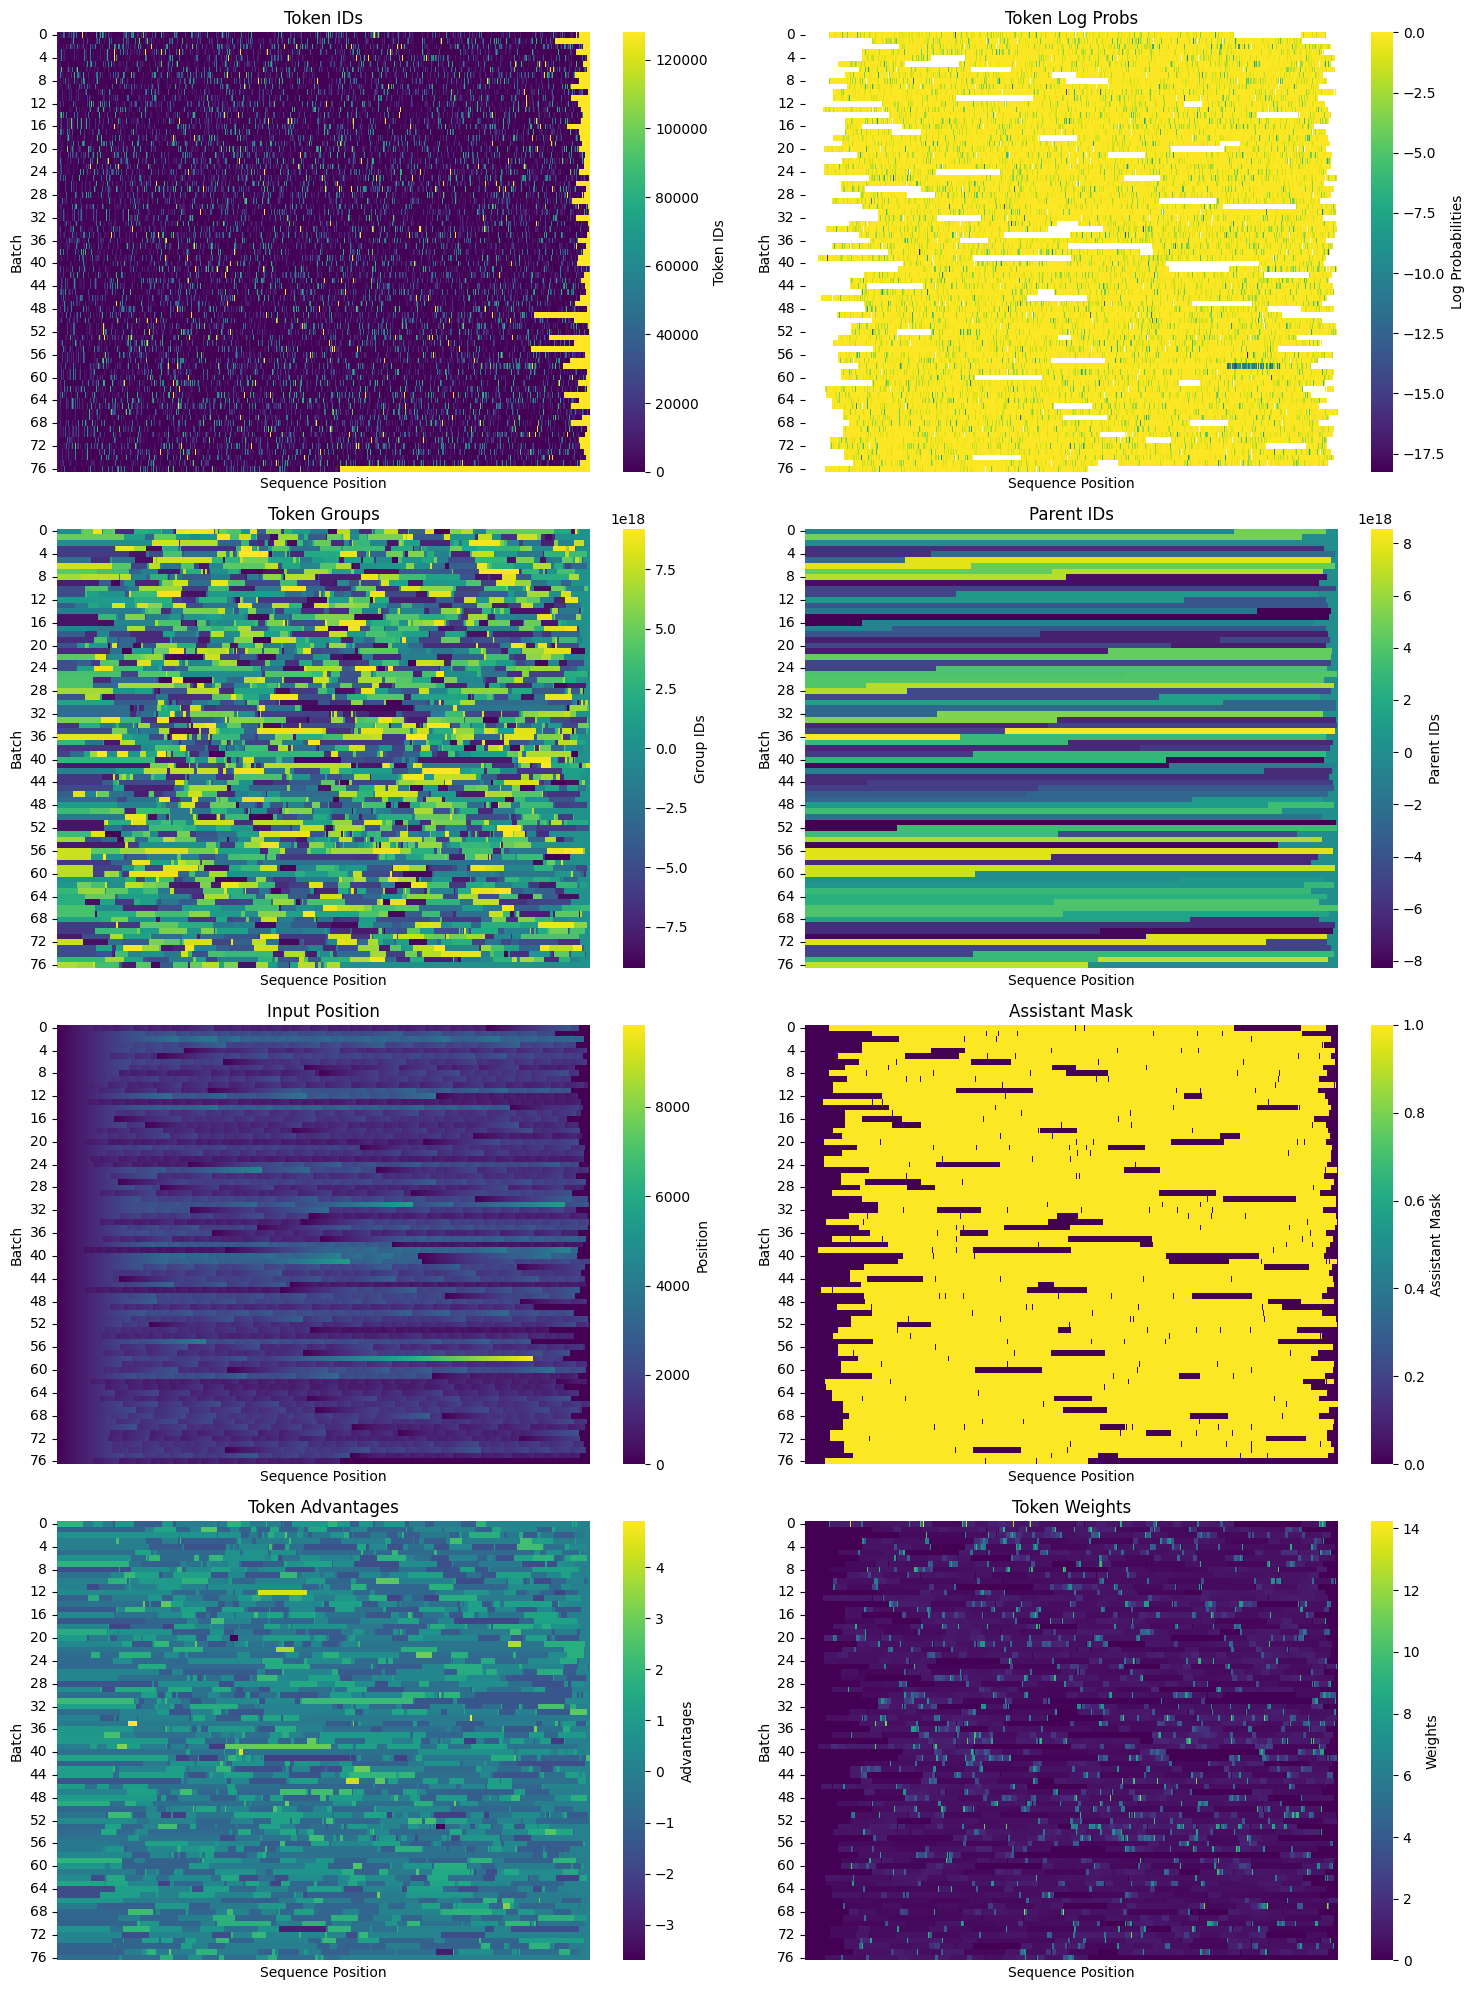

Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/blobs/15a75279e8911d4c1f515986546f6fcb5ad0717c
Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/blobs/65efd9e0e3baa04473b66aa4ad473e9302cf7fc6
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapshots/57a73110702e7b05ba3f39fef36297454c680725
  checkpoint_files:
  - model-00003-of-00004.safetensors
  - model-00001-of-00004.safetensors
  - model-00004-of-00004.safetensors
  - model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 77
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss

Writing logs to models/024/logs/log_1740098010.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.68 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|38|Loss: 0.0022: 100%|██████████| 38/38 [11:51<00:00, 18.45s/it, entropy=0.479, kl_div=nan, loss=0.00224, policy=0.00224]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.67 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved 

Saved iteration #1 model files to ./models/024/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0001 --port=8000 --api-key=default
INFO 02-21 00:46:16 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 00:46:17 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 00:46:17 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.46it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.06s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.50s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.65s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.40s/it]



INFO 02-21 00:46:37 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 00:46:38 worker.py:267] Memory profiling takes 0.77 seconds
INFO 02-21 00:46:38 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 00:46:38 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 00:46:38 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 00:46:38 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 00:47:23 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 45.82 seconds
INFO 02-21 00:47:24 api_server.py:756] Using supplied chat template:
INFO 02-21 00:47:24 api_server.py:756] None
INFO 02-21 00:47:24 launcher.py:21] Available routes are:
INFO 02-21 00:47:24 launcher.py:29] Route: /

INFO:     Started server process [8573]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 00:47:28 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:35840 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [03:28<00:00,  1.60it/s, completion_tokens=315, prompt_tokens=1.23e+3, reward=0.221, token_logprobs=1008708]


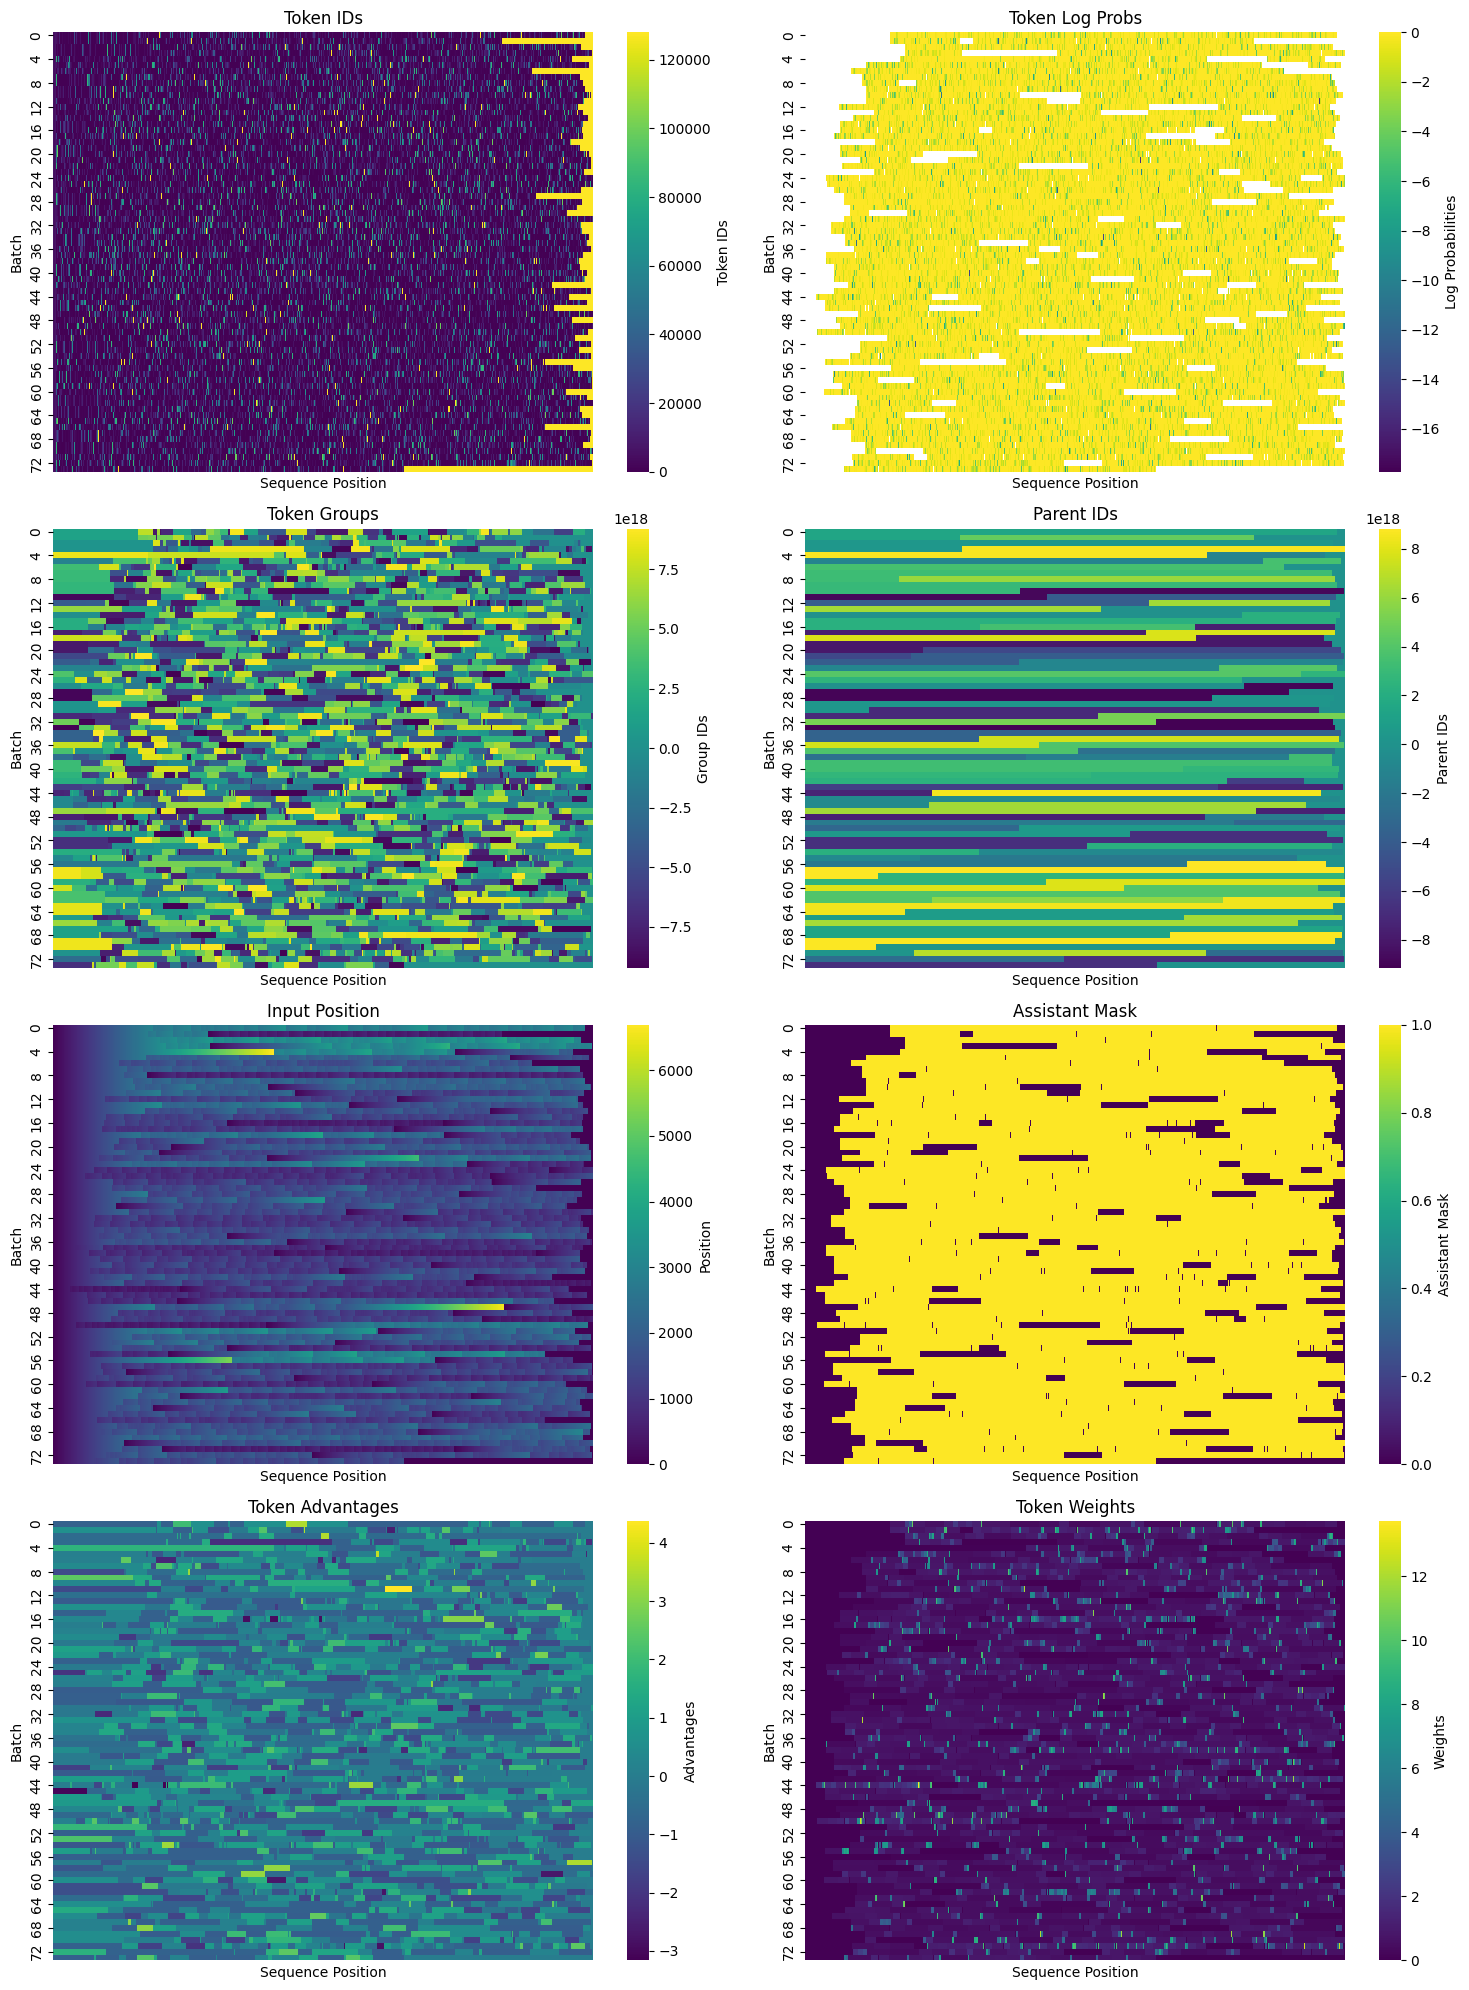

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0001
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 74
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740099088.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.59 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|37|Loss: 0.0811: 100%|██████████| 37/37 [11:32<00:00, 18.48s/it, entropy=0.546, kl_div=nan, loss=0.0811, policy=0.0811]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.59 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved to

Saved iteration #2 model files to ./models/024/0002
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0002 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0002 --port=8000 --api-key=default
INFO 02-21 01:03:56 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 01:03:57 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 01:03:57 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0002', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.45it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.07s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.54s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.67s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.42s/it]



INFO 02-21 01:04:17 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 01:04:18 worker.py:267] Memory profiling takes 0.70 seconds
INFO 02-21 01:04:18 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 01:04:18 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 01:04:18 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 01:04:18 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 01:05:04 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 46.13 seconds
INFO 02-21 01:05:04 api_server.py:756] Using supplied chat template:
INFO 02-21 01:05:04 api_server.py:756] None
INFO 02-21 01:05:04 launcher.py:21] Available routes are:
INFO 02-21 01:05:04 launcher.py:29] Route: /

INFO:     Started server process [9571]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 01:05:11 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 01:05:11 metrics.py:455] Avg prompt throughput: 1.5 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 01:05:11 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:41294 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [03:13<00:00,  7.90it/s, completion_tokens=272, prompt_tokens=1.17e+3, reward=0.254, token_logprobs=870508]
Deleted iteration directory ./models/024/0001


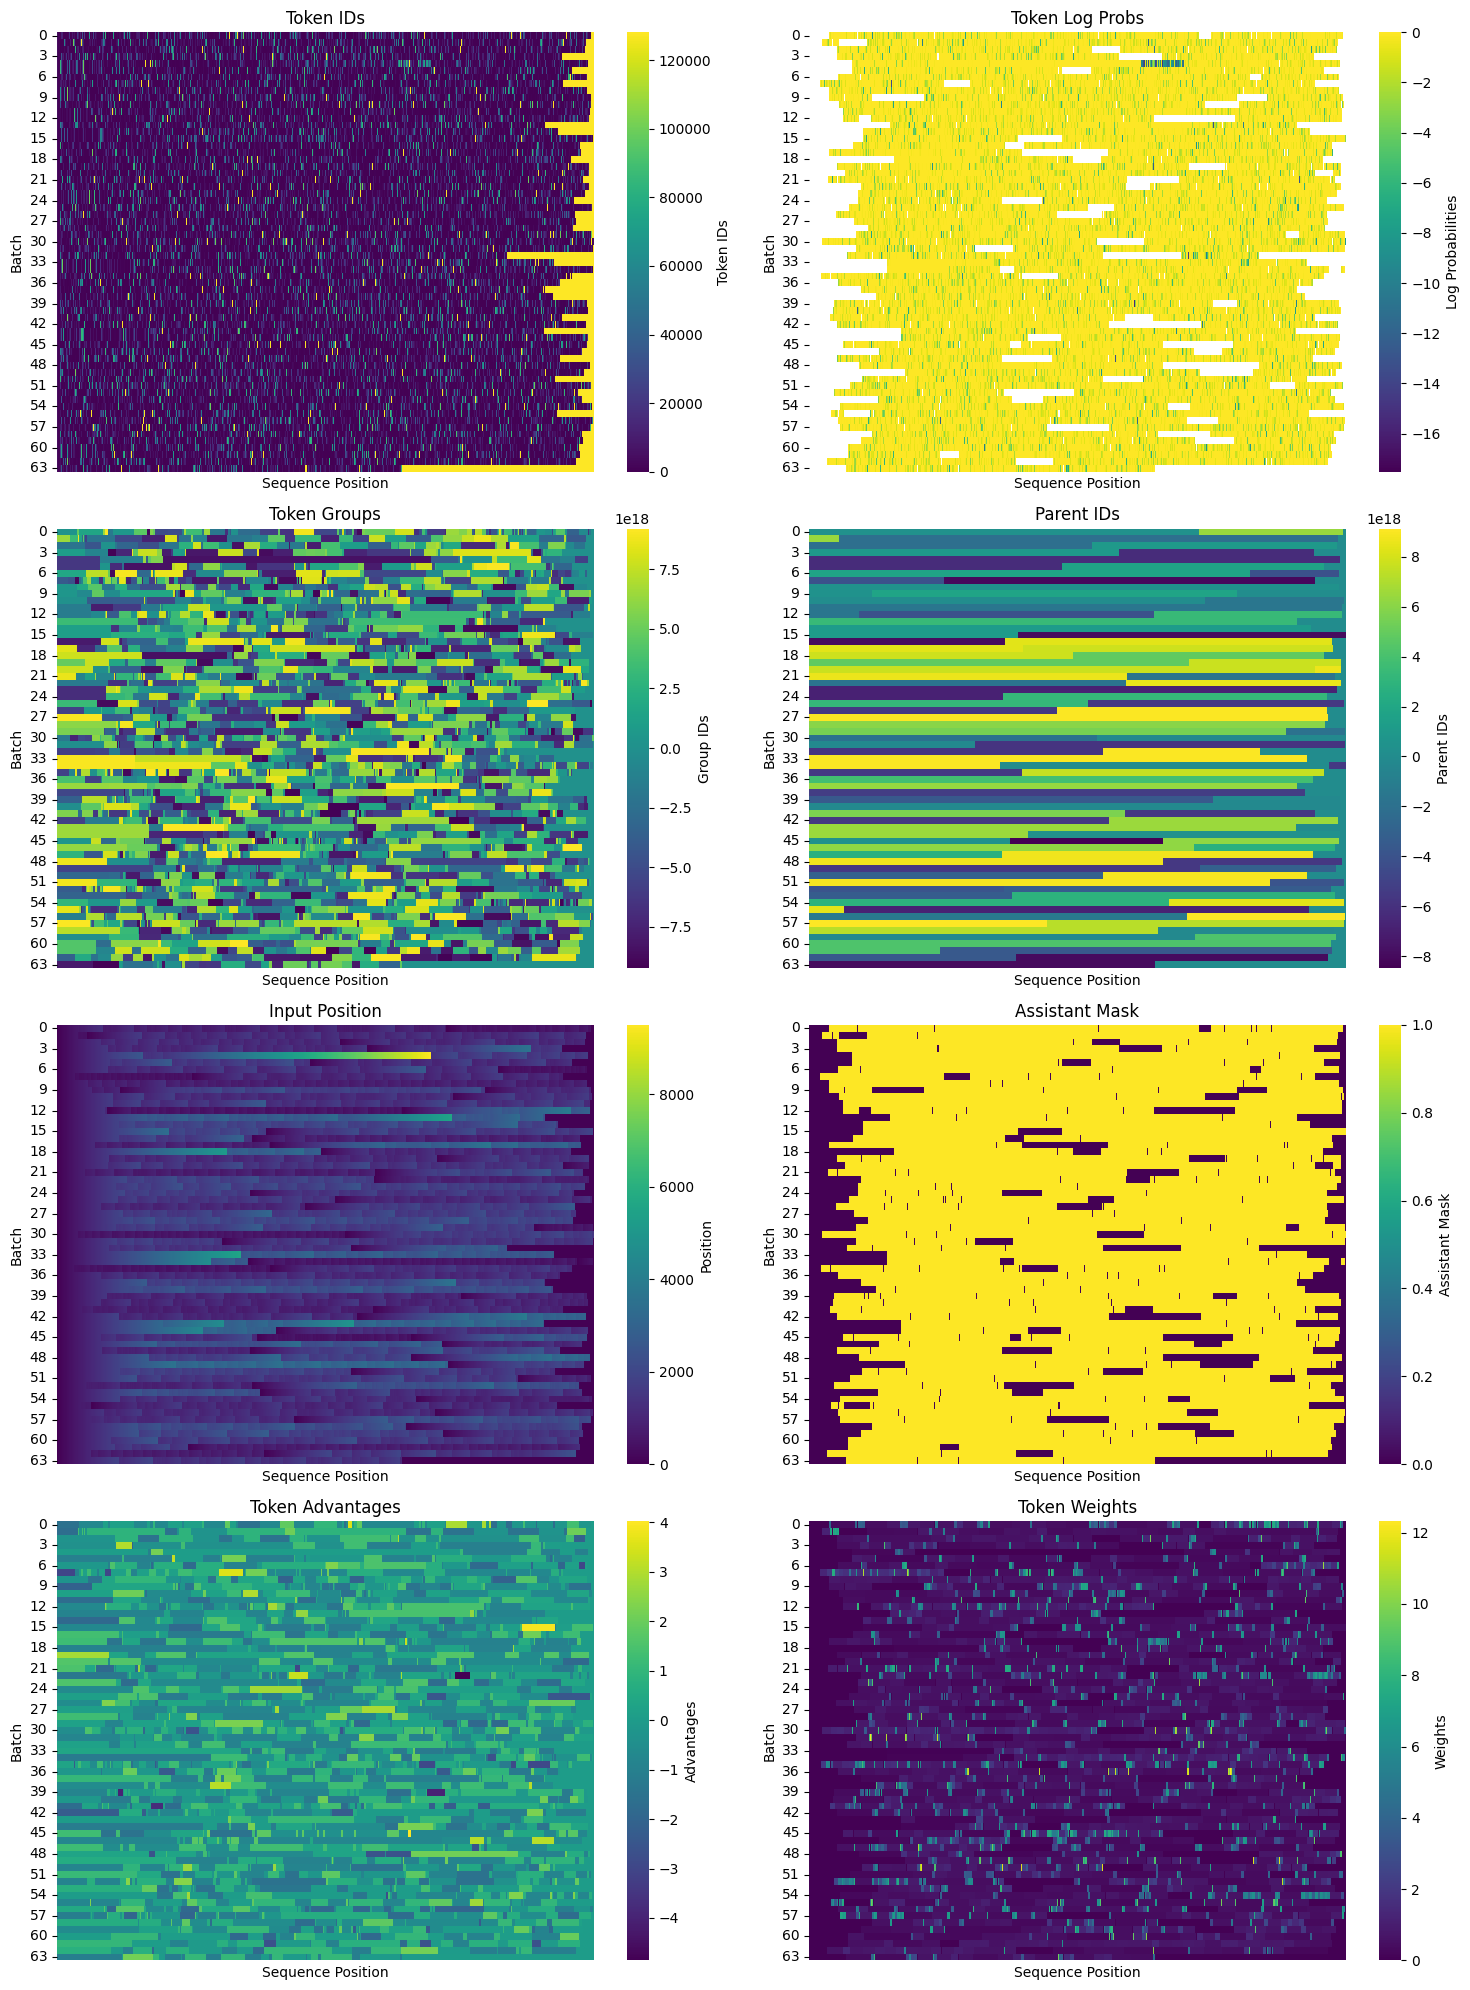

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0002
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 64
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740100135.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.54 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|32|Loss: 0.1341: 100%|██████████| 32/32 [10:00<00:00, 18.45s/it, entropy=0.42, kl_div=nan, loss=0.134, policy=0.134]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.51 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved to

Saved iteration #3 model files to ./models/024/0003
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0003 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0003 --port=8000 --api-key=default
INFO 02-21 01:19:50 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 01:19:51 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 01:19:51 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0003', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.45it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.06s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.52s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.66s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.41s/it]



INFO 02-21 01:20:11 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 01:20:12 worker.py:267] Memory profiling takes 0.71 seconds
INFO 02-21 01:20:12 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 01:20:12 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 01:20:12 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 01:20:12 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 01:20:57 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 45.94 seconds
INFO 02-21 01:20:58 api_server.py:756] Using supplied chat template:
INFO 02-21 01:20:58 api_server.py:756] None
INFO 02-21 01:20:58 launcher.py:21] Available routes are:
INFO 02-21 01:20:58 launcher.py:29] Route: /

INFO:     Started server process [10676]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 01:20:59 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:58712 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:55<00:00,  2.47it/s, completion_tokens=245, prompt_tokens=1.14e+3, reward=0.252, token_logprobs=783126]
Deleted iteration directory ./models/024/0002


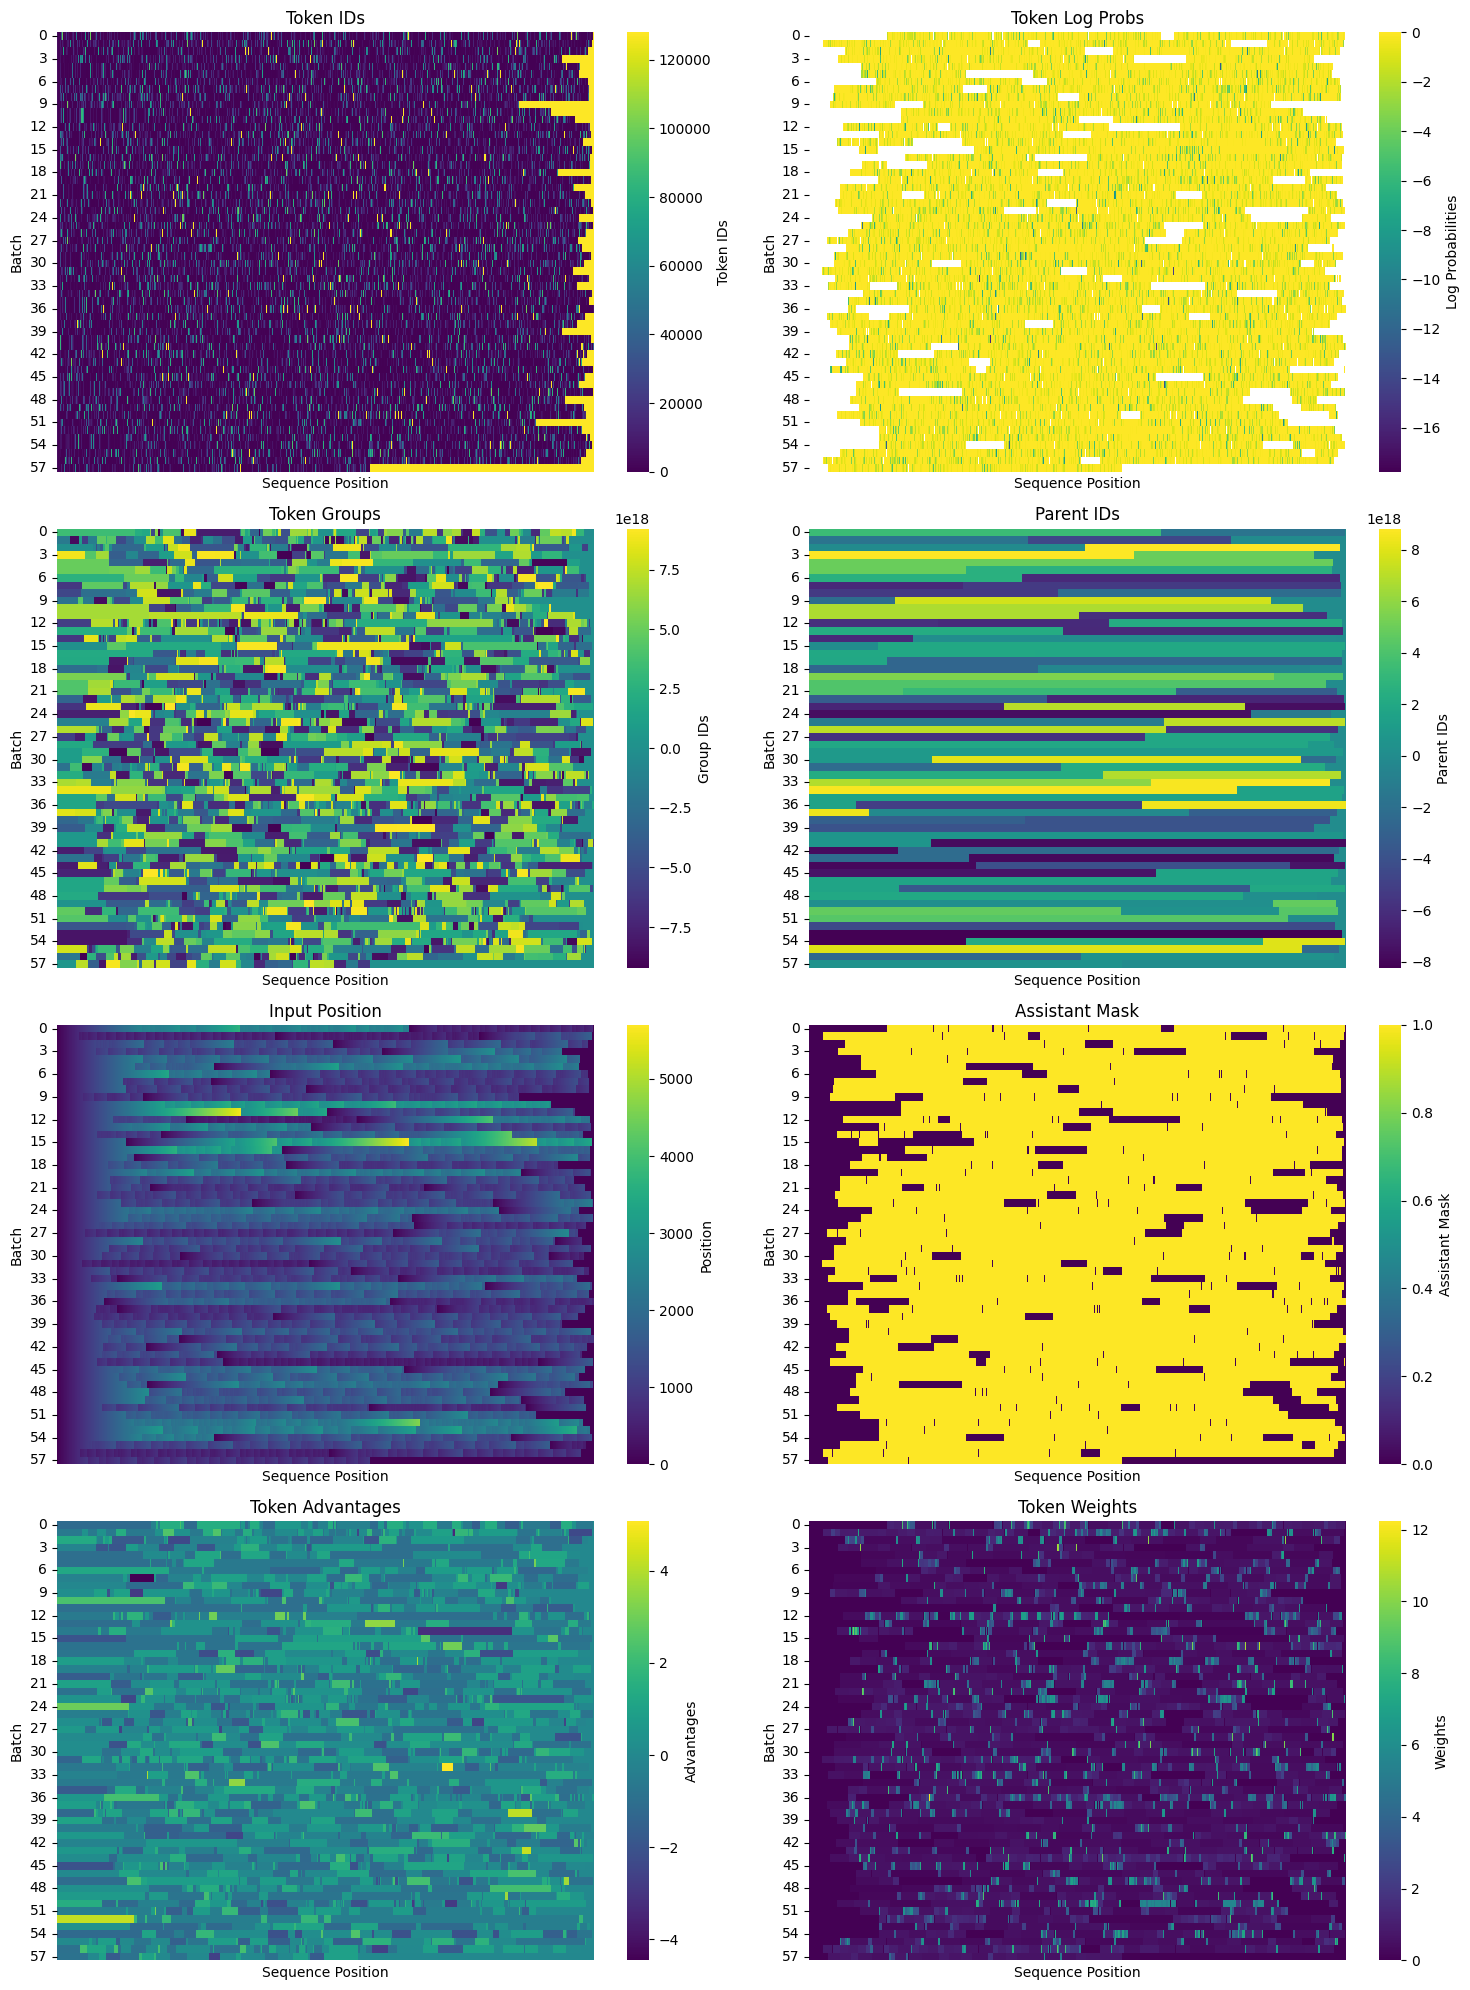

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0003
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 58
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740101065.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.78 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|29|Loss: 0.0801: 100%|██████████| 29/29 [09:05<00:00, 18.44s/it, entropy=0.585, kl_div=nan, loss=0.0801, policy=0.0801]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.63 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved to

Saved iteration #4 model files to ./models/024/0004
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0004 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0004 --port=8000 --api-key=default
INFO 02-21 01:34:25 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 01:34:26 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 01:34:26 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0004', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.44it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.12s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.56s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.68s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.44s/it]



INFO 02-21 01:34:46 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 01:34:47 worker.py:267] Memory profiling takes 0.70 seconds
INFO 02-21 01:34:47 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 01:34:47 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 01:34:47 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 01:34:47 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 01:35:32 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 45.87 seconds
INFO 02-21 01:35:33 api_server.py:756] Using supplied chat template:
INFO 02-21 01:35:33 api_server.py:756] None
INFO 02-21 01:35:33 launcher.py:21] Available routes are:
INFO 02-21 01:35:33 launcher.py:29] Route: /

INFO:     Started server process [11417]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 01:35:38 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:34646 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [03:39<00:00, 12.08s/it, completion_tokens=228, prompt_tokens=1.15e+3, reward=0.264, token_logprobs=730186]
Deleted iteration directory ./models/024/0003


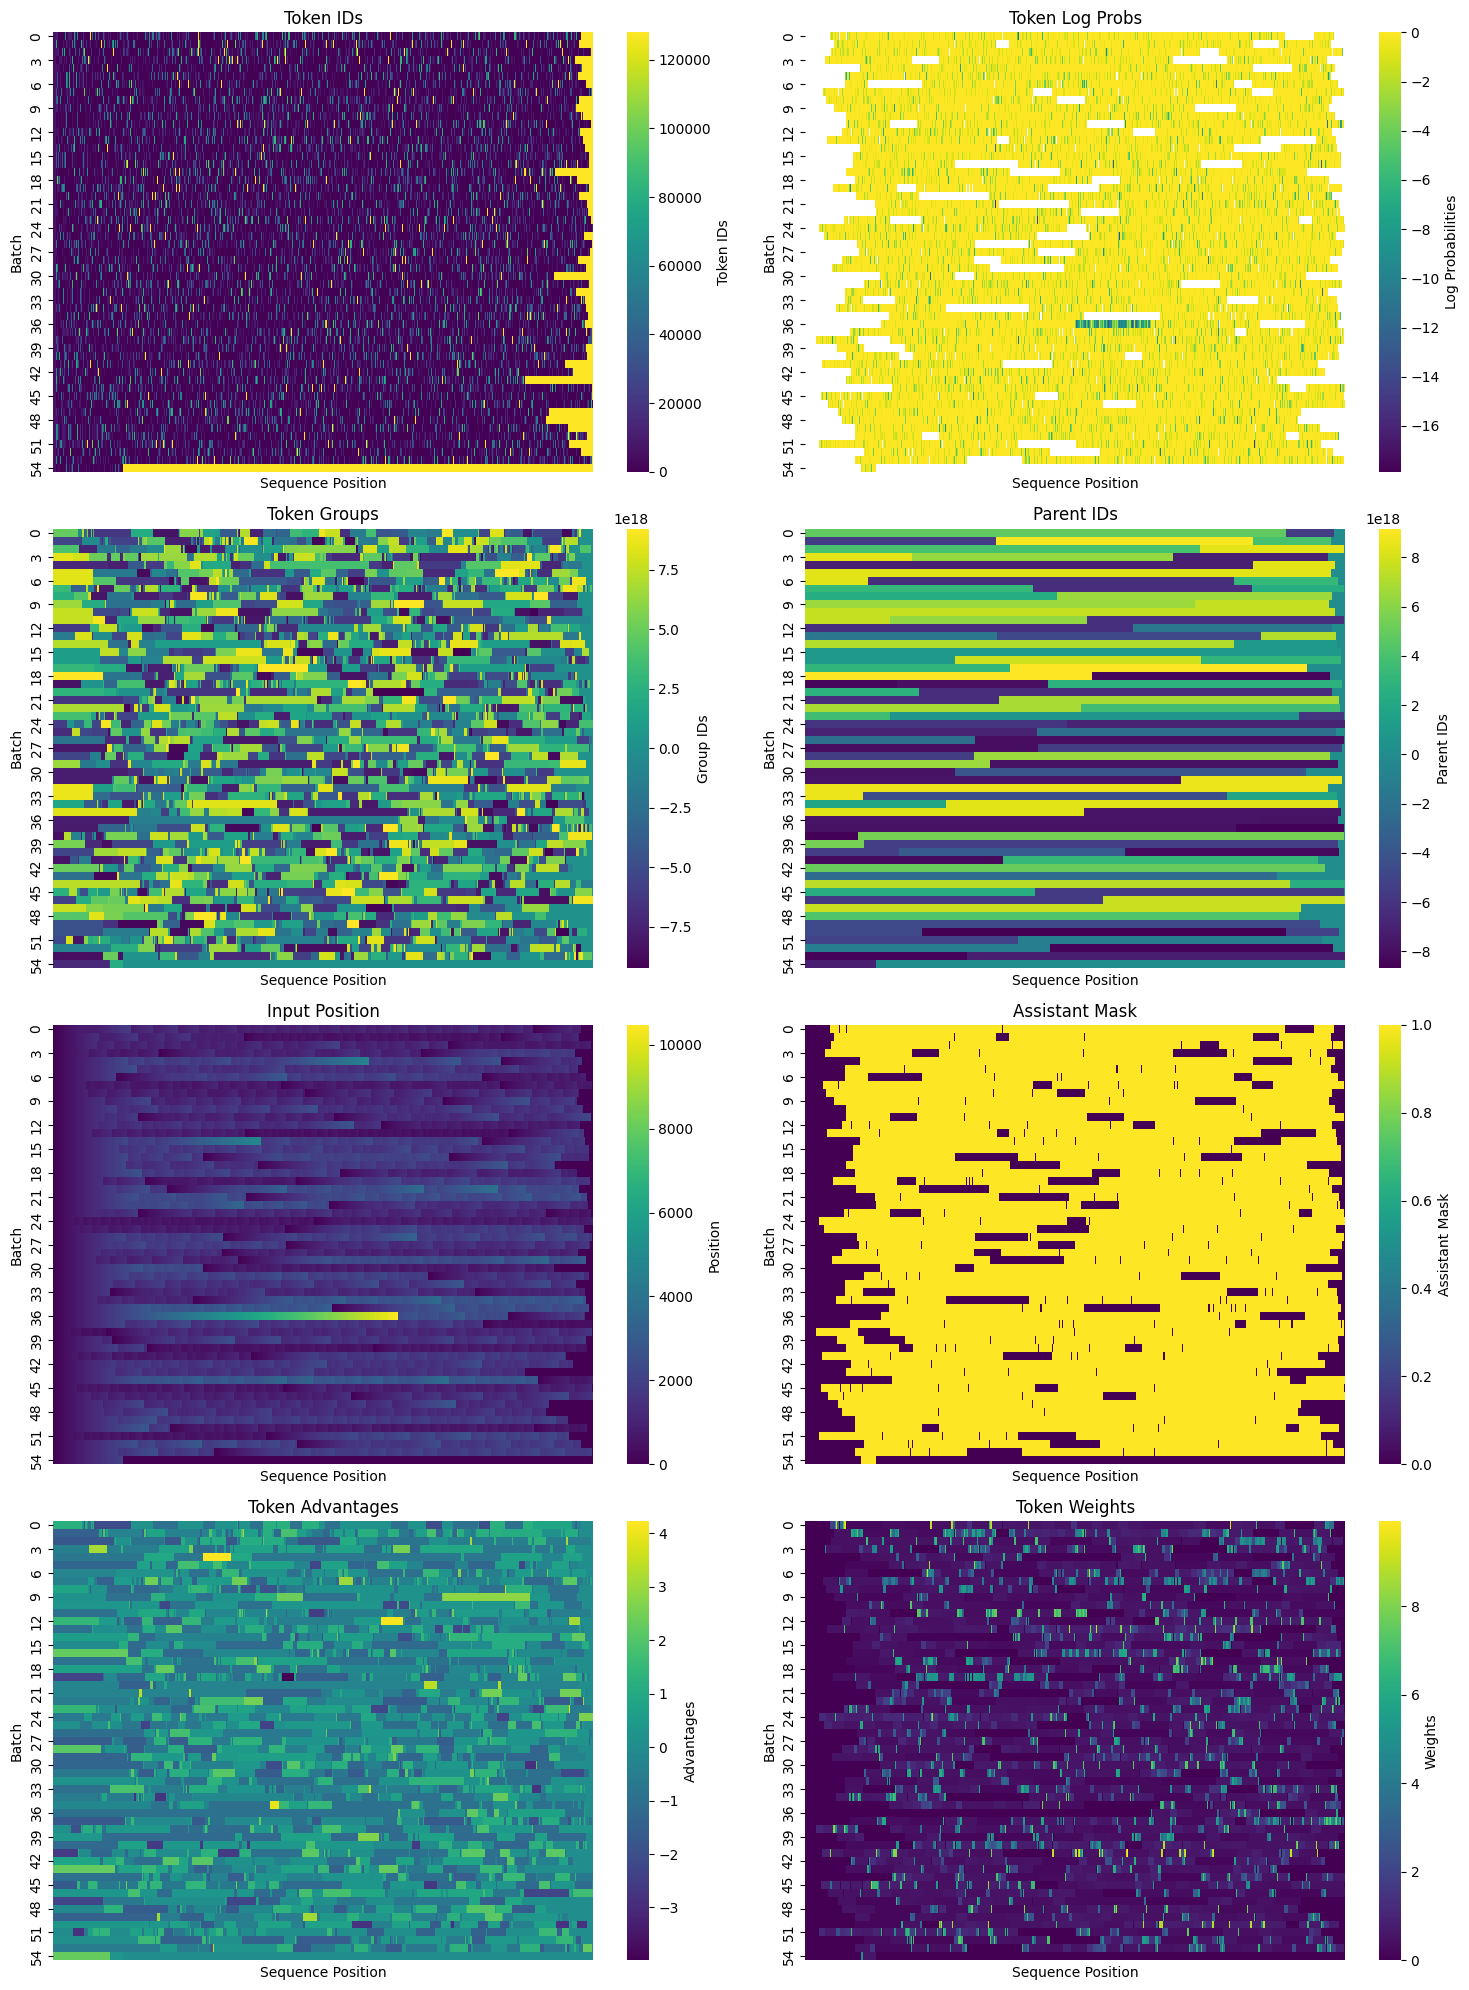

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0004
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 55
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740101986.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.74 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|27|Loss: 0.0738: 100%|██████████| 27/27 [08:28<00:00, 18.44s/it, entropy=0.504, kl_div=nan, loss=0.0738, policy=0.0738]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.49 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved to

Saved iteration #5 model files to ./models/024/0005
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0005 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0005 --port=8000 --api-key=default
INFO 02-21 01:49:09 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 01:49:10 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 01:49:10 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0005', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.44it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.07s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.51s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.66s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.41s/it]



INFO 02-21 01:49:30 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 01:49:31 worker.py:267] Memory profiling takes 0.69 seconds
INFO 02-21 01:49:31 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 01:49:31 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 01:49:31 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 01:49:31 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 01:50:17 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 46.15 seconds
INFO 02-21 01:50:17 api_server.py:756] Using supplied chat template:
INFO 02-21 01:50:17 api_server.py:756] None
INFO 02-21 01:50:17 launcher.py:21] Available routes are:
INFO 02-21 01:50:17 launcher.py:29] Route: /

INFO:     Started server process [12205]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 01:50:19 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:36494 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:39<00:00, 127.33it/s, completion_tokens=207, prompt_tokens=1.3e+3, reward=0.263, token_logprobs=661623]
Deleted iteration directory ./models/024/0004


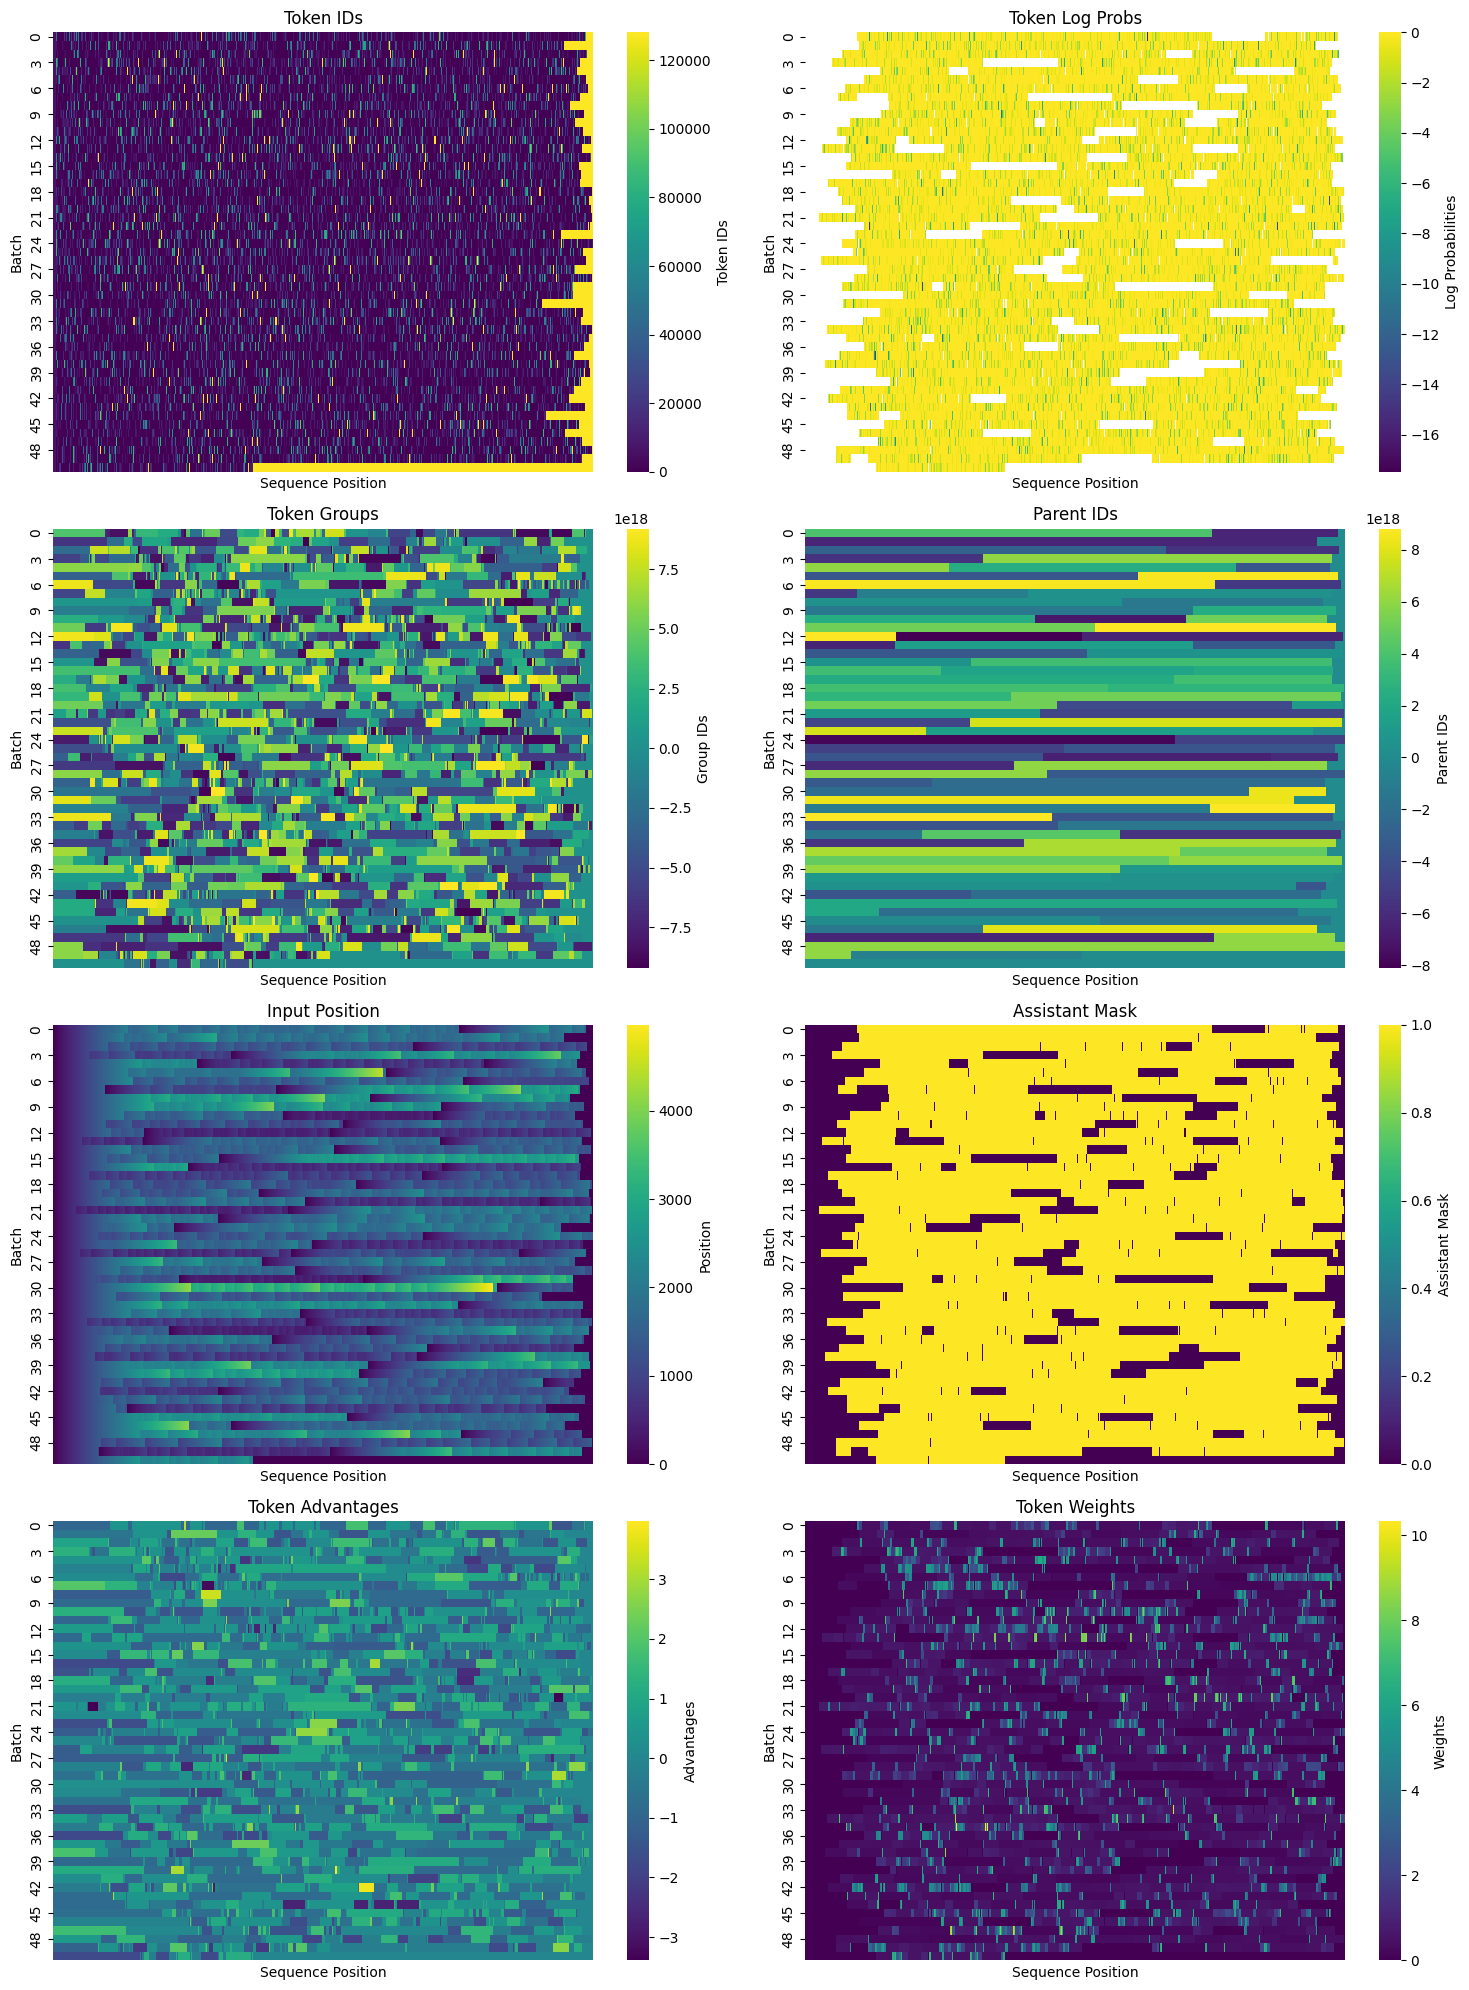

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0005
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 51
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740102808.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.64 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|25|Loss: -0.0450: 100%|██████████| 25/25 [07:51<00:00, 18.45s/it, entropy=0.494, kl_div=nan, loss=-0.045, policy=-0.045]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.72 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved t

Saved iteration #6 model files to ./models/024/0006
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0006 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0006 --port=8000 --api-key=default
INFO 02-21 02:02:14 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 02:02:15 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 02:02:15 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0006', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.44it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.11s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.53s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.66s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.42s/it]



INFO 02-21 02:02:35 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 02:02:36 worker.py:267] Memory profiling takes 0.70 seconds
INFO 02-21 02:02:36 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 02:02:36 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 02:02:36 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 02:02:36 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 02:03:21 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 45.90 seconds
INFO 02-21 02:03:22 api_server.py:756] Using supplied chat template:
INFO 02-21 02:03:22 api_server.py:756] None
INFO 02-21 02:03:22 launcher.py:21] Available routes are:
INFO 02-21 02:03:22 launcher.py:29] Route: /

INFO:     Started server process [12942]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 02:03:25 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:49654 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:57<00:00,  4.53it/s, completion_tokens=201, prompt_tokens=1.29e+3, reward=0.231, token_logprobs=643973]
Deleted iteration directory ./models/024/0005


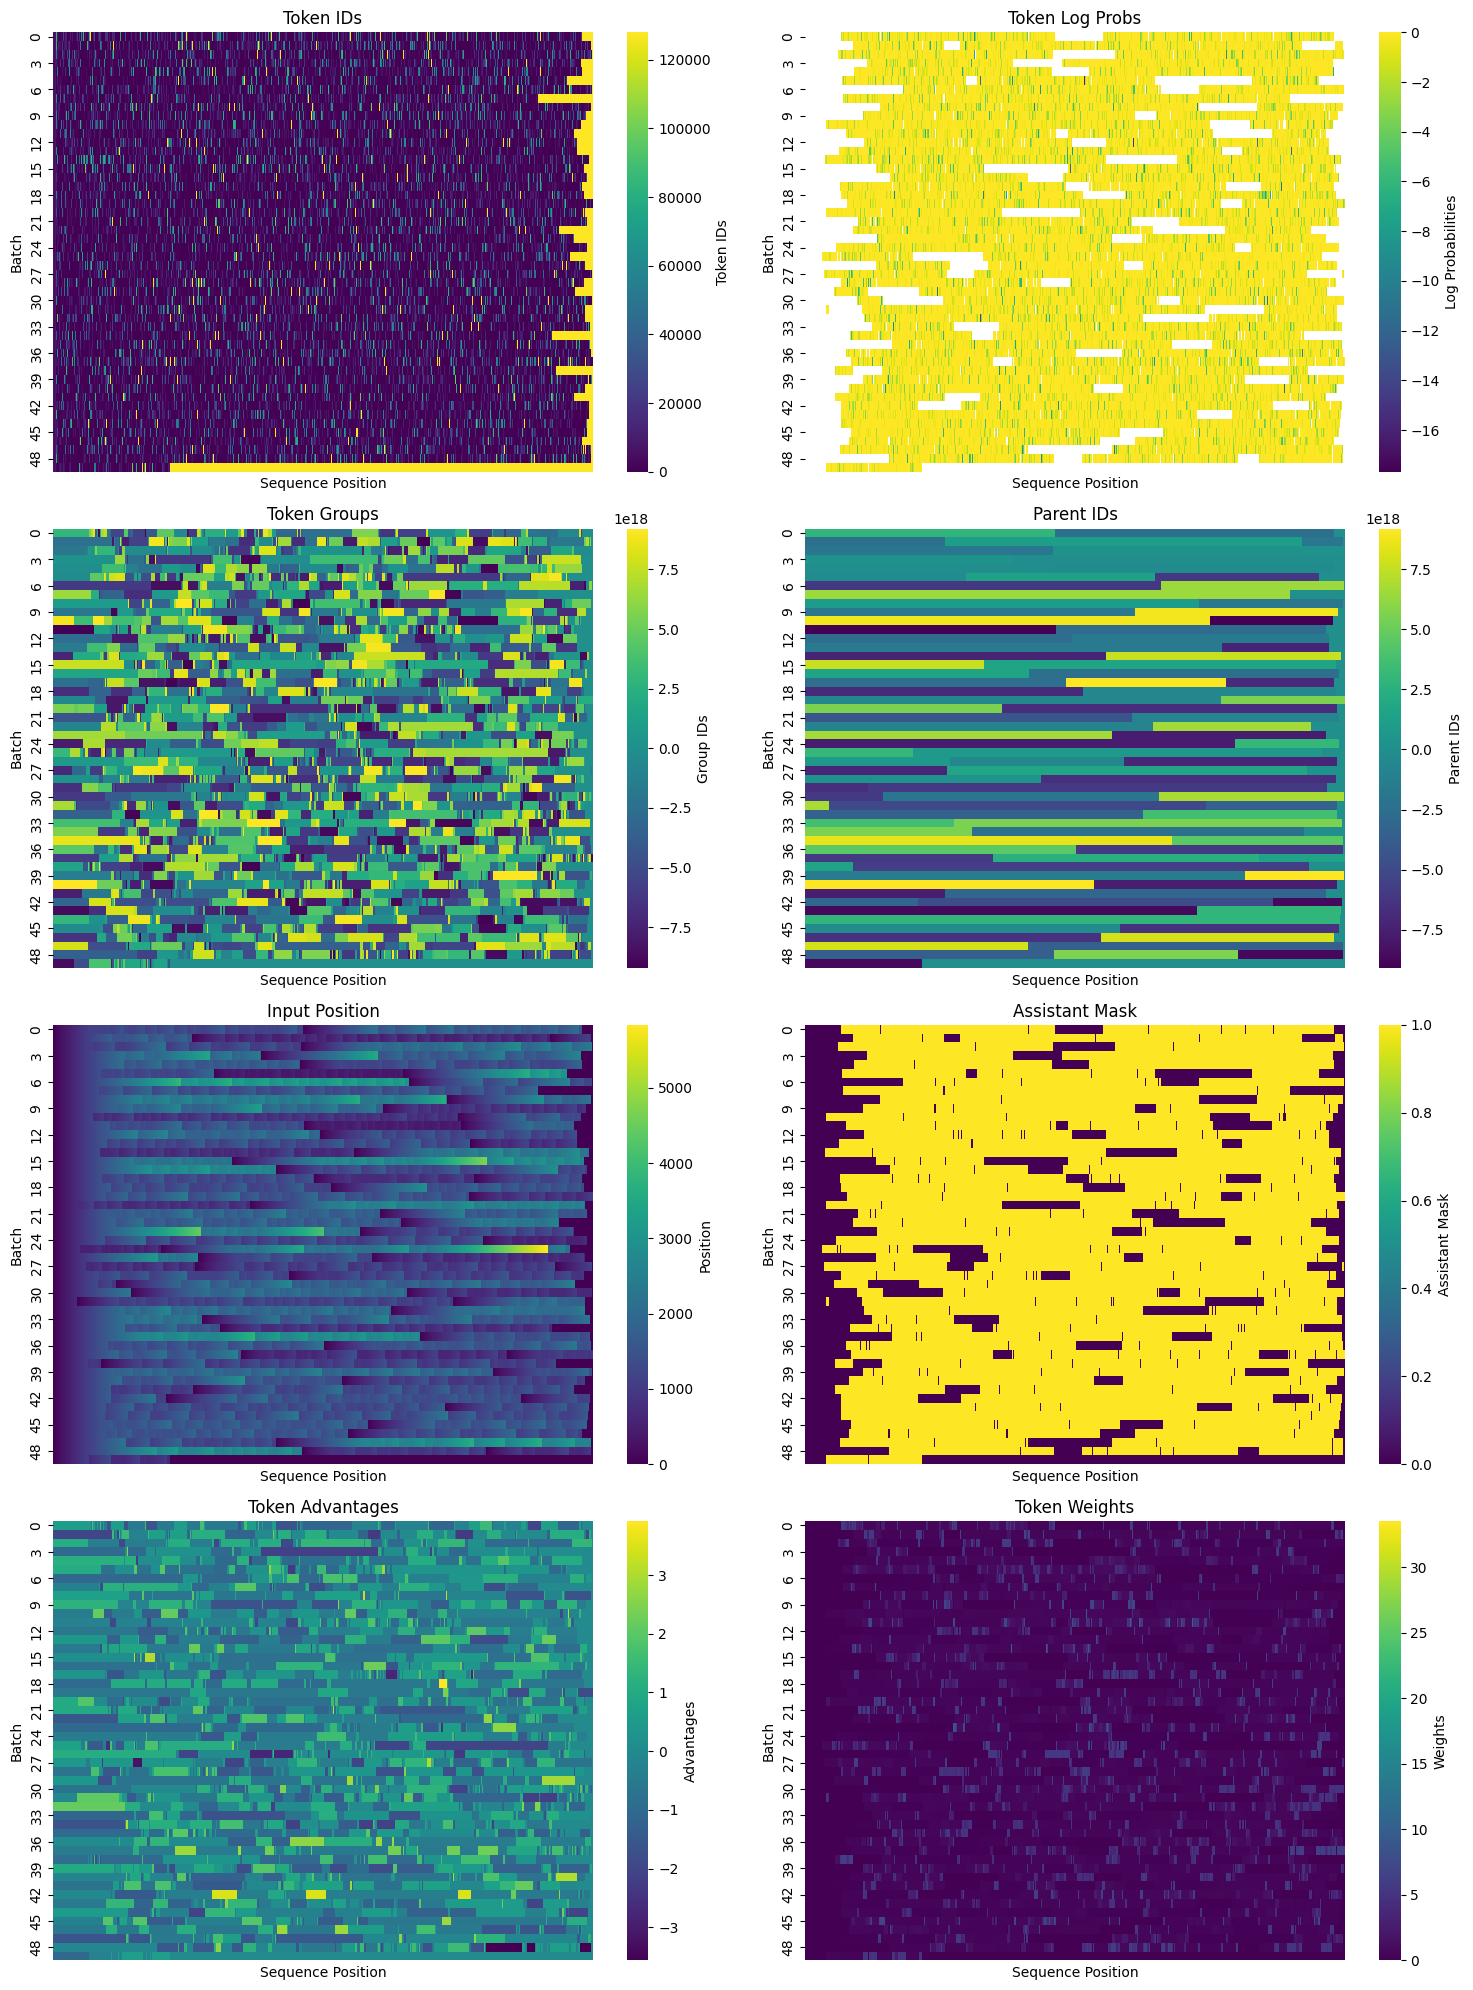

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0006
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 50
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740103611.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.68 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|25|Loss: -0.0338: 100%|██████████| 25/25 [07:51<00:00, 18.43s/it, entropy=0.432, kl_div=nan, loss=-0.0338, policy=-0.0338]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.61 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved

Saved iteration #7 model files to ./models/024/0007
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0007 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0007 --port=8000 --api-key=default
INFO 02-21 02:15:37 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 02:15:38 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 02:15:38 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0007', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.44it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.06s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.48s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.63s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.39s/it]



INFO 02-21 02:15:58 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 02:15:59 worker.py:267] Memory profiling takes 0.72 seconds
INFO 02-21 02:15:59 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 02:15:59 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 02:15:59 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 02:15:59 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 02:16:44 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 45.95 seconds
INFO 02-21 02:16:45 api_server.py:756] Using supplied chat template:
INFO 02-21 02:16:45 api_server.py:756] None
INFO 02-21 02:16:45 launcher.py:21] Available routes are:
INFO 02-21 02:16:45 launcher.py:29] Route: /

INFO:     Started server process [13669]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 02:16:51 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 02:16:51 metrics.py:455] Avg prompt throughput: 1.7 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 02:16:51 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:51806 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:45<00:00,  3.25it/s, completion_tokens=177, prompt_tokens=1.17e+3, reward=0.246, token_logprobs=566893]


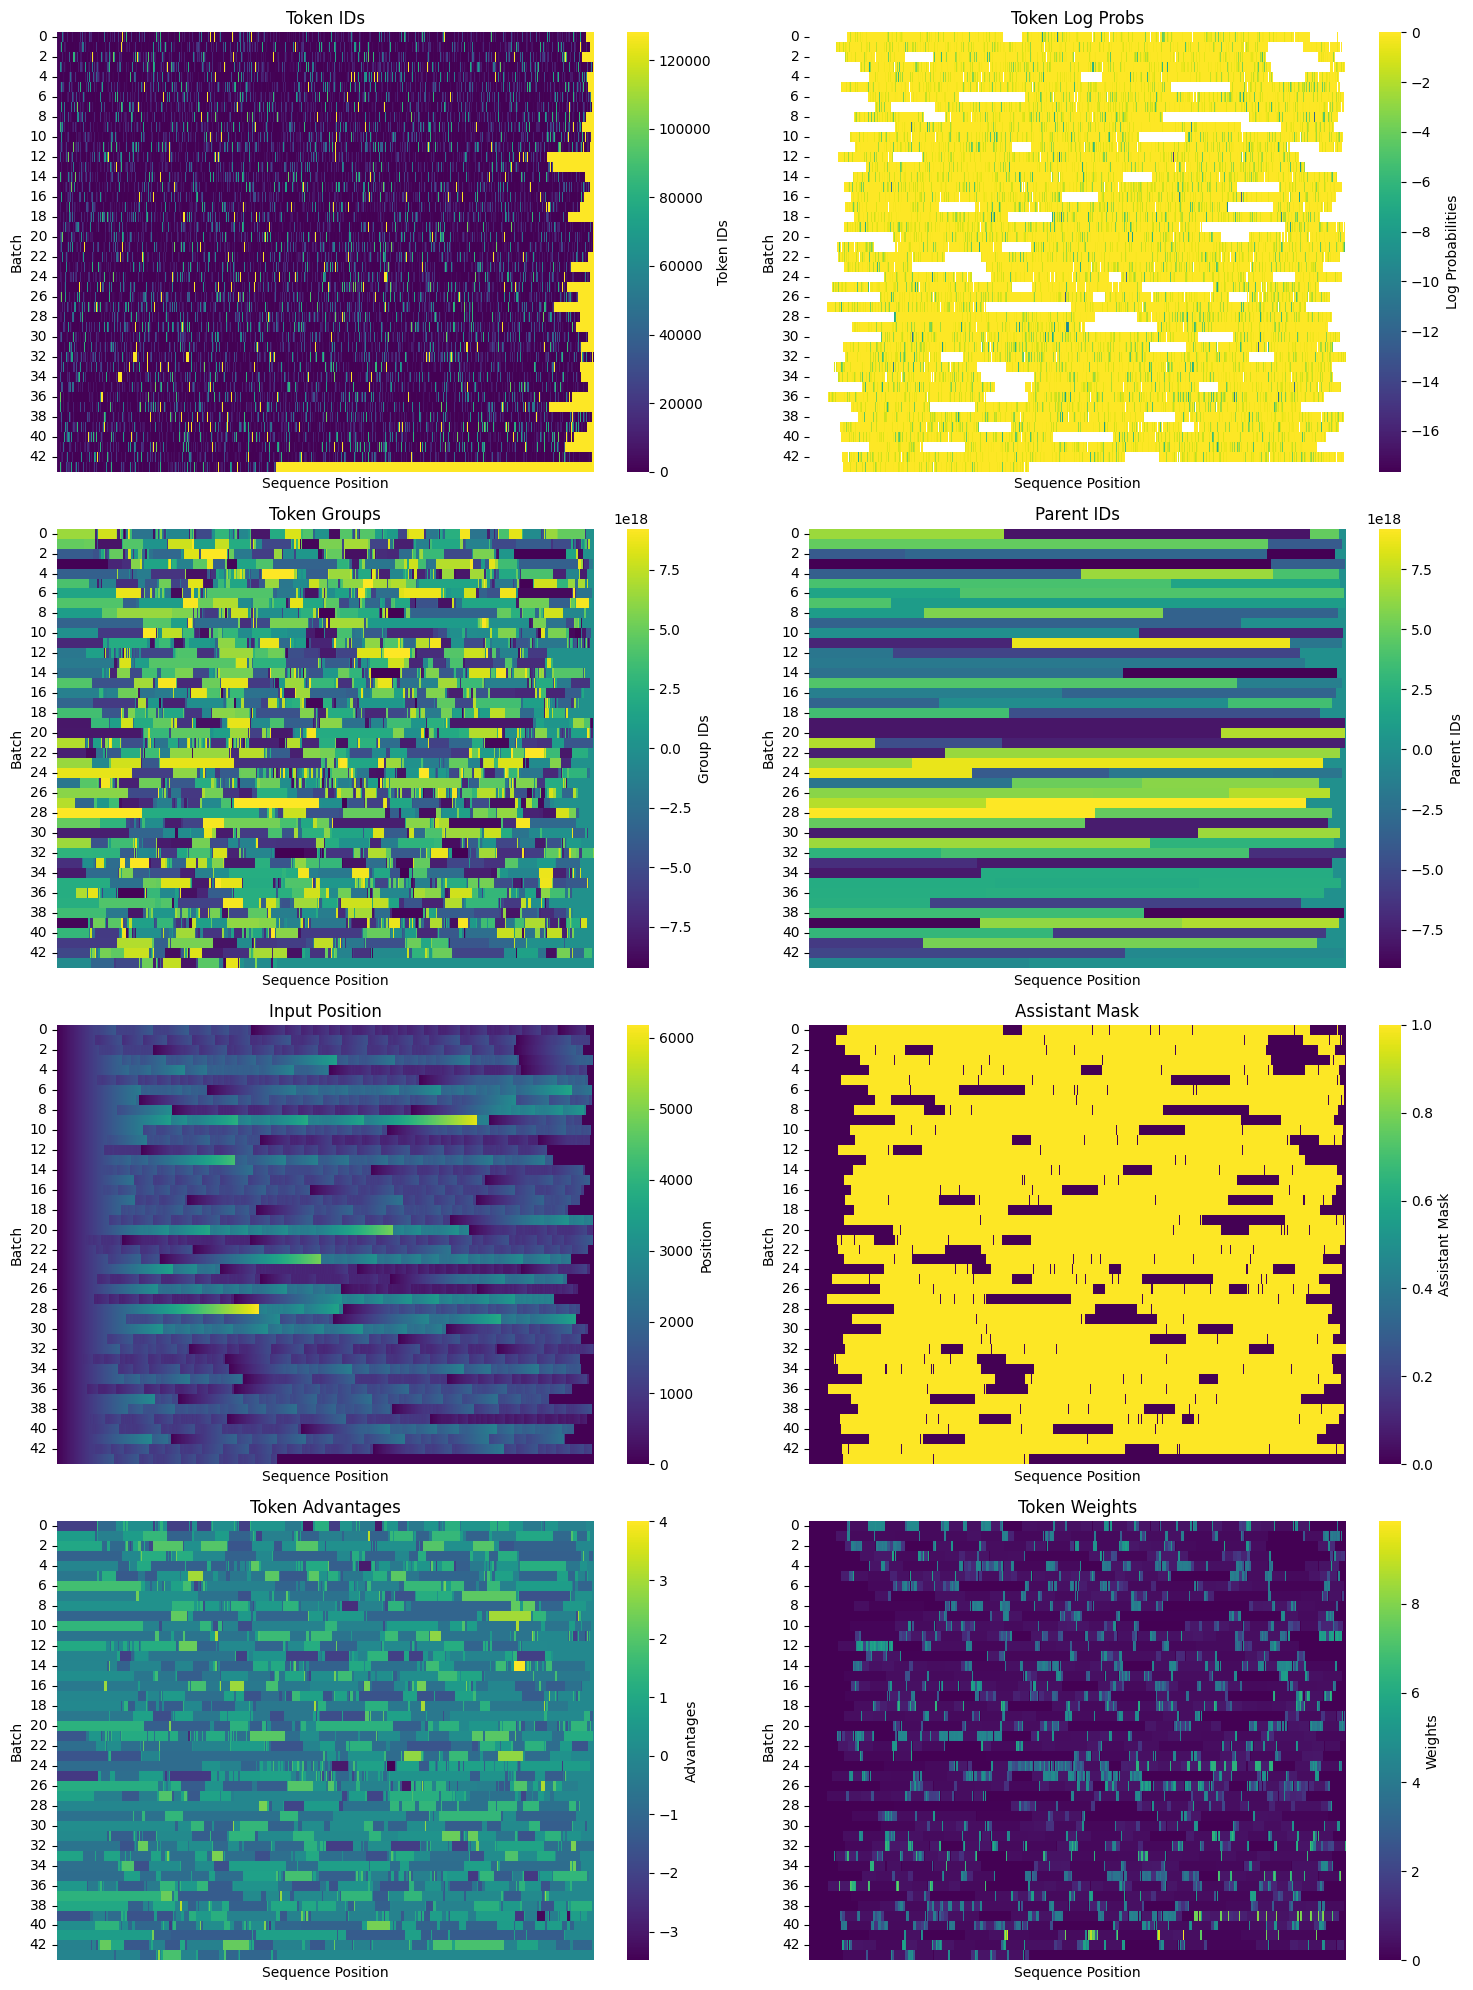

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0007
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 44
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740104402.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.76 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|22|Loss: -0.0688: 100%|██████████| 22/22 [06:56<00:00, 18.49s/it, entropy=0.404, kl_div=nan, loss=-0.0688, policy=-0.0688]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.61 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved

Saved iteration #8 model files to ./models/024/0008
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0008 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0008 --port=8000 --api-key=default
INFO 02-21 02:27:54 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 02:27:55 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 02:27:55 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0008', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.43it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.06s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.48s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.64s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.39s/it]



INFO 02-21 02:28:15 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 02:28:16 worker.py:267] Memory profiling takes 0.69 seconds
INFO 02-21 02:28:16 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 02:28:16 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 02:28:16 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 02:28:16 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 02:29:01 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 46.10 seconds
INFO 02-21 02:29:02 api_server.py:756] Using supplied chat template:
INFO 02-21 02:29:02 api_server.py:756] None
INFO 02-21 02:29:02 launcher.py:21] Available routes are:
INFO 02-21 02:29:02 launcher.py:29] Route: /

INFO:     Started server process [14635]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 02:29:06 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:55218 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:18<00:00,  7.07it/s, completion_tokens=142, prompt_tokens=1.17e+3, reward=0.249, token_logprobs=455535]
Deleted iteration directory ./models/024/0007


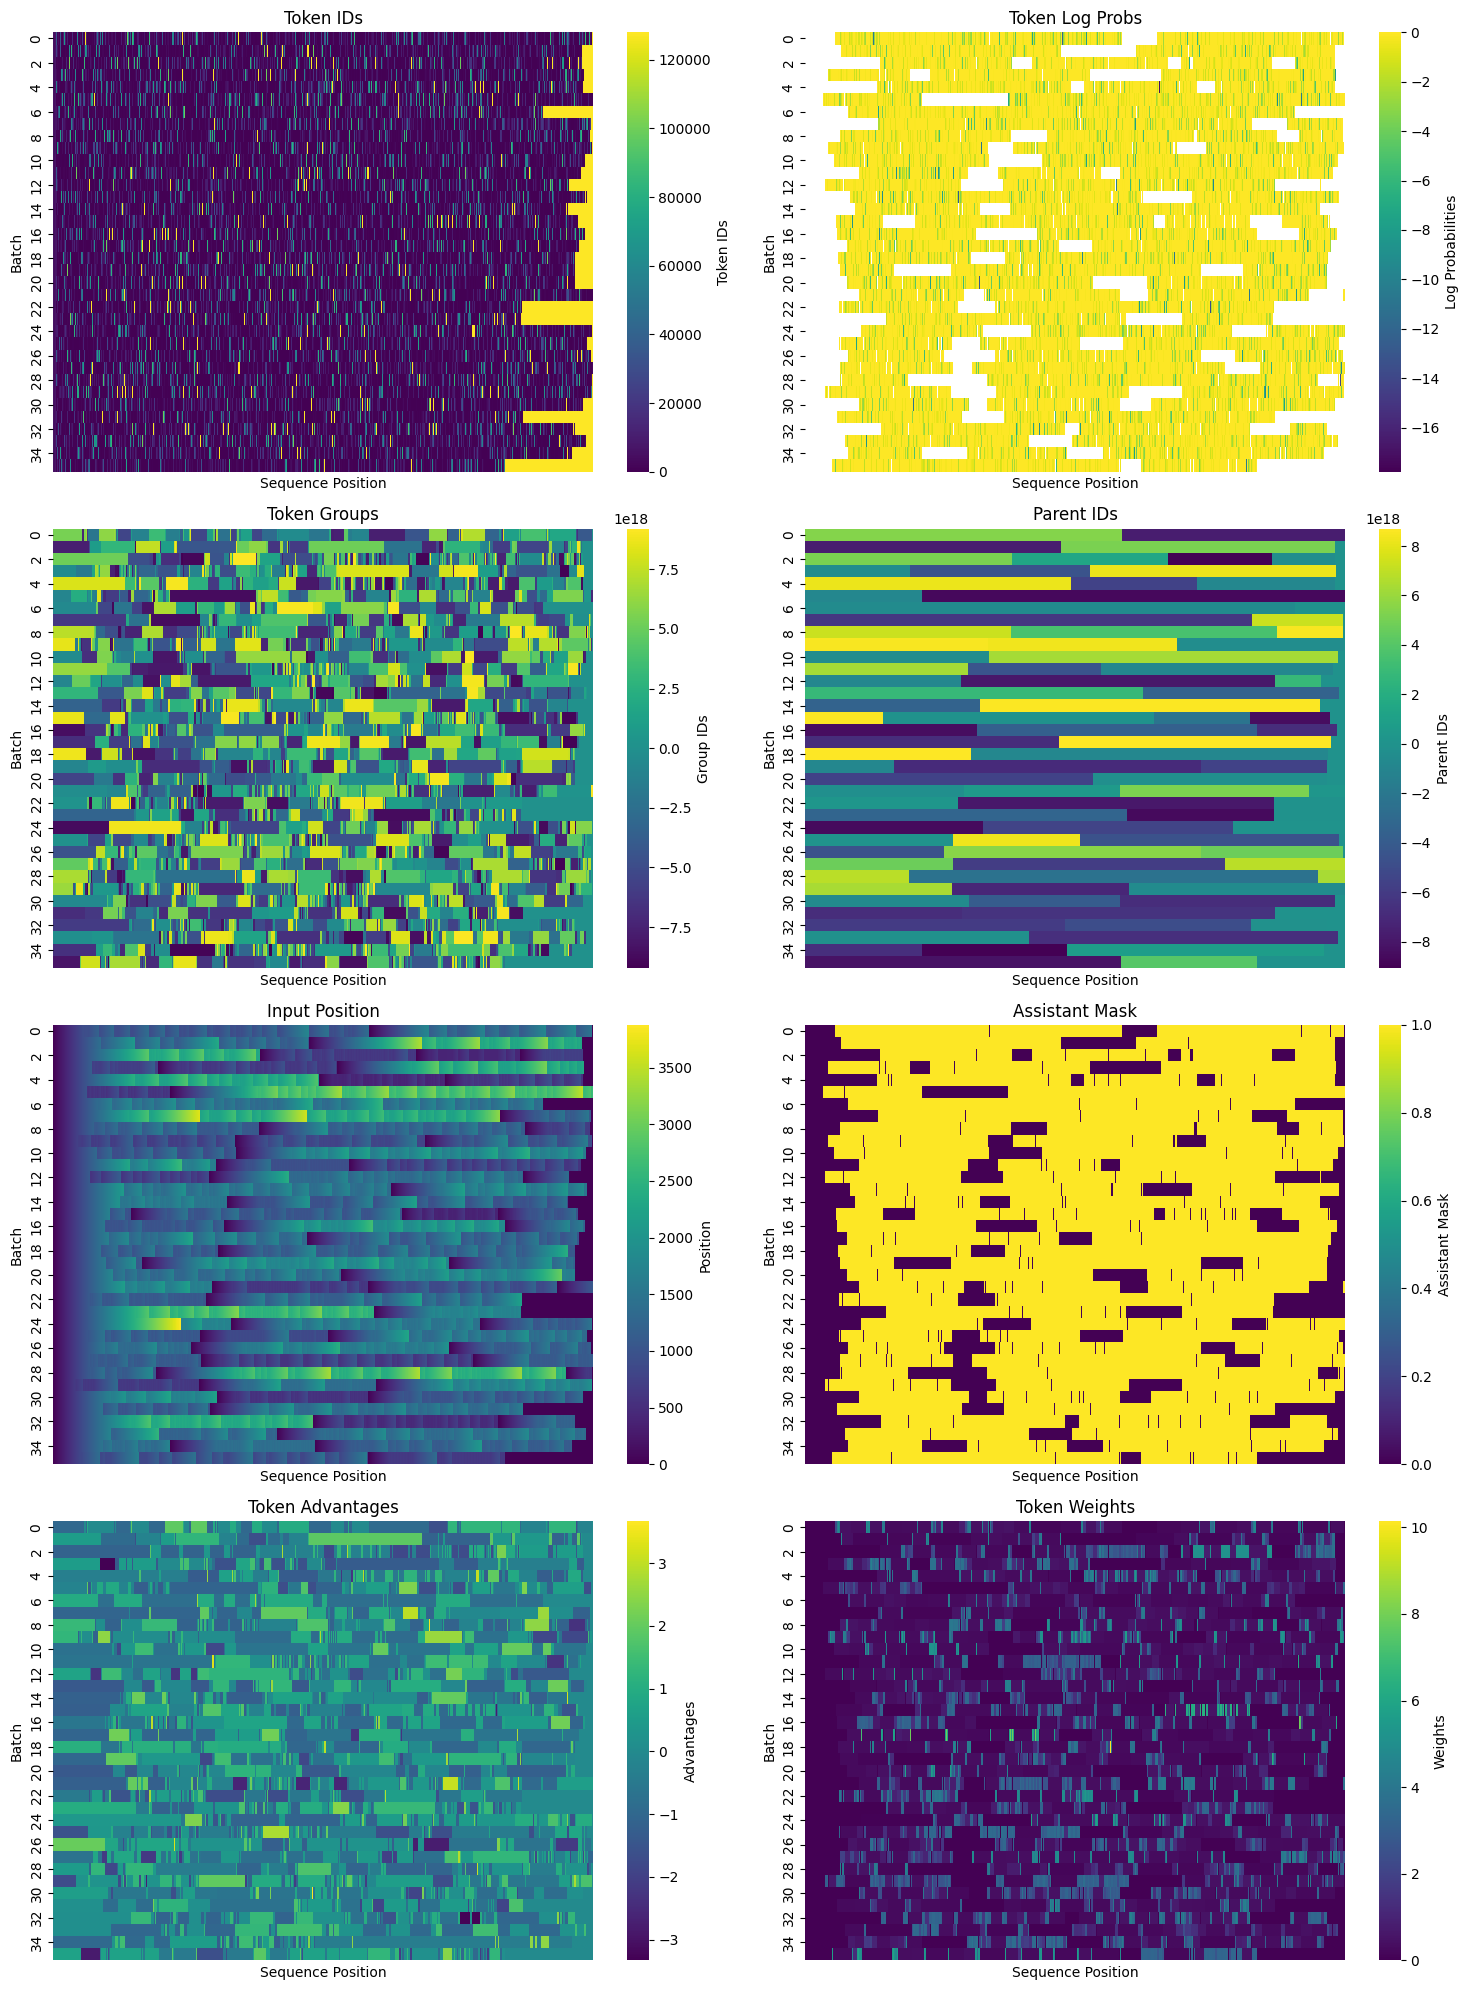

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0008
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 36
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740105110.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.65 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|18|Loss: 0.0077: 100%|██████████| 18/18 [05:42<00:00, 18.43s/it, entropy=0.358, kl_div=nan, loss=0.0077, policy=0.0077]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.65 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved to

Saved iteration #9 model files to ./models/024/0009
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0009 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0009 --port=8000 --api-key=default
INFO 02-21 02:38:28 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 02:38:28 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 02:38:28 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0009', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.44it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.11s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.51s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.66s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.42s/it]



INFO 02-21 02:38:49 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 02:38:49 worker.py:267] Memory profiling takes 0.70 seconds
INFO 02-21 02:38:49 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 02:38:49 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 02:38:49 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 02:38:49 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 02:39:35 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 46.18 seconds
INFO 02-21 02:39:35 api_server.py:756] Using supplied chat template:
INFO 02-21 02:39:35 api_server.py:756] None
INFO 02-21 02:39:35 launcher.py:21] Available routes are:
INFO 02-21 02:39:35 launcher.py:29] Route: /

INFO:     Started server process [15338]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 02:39:40 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:48106 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:19<00:00, 41.39it/s, completion_tokens=148, prompt_tokens=1.25e+3, reward=0.244, token_logprobs=473044]
Deleted iteration directory ./models/024/0008


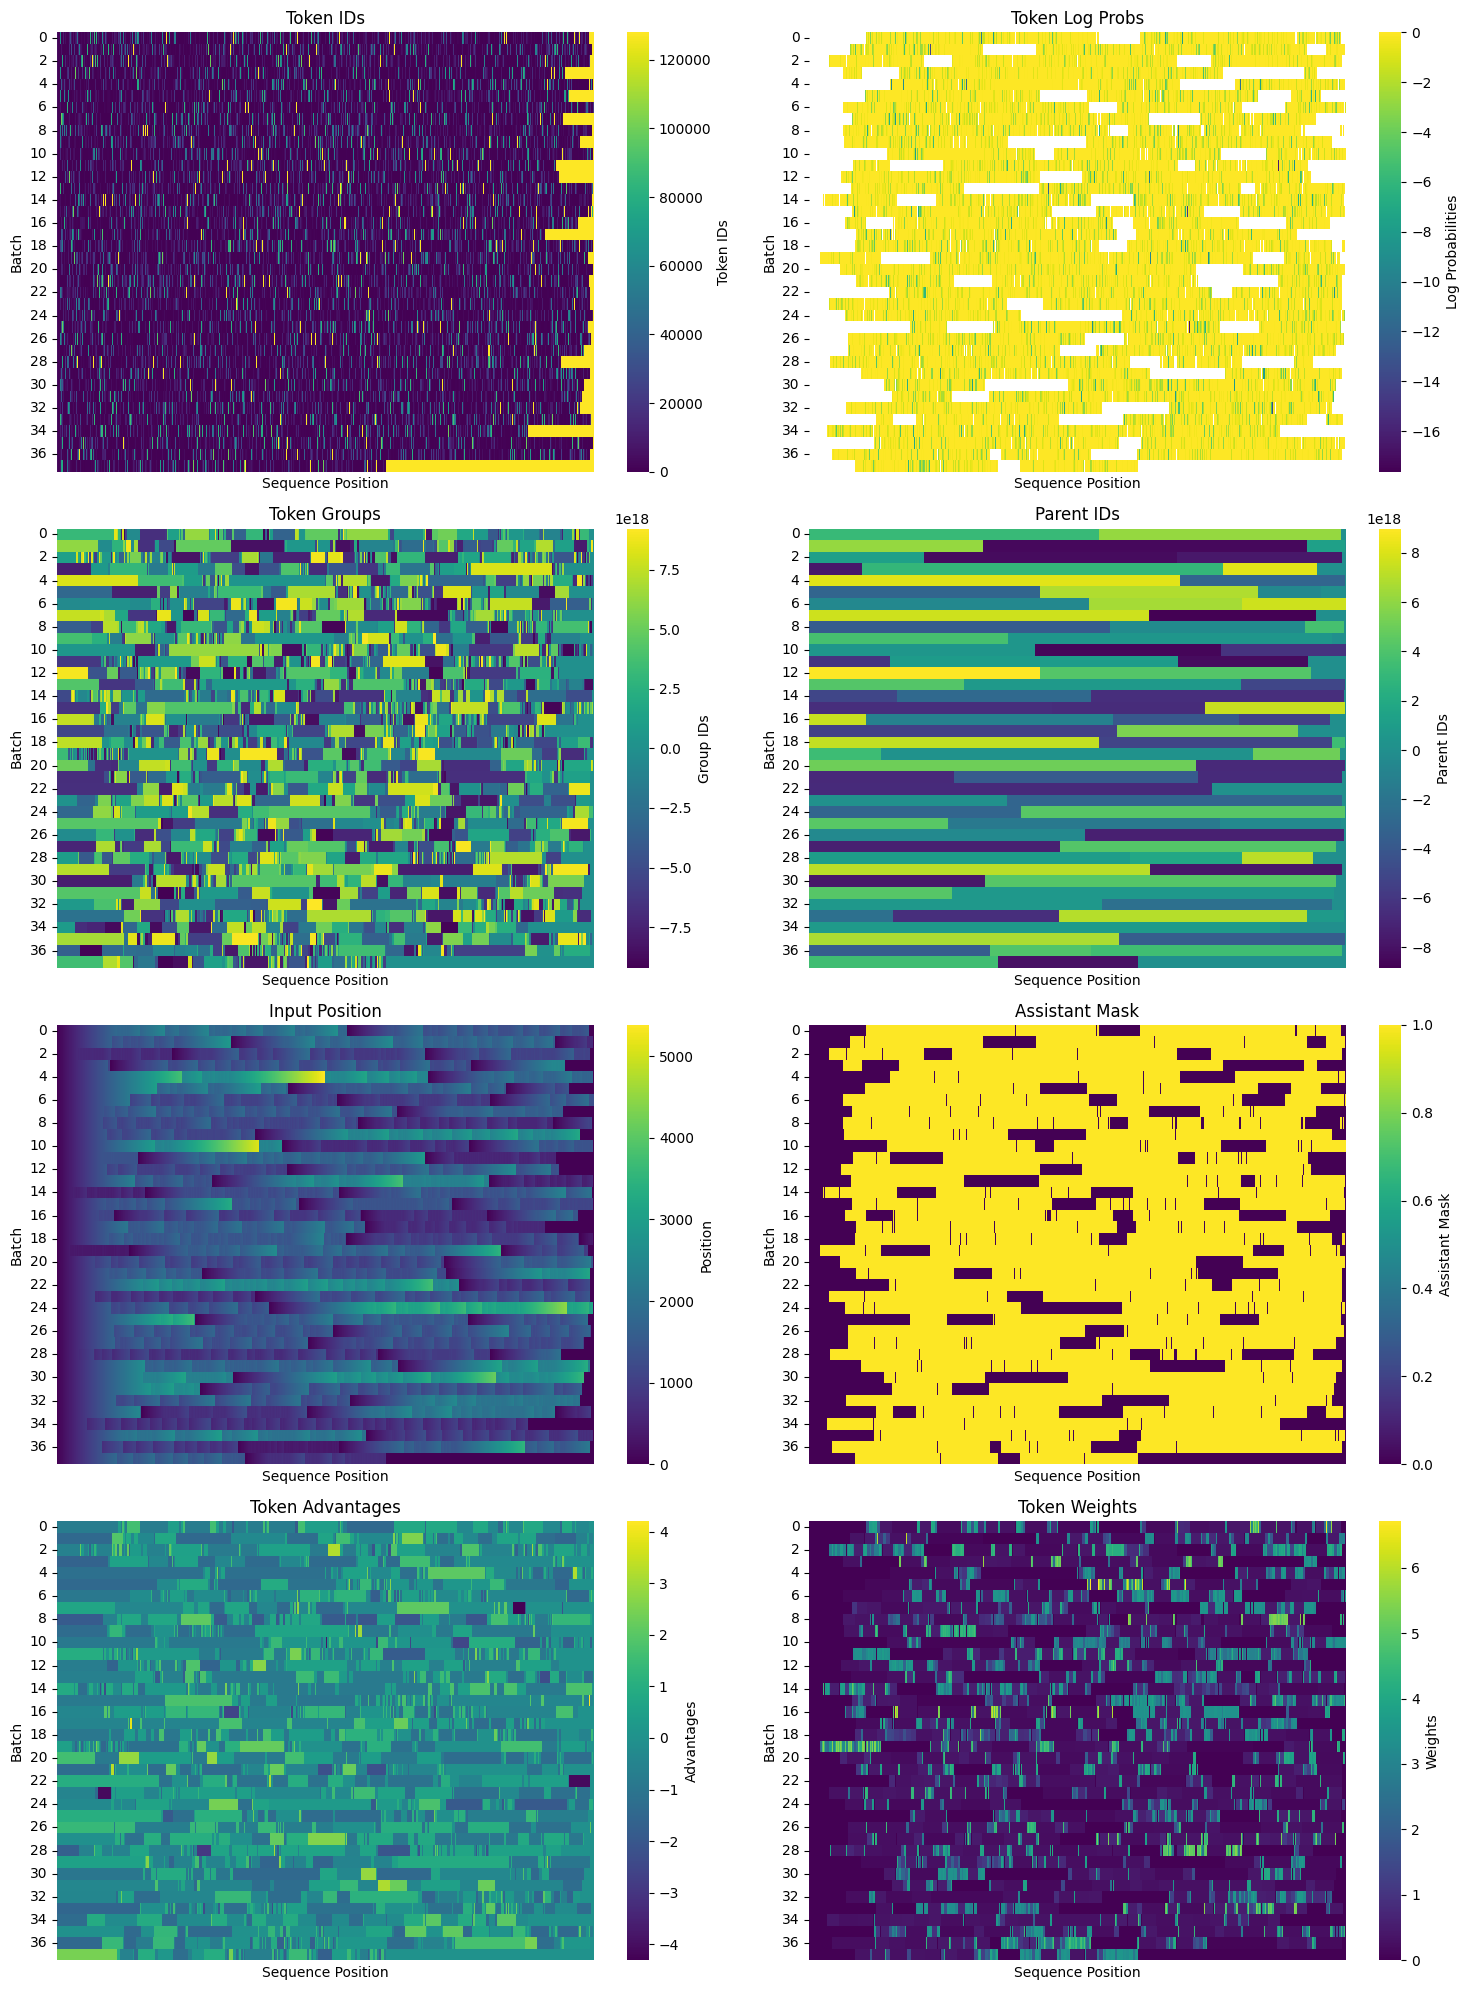

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0009
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 38
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740105746.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.71 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|19|Loss: -0.0371: 100%|██████████| 19/19 [06:00<00:00, 18.44s/it, entropy=0.489, kl_div=nan, loss=-0.0371, policy=-0.0371]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.60 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved

Saved iteration #10 model files to ./models/024/0010
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0010 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0010 --port=8000 --api-key=default
INFO 02-21 02:49:22 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 02:49:23 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 02:49:23 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0010', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.43it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.06s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.47s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.63s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.39s/it]



INFO 02-21 02:49:43 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 02:49:44 worker.py:267] Memory profiling takes 0.71 seconds
INFO 02-21 02:49:44 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 02:49:44 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 02:49:44 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 02:49:44 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 02:50:29 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 46.14 seconds
INFO 02-21 02:50:30 api_server.py:756] Using supplied chat template:
INFO 02-21 02:50:30 api_server.py:756] None
INFO 02-21 02:50:30 launcher.py:21] Available routes are:
INFO 02-21 02:50:30 launcher.py:29] Route: /

INFO:     Started server process [16029]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 02:50:36 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 02:50:36 metrics.py:455] Avg prompt throughput: 1.5 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 02:50:36 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:54094 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [03:01<00:00,  2.96it/s, completion_tokens=142, prompt_tokens=1.26e+3, reward=0.242, token_logprobs=455498]
Deleted iteration directory ./models/024/0009


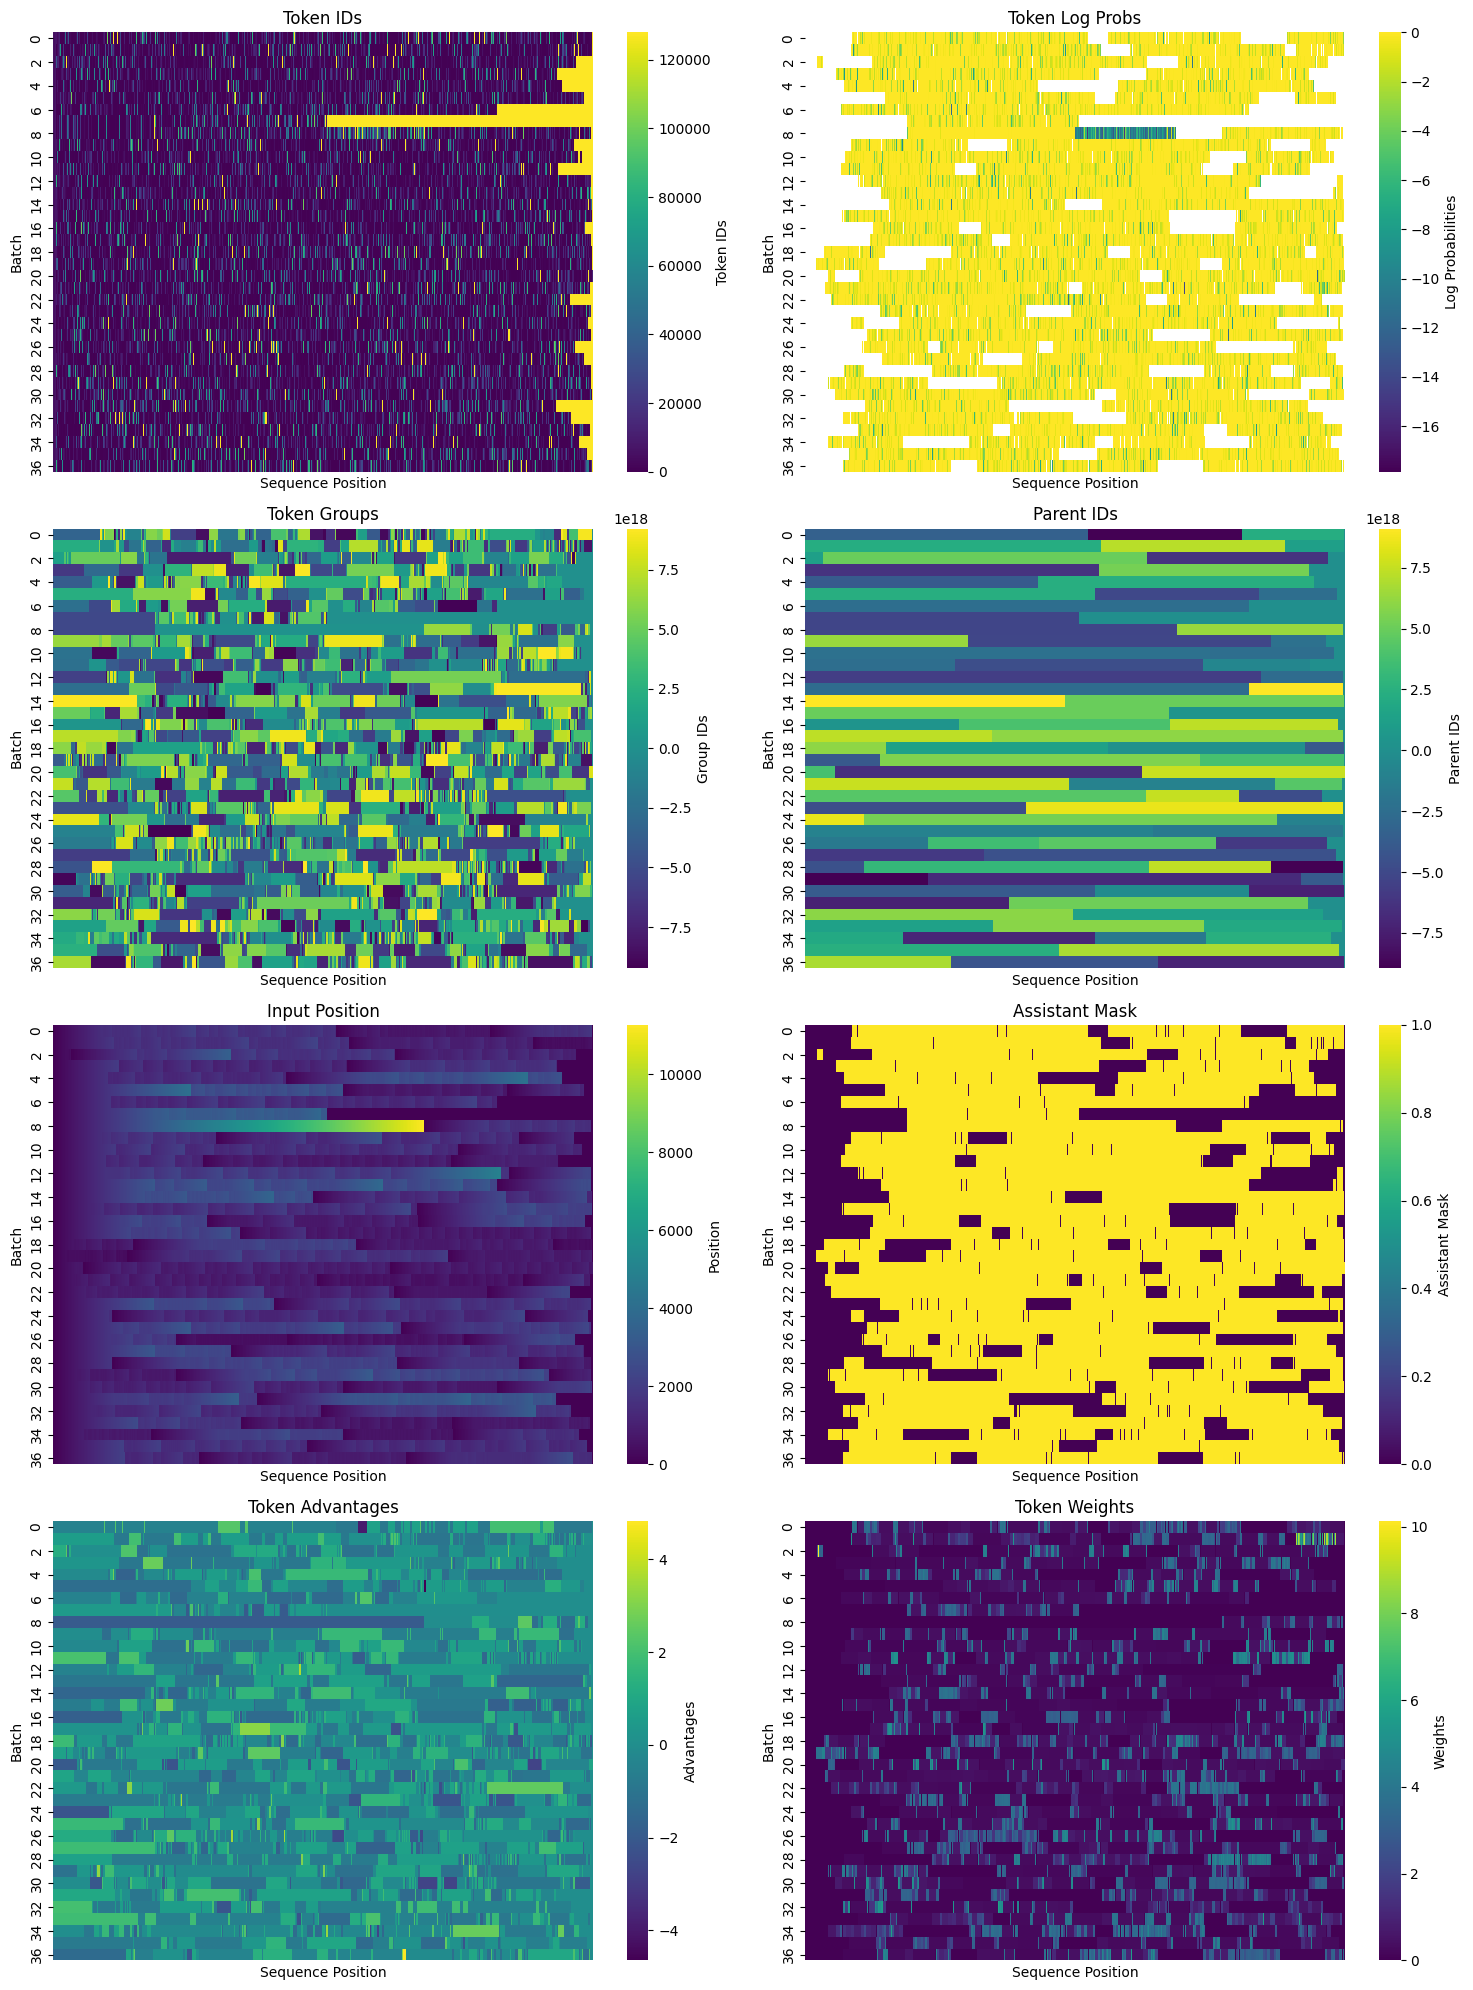

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0010
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 37
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740106444.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.72 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|18|Loss: 0.0173: 100%|██████████| 18/18 [05:42<00:00, 18.43s/it, entropy=0.533, kl_div=nan, loss=0.0173, policy=0.0173]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.67 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved to

Saved iteration #11 model files to ./models/024/0011
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0011 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0011 --port=8000 --api-key=default
INFO 02-21 03:00:41 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 03:00:42 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 03:00:42 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0011', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.41it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.08s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.53s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.67s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.42s/it]



INFO 02-21 03:01:03 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 03:01:04 worker.py:267] Memory profiling takes 0.69 seconds
INFO 02-21 03:01:04 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 03:01:04 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 03:01:04 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 03:01:04 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 03:01:49 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 46.16 seconds
INFO 02-21 03:01:50 api_server.py:756] Using supplied chat template:
INFO 02-21 03:01:50 api_server.py:756] None
INFO 02-21 03:01:50 launcher.py:21] Available routes are:
INFO 02-21 03:01:50 launcher.py:29] Route: /

INFO:     Started server process [16721]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 03:01:51 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:54028 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:10<00:00, 100.77it/s, completion_tokens=124, prompt_tokens=1.27e+3, reward=0.26, token_logprobs=396856]
Deleted iteration directory ./models/024/0010


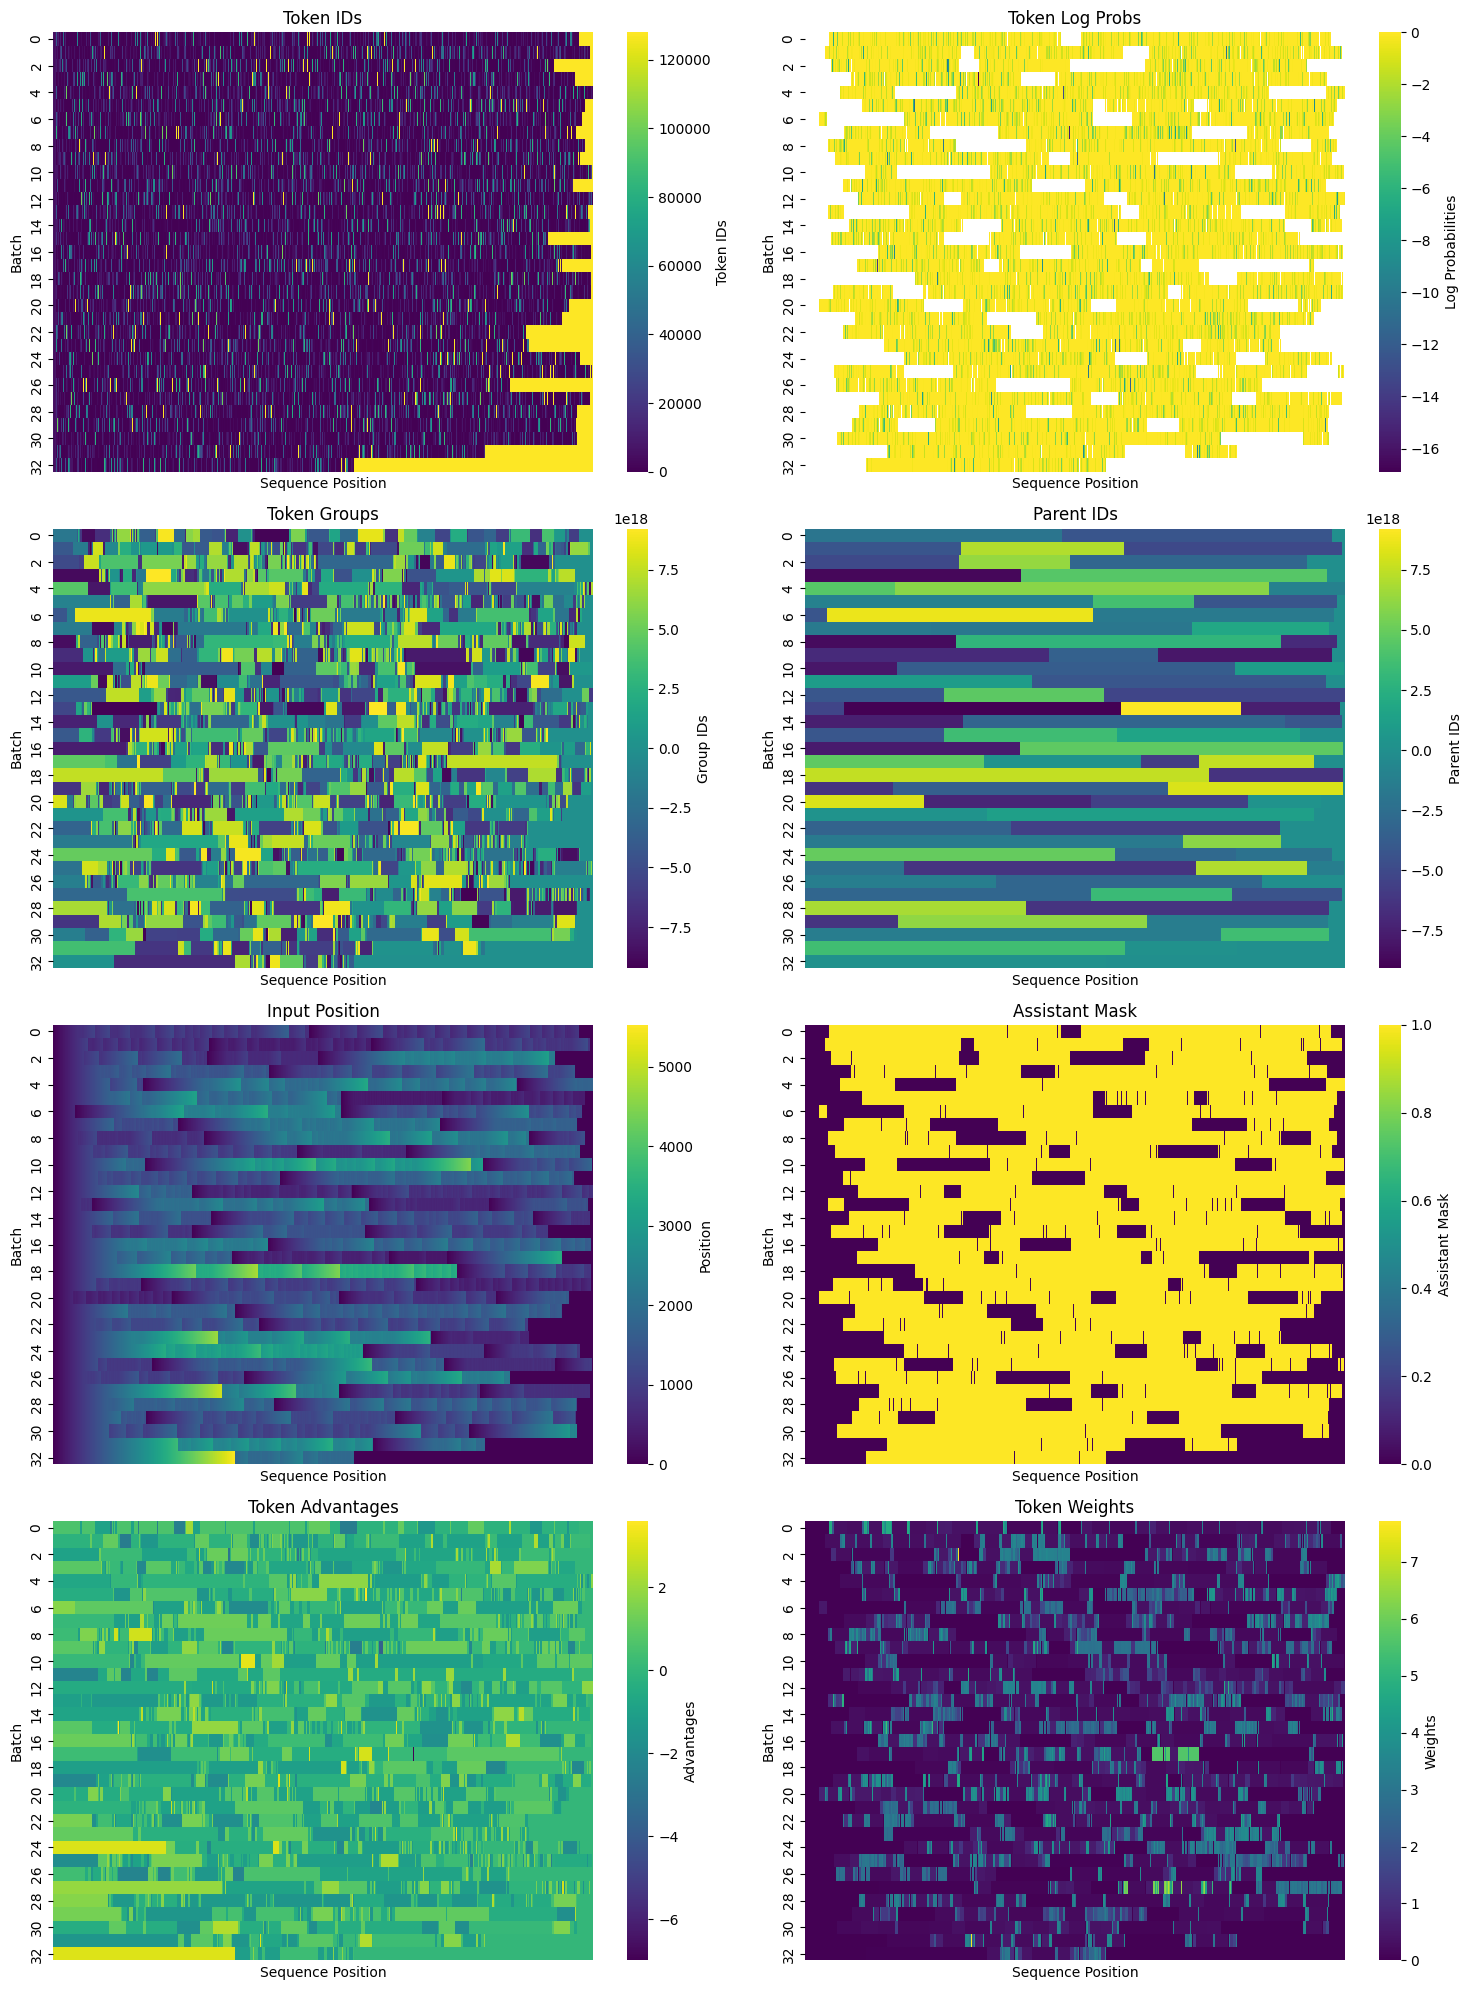

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0011
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 33
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740107069.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.66 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|16|Loss: 0.0314: 100%|██████████| 16/16 [05:05<00:00, 18.43s/it, entropy=0.379, kl_div=nan, loss=0.0314, policy=0.0314]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.58 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved to

Saved iteration #12 model files to ./models/024/0012
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0012 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0012 --port=8000 --api-key=default
INFO 02-21 03:10:29 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 03:10:30 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 03:10:30 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0012', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.44it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.07s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.49s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.65s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.40s/it]



INFO 02-21 03:10:50 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 03:10:51 worker.py:267] Memory profiling takes 0.77 seconds
INFO 02-21 03:10:51 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 03:10:51 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 03:10:51 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 03:10:51 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 03:11:36 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 46.00 seconds
INFO 02-21 03:11:37 api_server.py:756] Using supplied chat template:
INFO 02-21 03:11:37 api_server.py:756] None
INFO 02-21 03:11:37 launcher.py:21] Available routes are:
INFO 02-21 03:11:37 launcher.py:29] Route: /

INFO:     Started server process [17455]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 03:11:42 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 03:11:42 metrics.py:455] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 03:11:42 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:52134 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:04<00:00, 28.32it/s, completion_tokens=104, prompt_tokens=1.28e+3, reward=0.263, token_logprobs=332745]
Deleted iteration directory ./models/024/0011


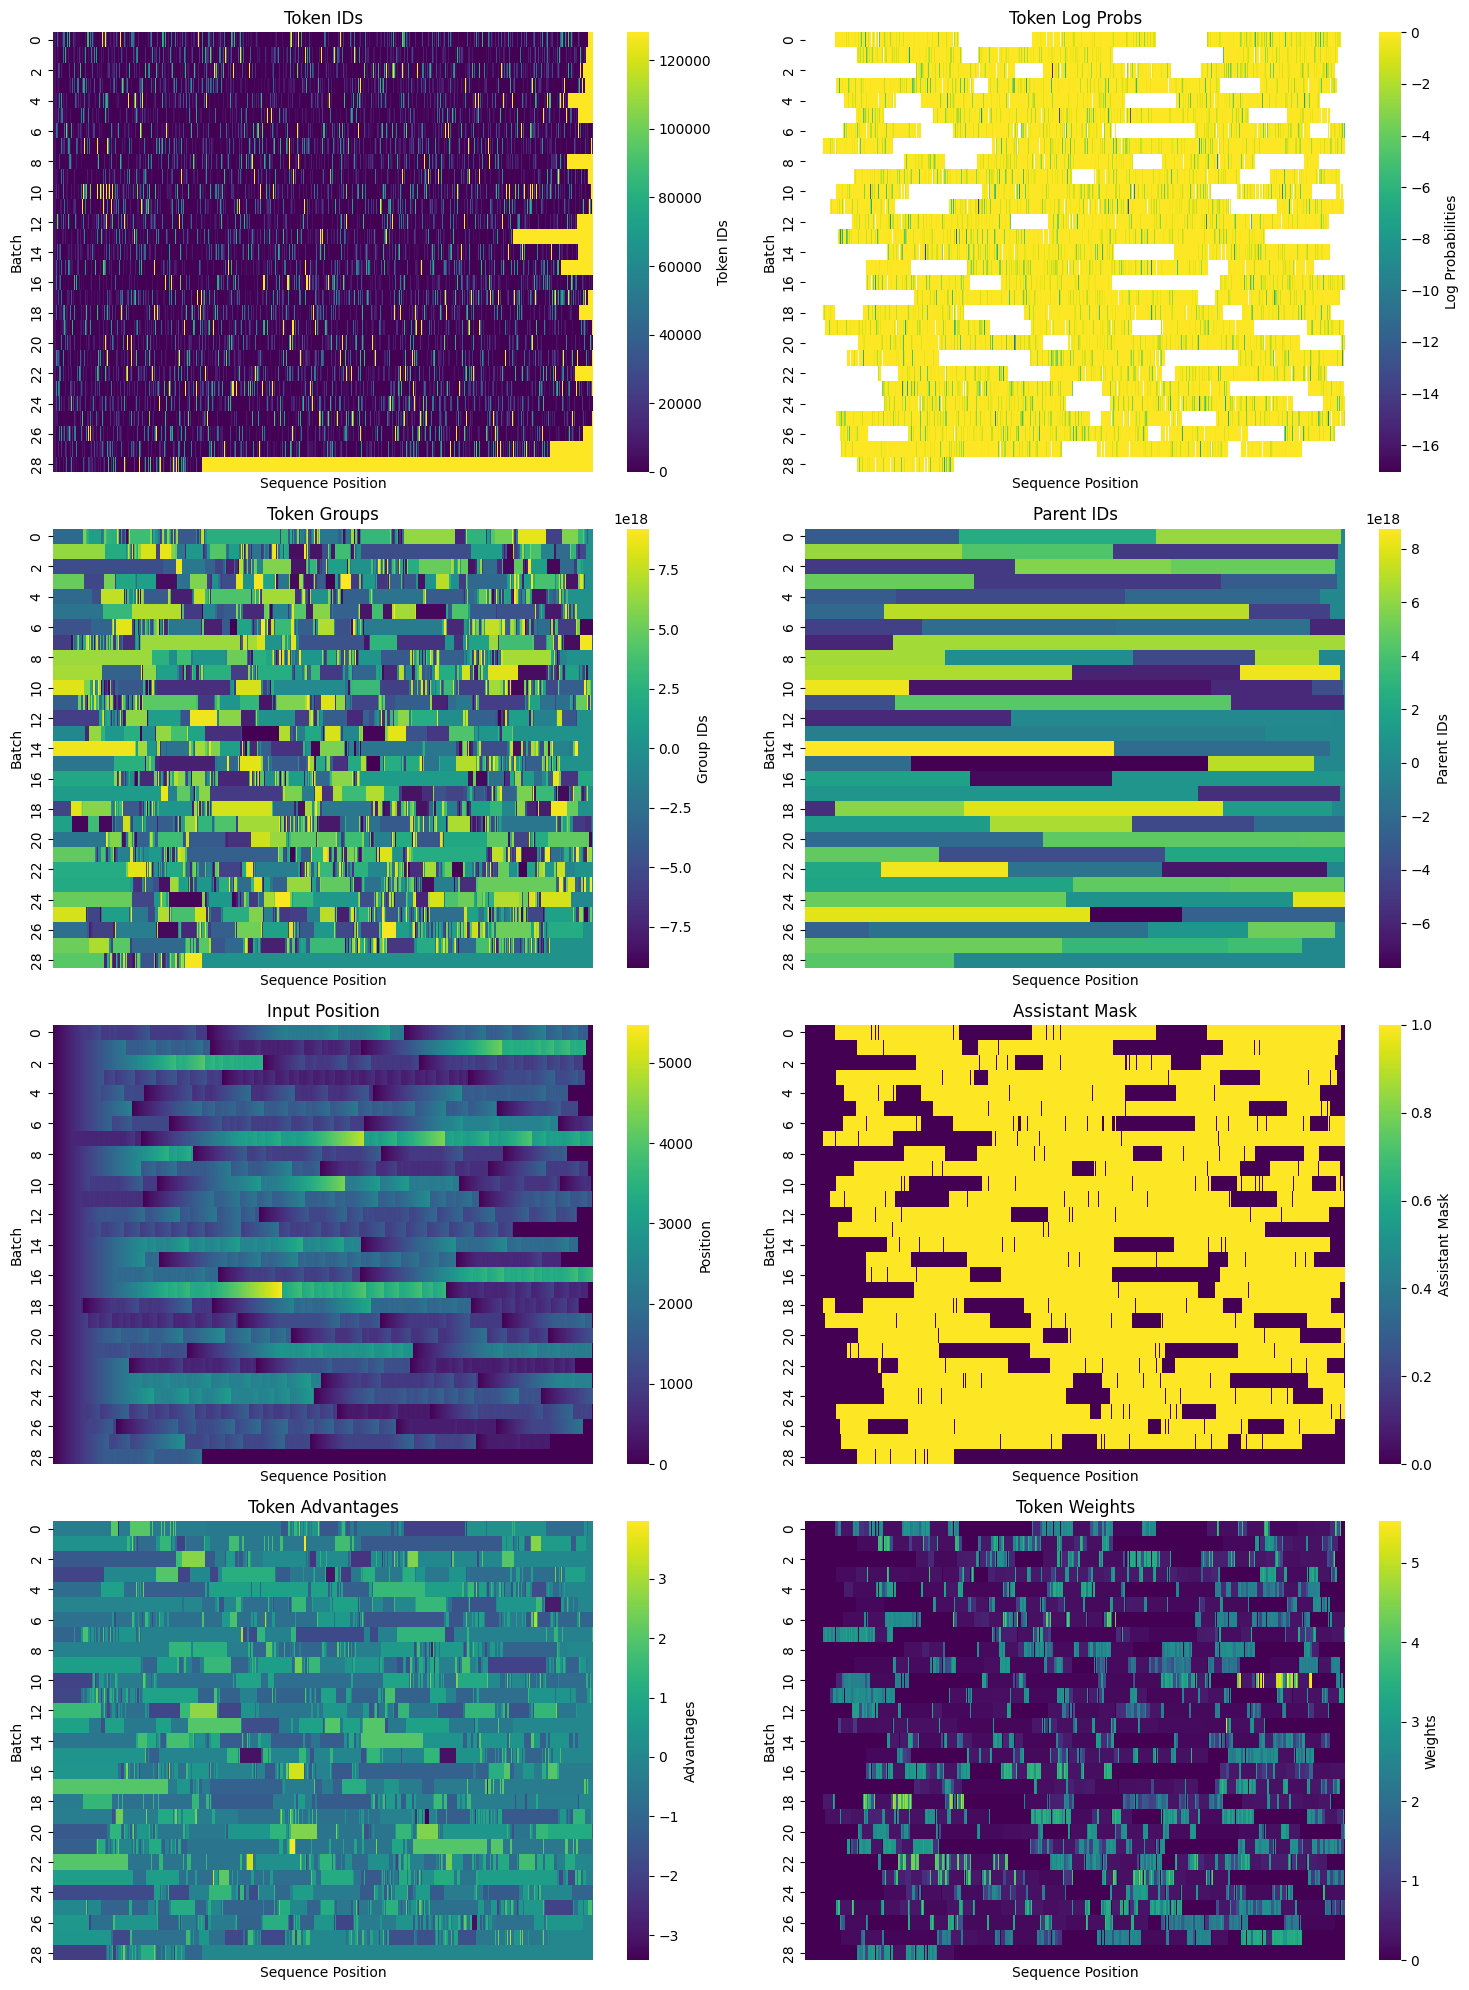

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0012
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 29
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740107651.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.89 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|14|Loss: 0.0542: 100%|██████████| 14/14 [04:28<00:00, 18.47s/it, entropy=0.532, kl_div=nan, loss=0.0542, policy=0.0542]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.68 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved 

Saved iteration #13 model files to ./models/024/0013
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0013 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0013 --port=8000 --api-key=default
INFO 02-21 03:19:34 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 03:19:35 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 03:19:35 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0013', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.38it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.07s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.51s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.68s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.43s/it]



INFO 02-21 03:19:56 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 03:19:56 worker.py:267] Memory profiling takes 0.70 seconds
INFO 02-21 03:19:56 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 03:19:56 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 03:19:57 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 03:19:57 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 03:20:42 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 45.90 seconds
INFO 02-21 03:20:43 api_server.py:756] Using supplied chat template:
INFO 02-21 03:20:43 api_server.py:756] None
INFO 02-21 03:20:43 launcher.py:21] Available routes are:
INFO 02-21 03:20:43 launcher.py:29] Route: /

INFO:     Started server process [18157]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 03:20:48 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 03:20:48 metrics.py:455] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 03:20:48 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:54496 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:53<00:00,  1.18it/s, completion_tokens=100, prompt_tokens=1.13e+3, reward=0.256, token_logprobs=320189]
Deleted iteration directory ./models/024/0012


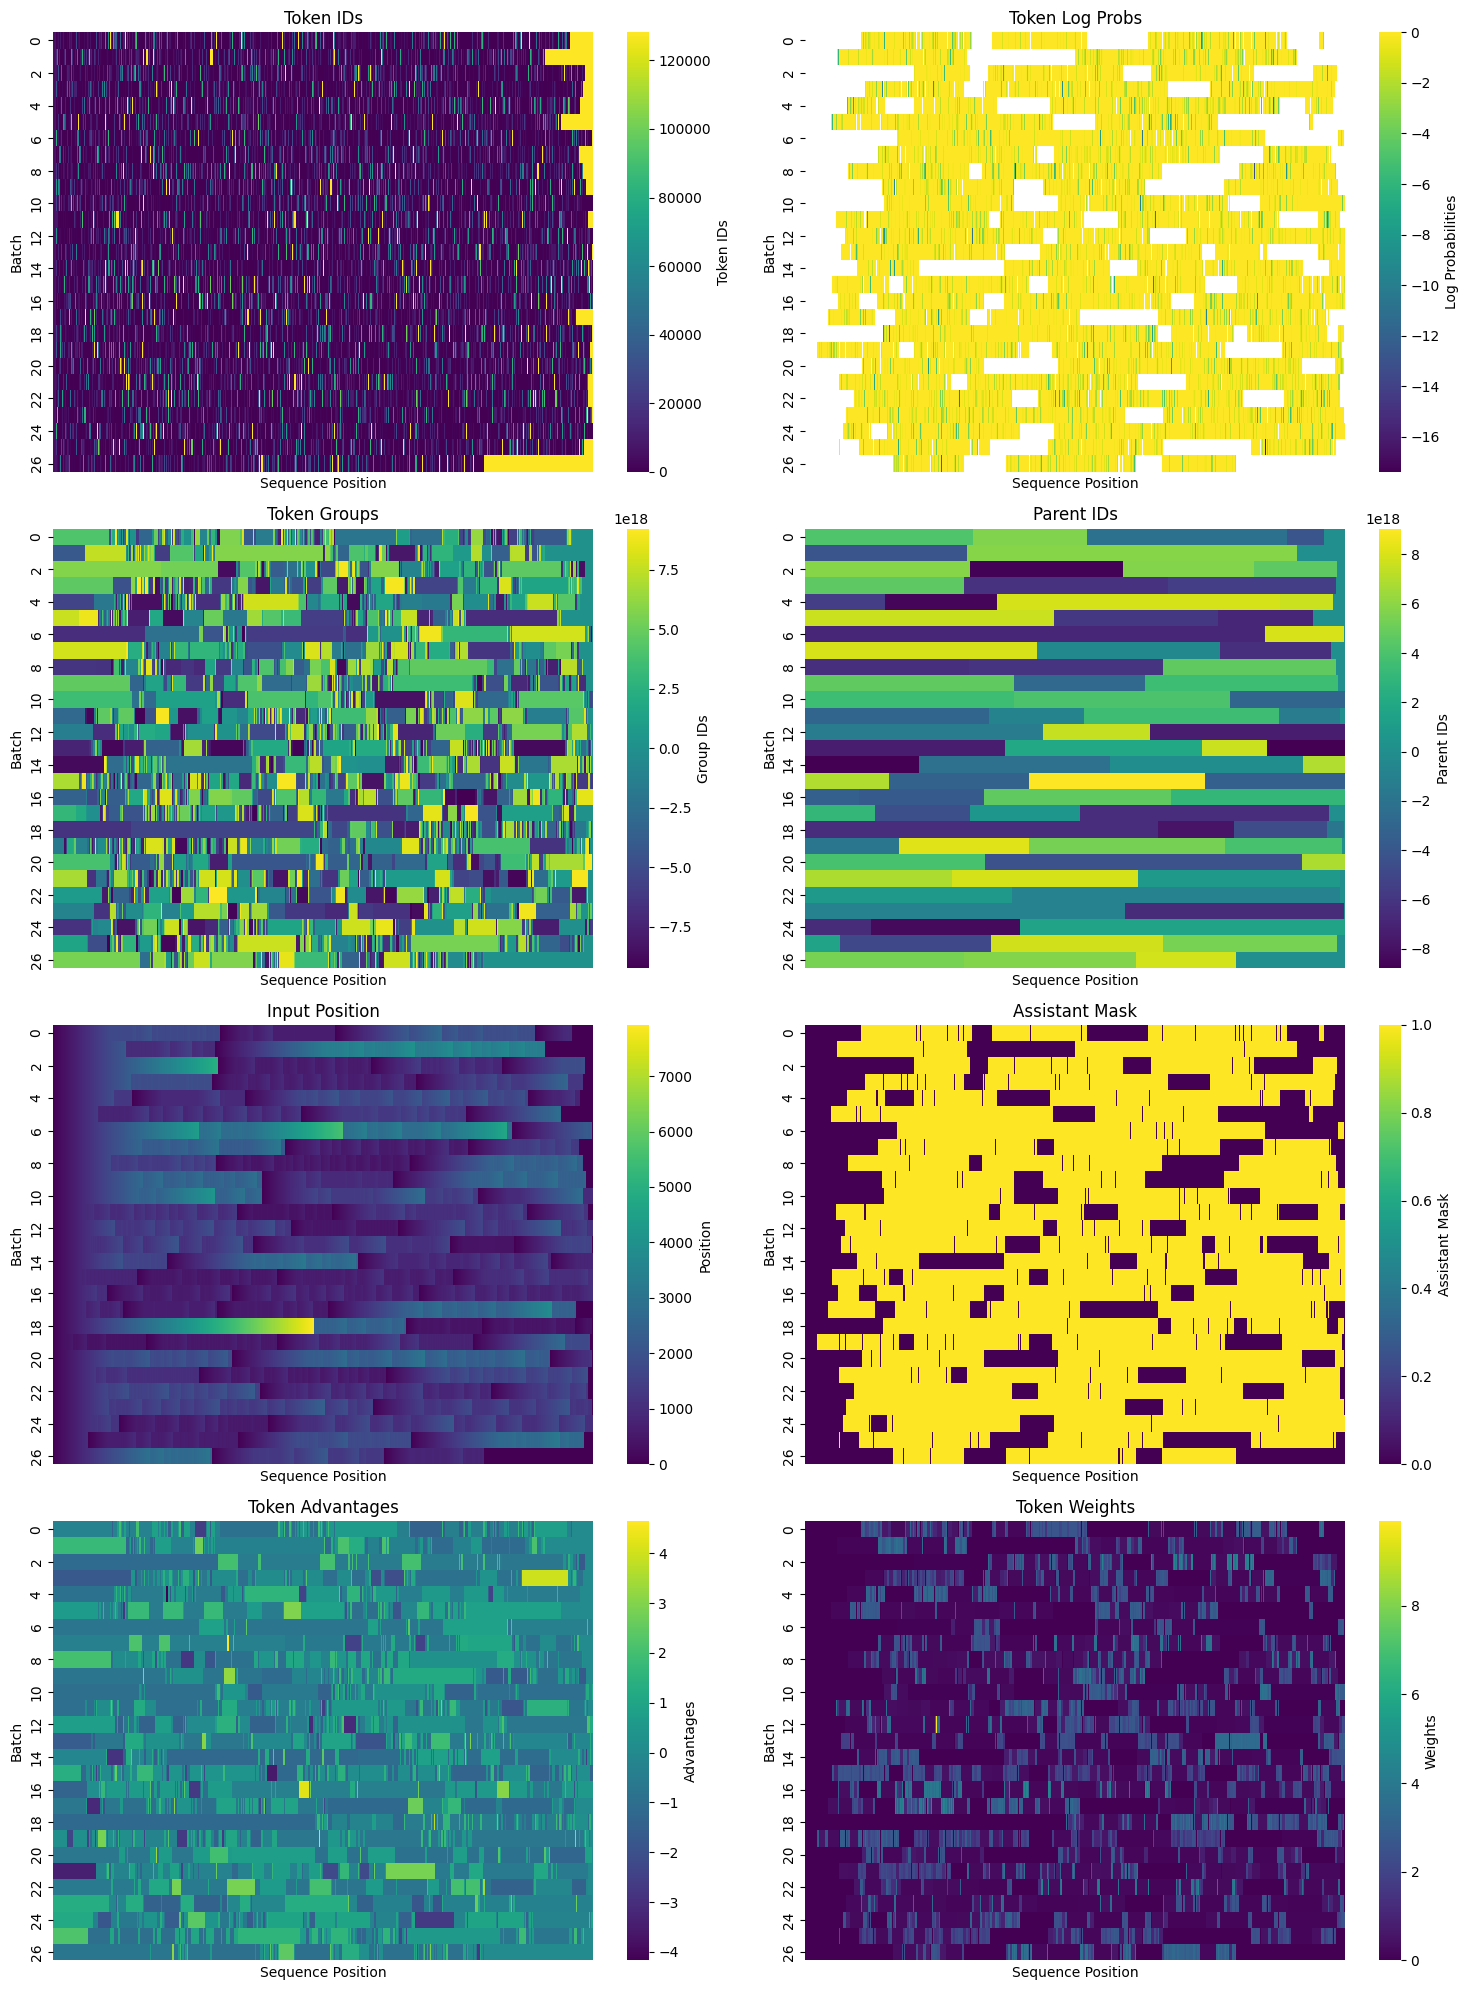

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0013
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 27
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740108246.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.63 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|13|Loss: -0.0164: 100%|██████████| 13/13 [04:10<00:00, 18.50s/it, entropy=0.31, kl_div=nan, loss=-0.0164, policy=-0.0164] INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.49 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved

Saved iteration #14 model files to ./models/024/0014
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0014 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0014 --port=8000 --api-key=default
INFO 02-21 03:29:11 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 03:29:12 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 03:29:12 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0014', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.36it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.15s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.54s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.68s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.44s/it]



INFO 02-21 03:29:32 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 03:29:33 worker.py:267] Memory profiling takes 0.70 seconds
INFO 02-21 03:29:33 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 03:29:33 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 03:29:33 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 03:29:33 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 03:30:18 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 45.92 seconds
INFO 02-21 03:30:19 api_server.py:756] Using supplied chat template:
INFO 02-21 03:30:19 api_server.py:756] None
INFO 02-21 03:30:19 launcher.py:21] Available routes are:
INFO 02-21 03:30:19 launcher.py:29] Route: /

INFO:     Started server process [18923]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 03:30:24 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:42828 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:51<00:00, 50.19it/s, completion_tokens=103, prompt_tokens=1.22e+3, reward=0.244, token_logprobs=329732]
Deleted iteration directory ./models/024/0013


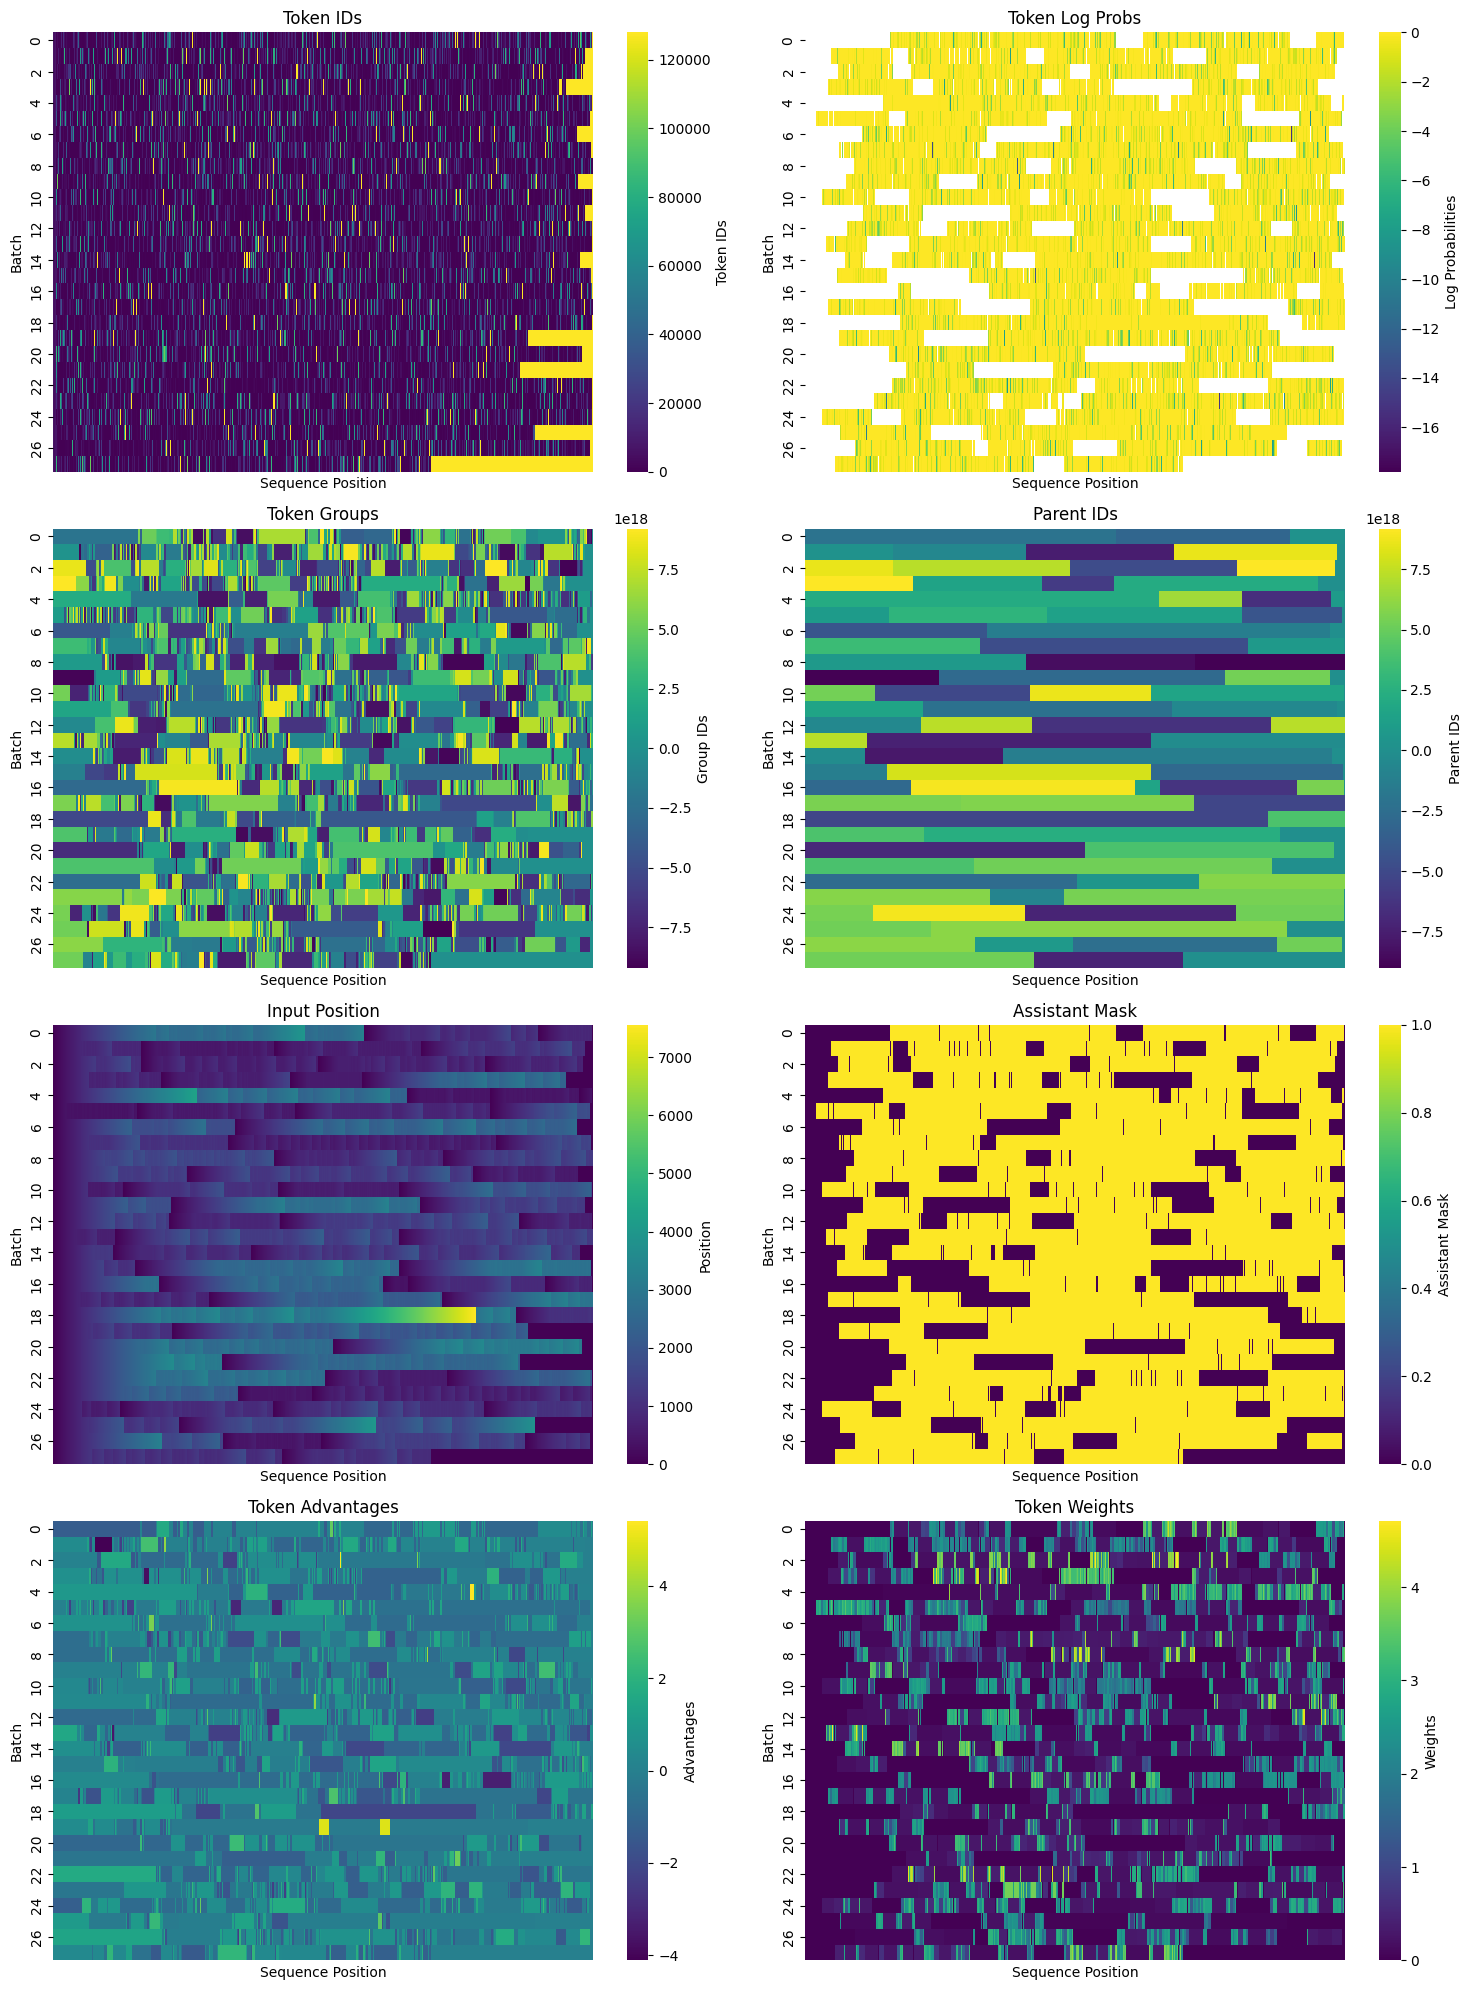

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0014
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 28
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740108820.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.54 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|14|Loss: 0.0380: 100%|██████████| 14/14 [04:28<00:00, 18.48s/it, entropy=0.441, kl_div=nan, loss=0.038, policy=0.038]    INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.50 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved 

Saved iteration #15 model files to ./models/024/0015
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0015 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0015 --port=8000 --api-key=default
INFO 02-21 03:39:03 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 03:39:04 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 03:39:04 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0015', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.40it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.09s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.55s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.68s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.44s/it]



INFO 02-21 03:39:24 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 03:39:25 worker.py:267] Memory profiling takes 0.71 seconds
INFO 02-21 03:39:25 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 03:39:25 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 03:39:25 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 03:39:25 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 03:40:11 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 46.46 seconds
INFO 02-21 03:40:12 api_server.py:756] Using supplied chat template:
INFO 02-21 03:40:12 api_server.py:756] None
INFO 02-21 03:40:12 launcher.py:21] Available routes are:
INFO 02-21 03:40:12 launcher.py:29] Route: /

INFO:     Started server process [19767]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 03:40:13 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:36380 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:15<00:00, 67.48it/s, completion_tokens=104, prompt_tokens=1.34e+3, reward=0.247, token_logprobs=331814]
Deleted iteration directory ./models/024/0014


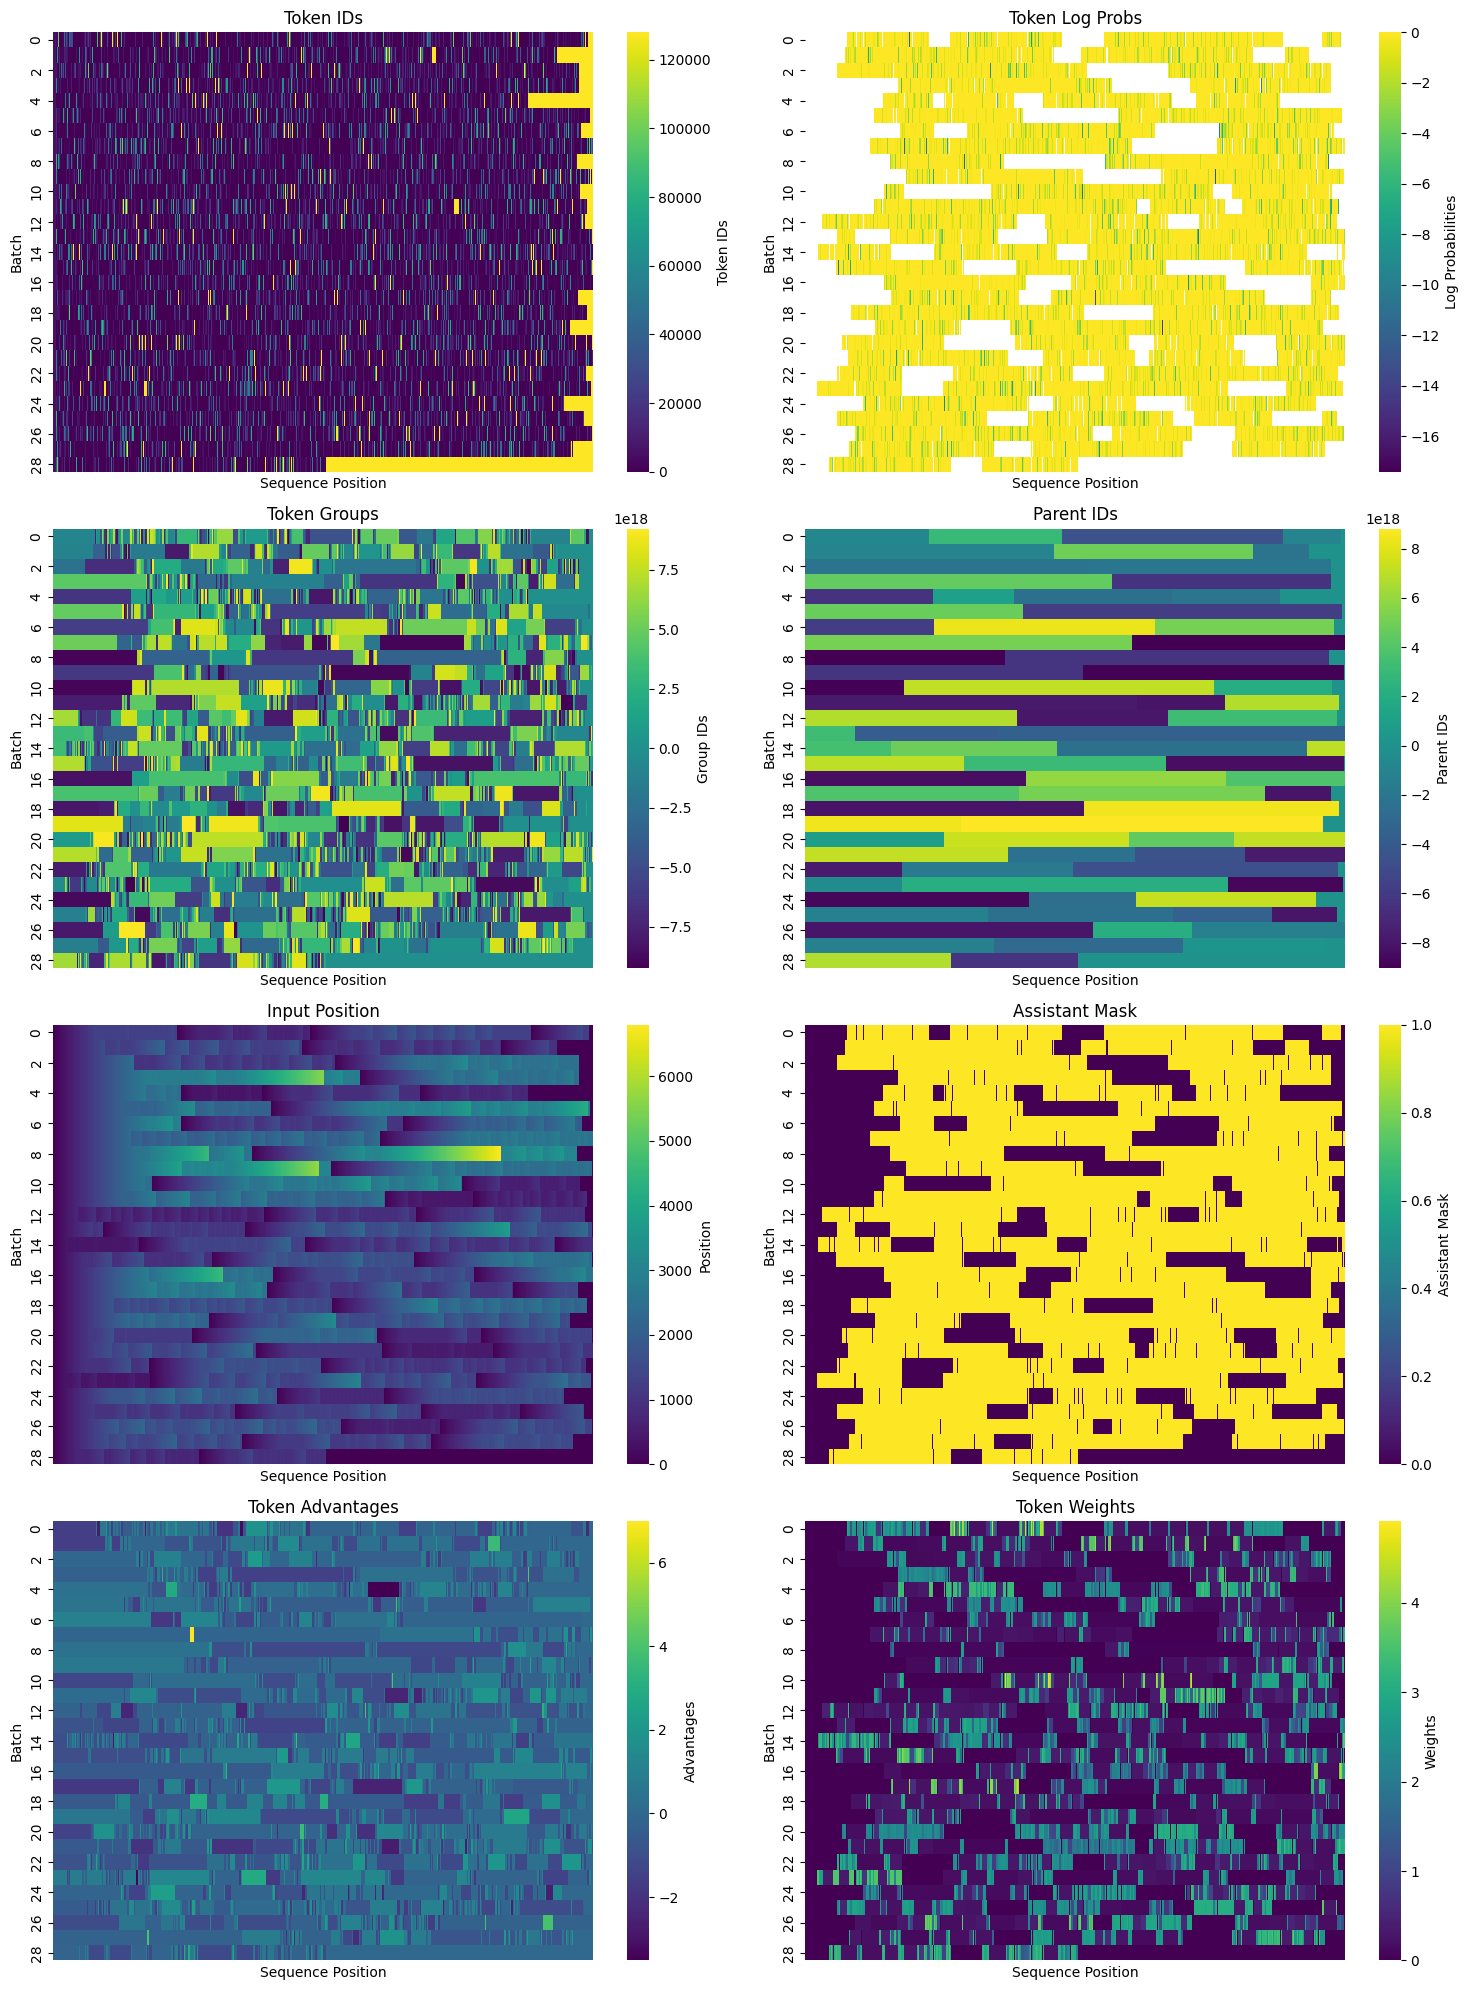

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0015
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 29
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740109373.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.67 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|14|Loss: 0.0044: 100%|██████████| 14/14 [04:30<00:00, 18.57s/it, entropy=0.441, kl_div=nan, loss=0.00445, policy=0.00445]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.59 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved 

Saved iteration #16 model files to ./models/024/0016
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0016 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0016 --port=8000 --api-key=default
INFO 02-21 03:48:18 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 03:48:19 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 03:48:19 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0016', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.35it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.10s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.56s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.70s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.46s/it]



INFO 02-21 03:48:40 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 03:48:40 worker.py:267] Memory profiling takes 0.76 seconds
INFO 02-21 03:48:40 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 03:48:40 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 03:48:41 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 03:48:41 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 03:49:26 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 45.99 seconds
INFO 02-21 03:49:27 api_server.py:756] Using supplied chat template:
INFO 02-21 03:49:27 api_server.py:756] None
INFO 02-21 03:49:27 launcher.py:21] Available routes are:
INFO 02-21 03:49:27 launcher.py:29] Route: /

INFO:     Started server process [20615]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 03:49:31 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:60706 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:00<00:00, 40.51it/s, completion_tokens=94, prompt_tokens=1.17e+3, reward=0.247, token_logprobs=3e+5]
Deleted iteration directory ./models/024/0015


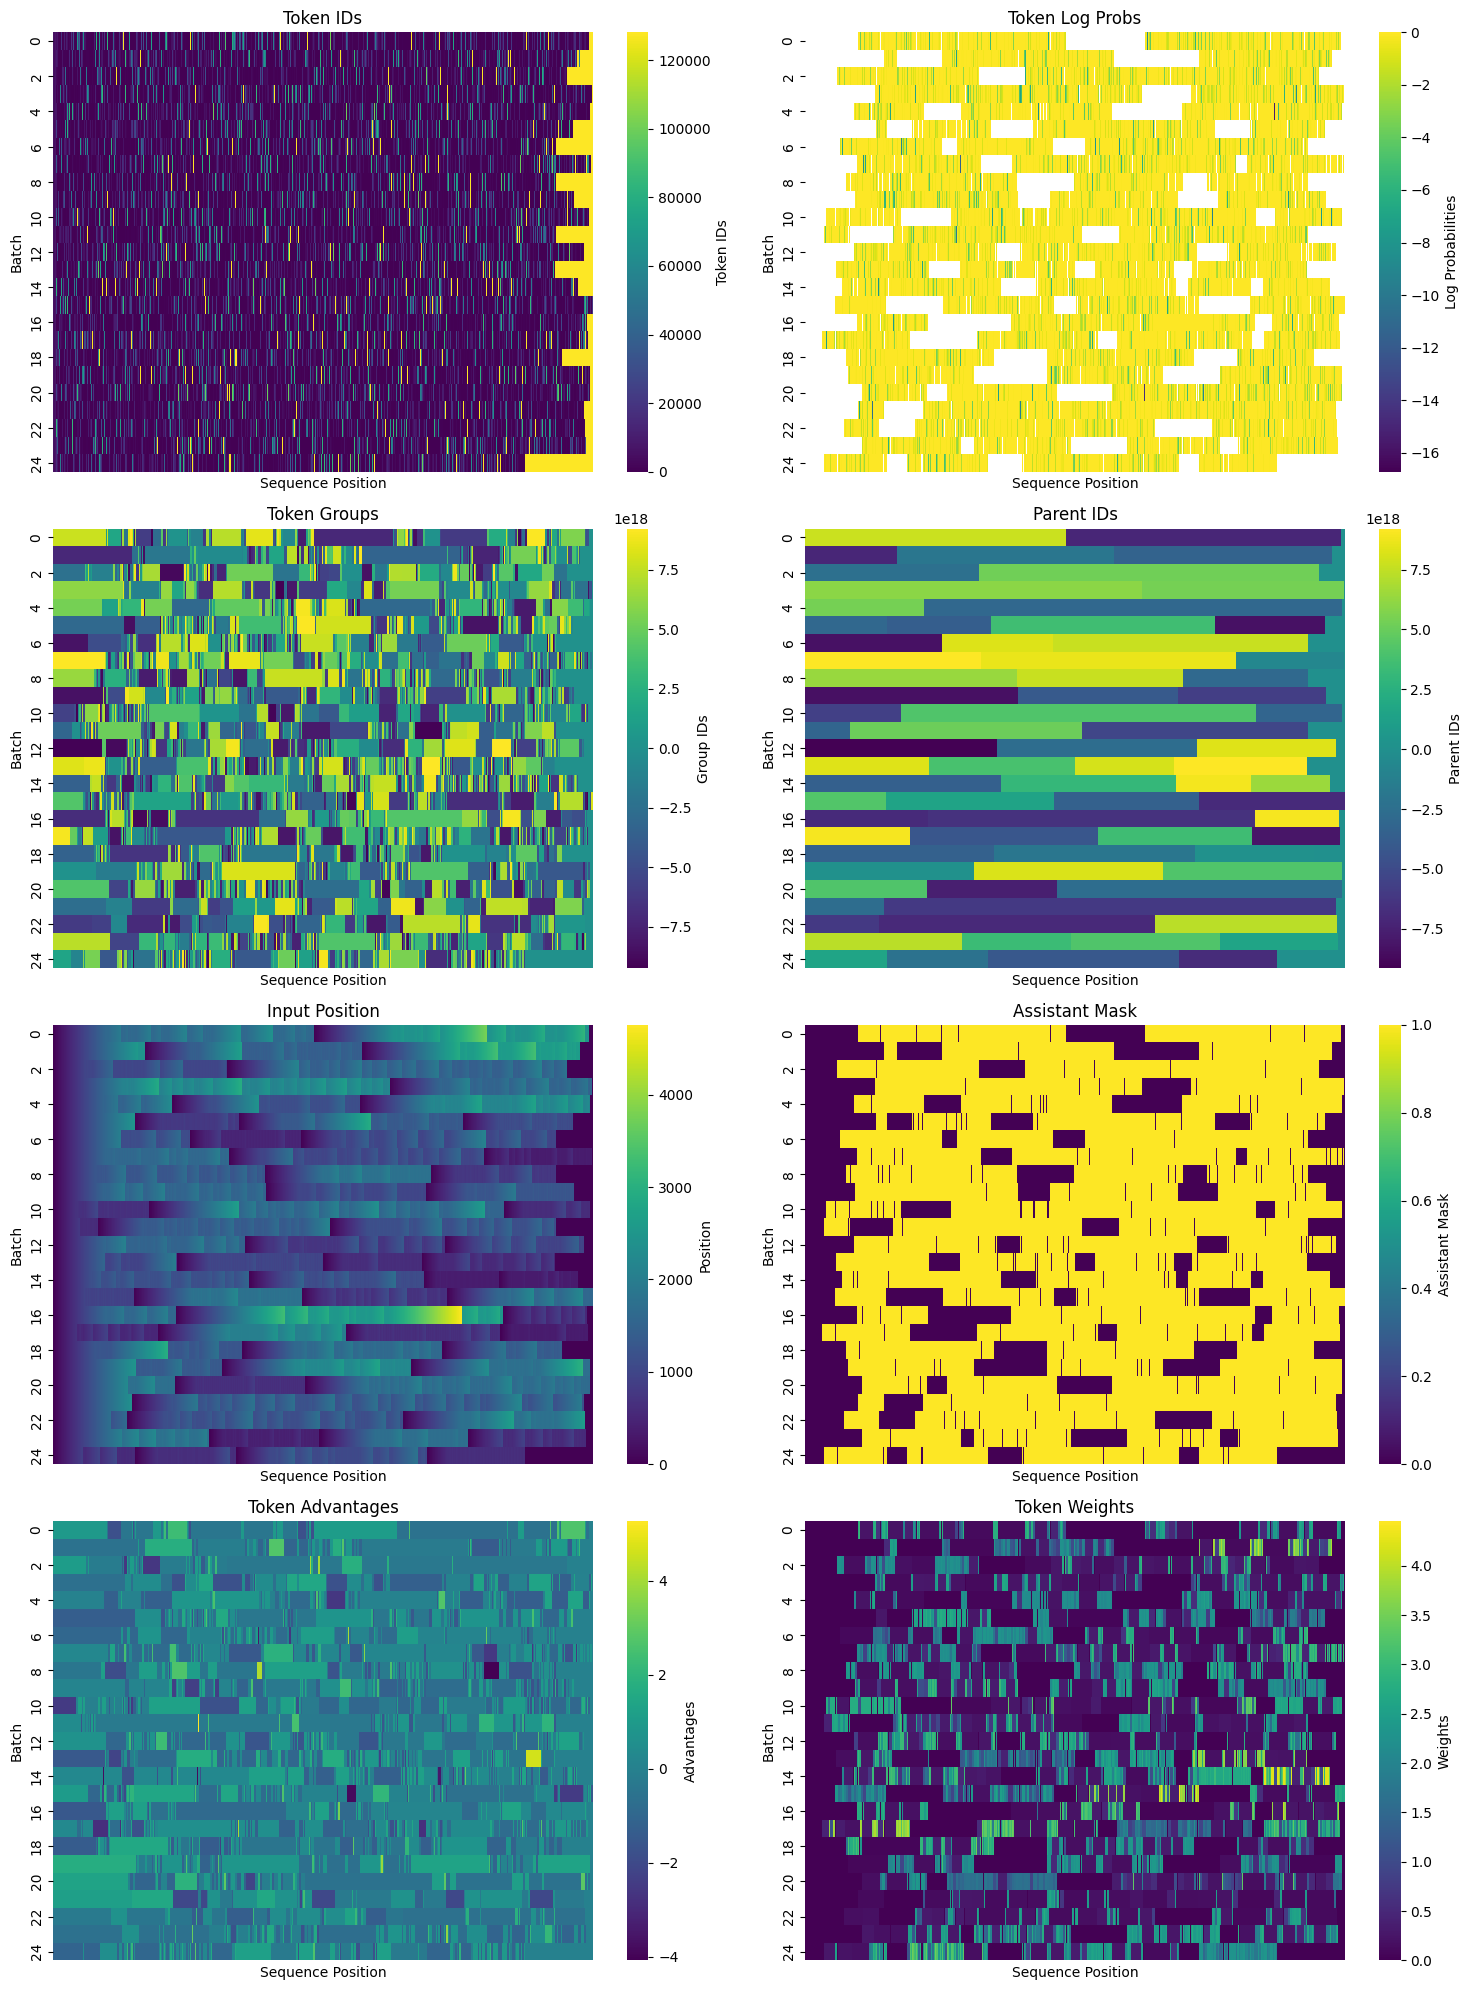

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0016
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 25
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740109916.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.70 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|12|Loss: 0.0383: 100%|██████████| 12/12 [03:52<00:00, 18.56s/it, entropy=0.383, kl_div=nan, loss=0.0383, policy=0.0383]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.53 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved to

Saved iteration #17 model files to ./models/024/0017
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0017 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0017 --port=8000 --api-key=default
INFO 02-21 03:56:43 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 03:56:44 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 03:56:44 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0017', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.41it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.06s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.51s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.67s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.42s/it]



INFO 02-21 03:57:04 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 03:57:05 worker.py:267] Memory profiling takes 0.69 seconds
INFO 02-21 03:57:05 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 03:57:05 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 03:57:05 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 03:57:05 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 03:57:50 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 46.12 seconds
INFO 02-21 03:57:51 api_server.py:756] Using supplied chat template:
INFO 02-21 03:57:51 api_server.py:756] None
INFO 02-21 03:57:51 launcher.py:21] Available routes are:
INFO 02-21 03:57:51 launcher.py:29] Route: /

INFO:     Started server process [21308]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 03:57:55 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:46038 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:34<00:00, 349.52it/s, completion_tokens=90, prompt_tokens=1.24e+3, reward=0.242, token_logprobs=288790]
Deleted iteration directory ./models/024/0016


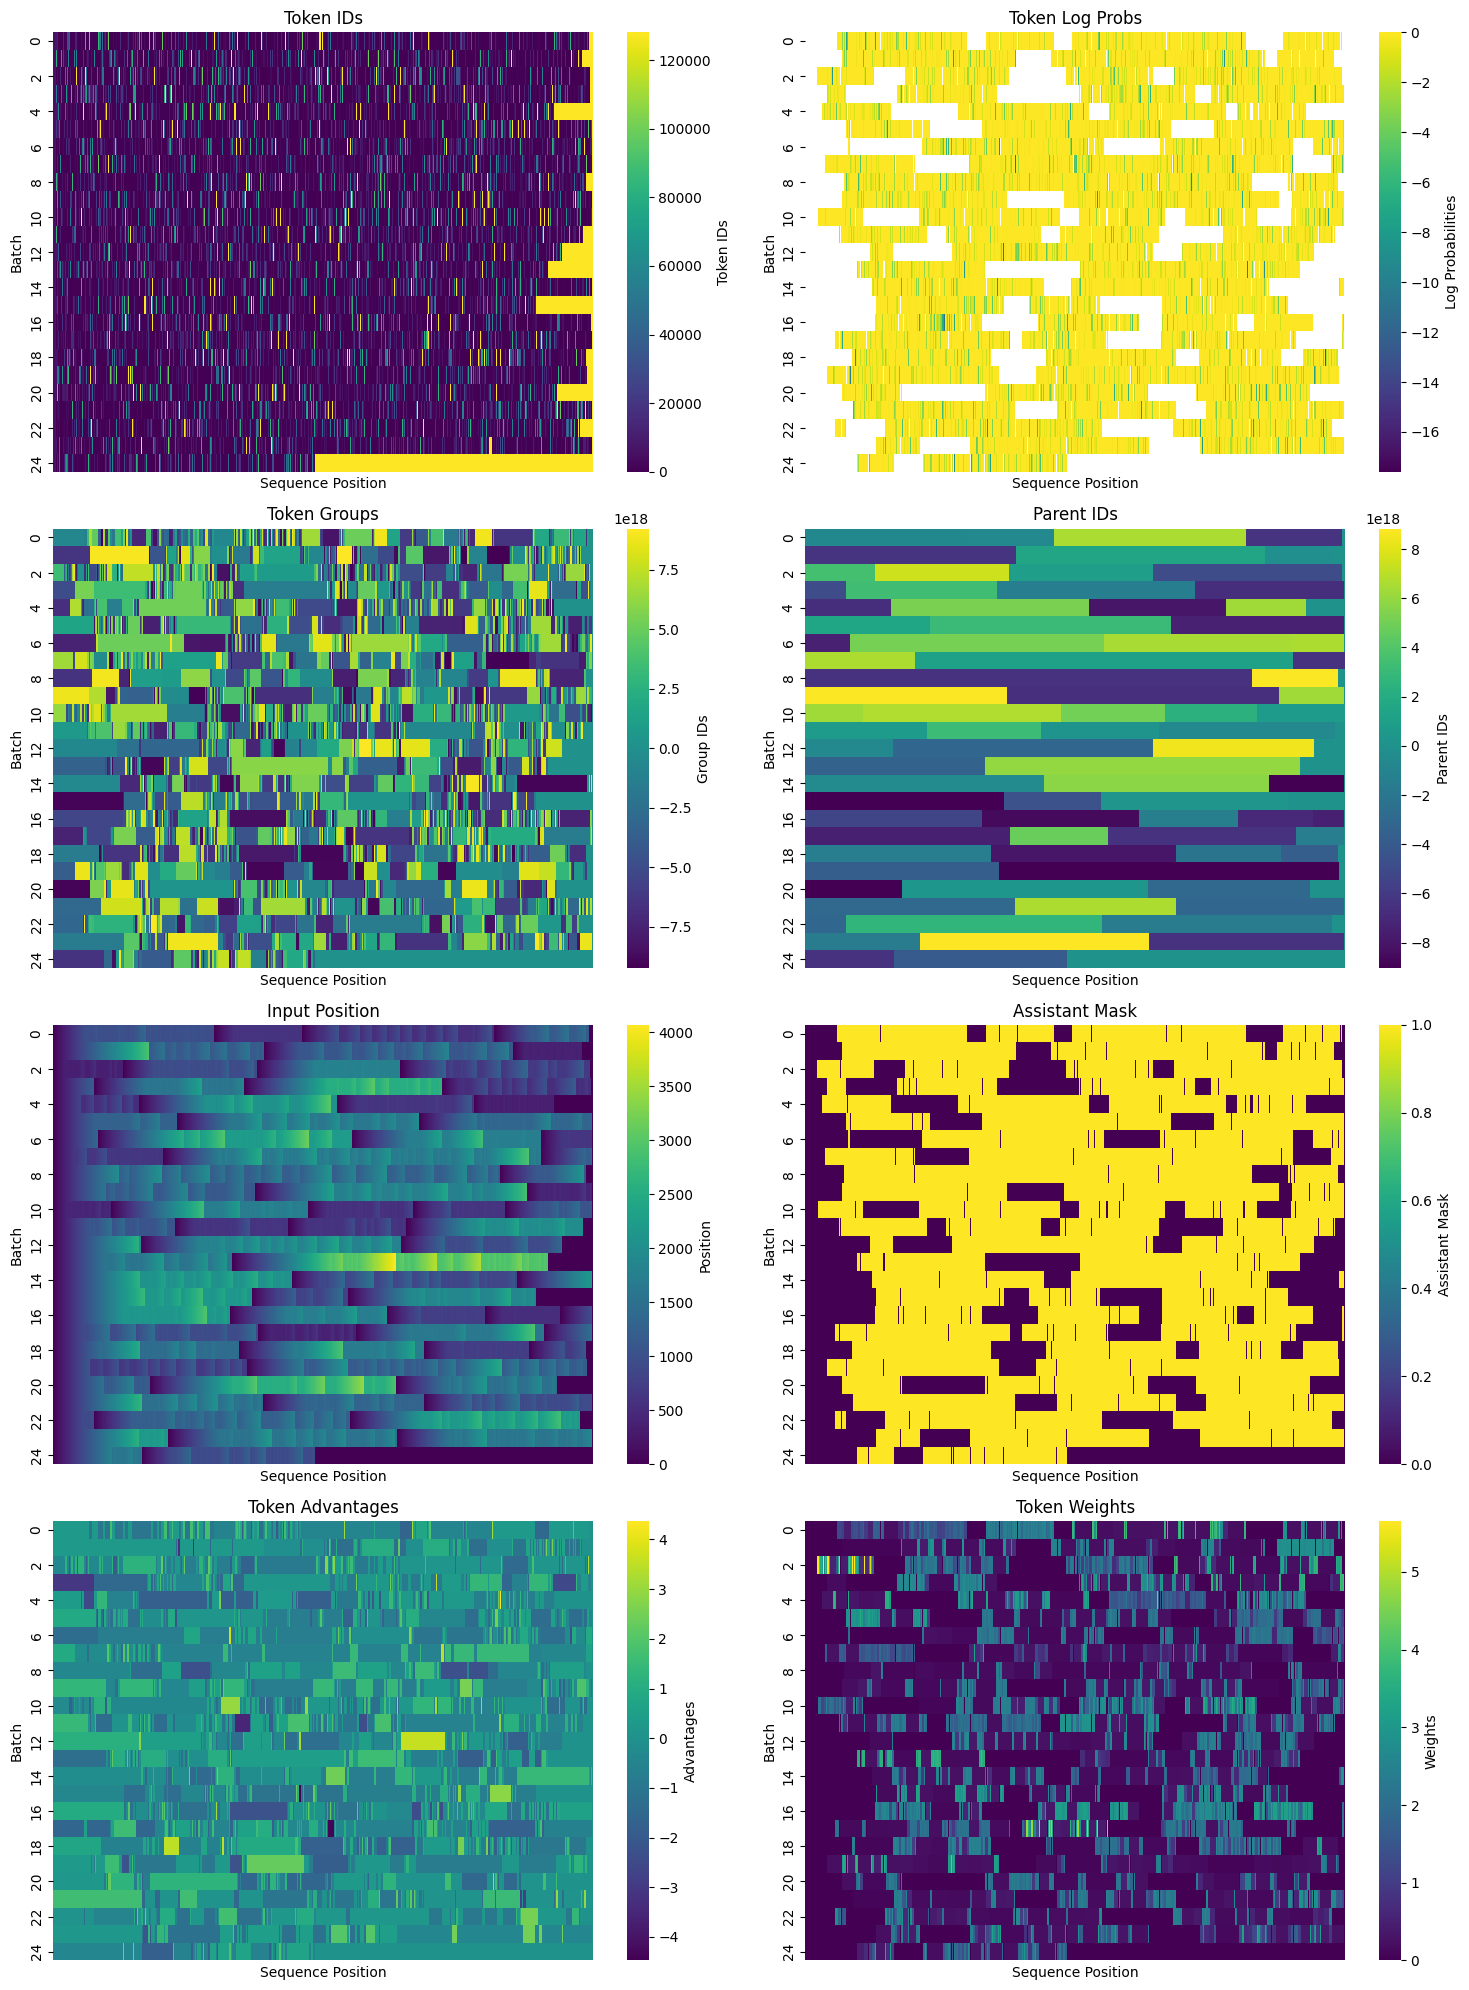

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0017
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 25
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740110453.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.70 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|12|Loss: 0.0151: 100%|██████████| 12/12 [03:51<00:00, 18.52s/it, entropy=0.343, kl_div=nan, loss=0.0151, policy=0.0151]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.48 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved to

Saved iteration #18 model files to ./models/024/0018
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0018 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0018 --port=8000 --api-key=default
INFO 02-21 04:05:40 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 04:05:41 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 04:05:41 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0018', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.35it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.12s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.52s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.67s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.43s/it]



INFO 02-21 04:06:01 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 04:06:02 worker.py:267] Memory profiling takes 0.71 seconds
INFO 02-21 04:06:02 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 04:06:02 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 04:06:02 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 04:06:02 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 04:06:47 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 45.97 seconds
INFO 02-21 04:06:48 api_server.py:756] Using supplied chat template:
INFO 02-21 04:06:48 api_server.py:756] None
INFO 02-21 04:06:48 launcher.py:21] Available routes are:
INFO 02-21 04:06:48 launcher.py:29] Route: /

INFO:     Started server process [22009]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 04:06:53 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 04:06:53 metrics.py:455] Avg prompt throughput: 1.9 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 04:06:53 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:36346 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:13<00:00,  6.98it/s, completion_tokens=83, prompt_tokens=1.31e+3, reward=0.226, token_logprobs=264322]
Deleted iteration directory ./models/024/0006


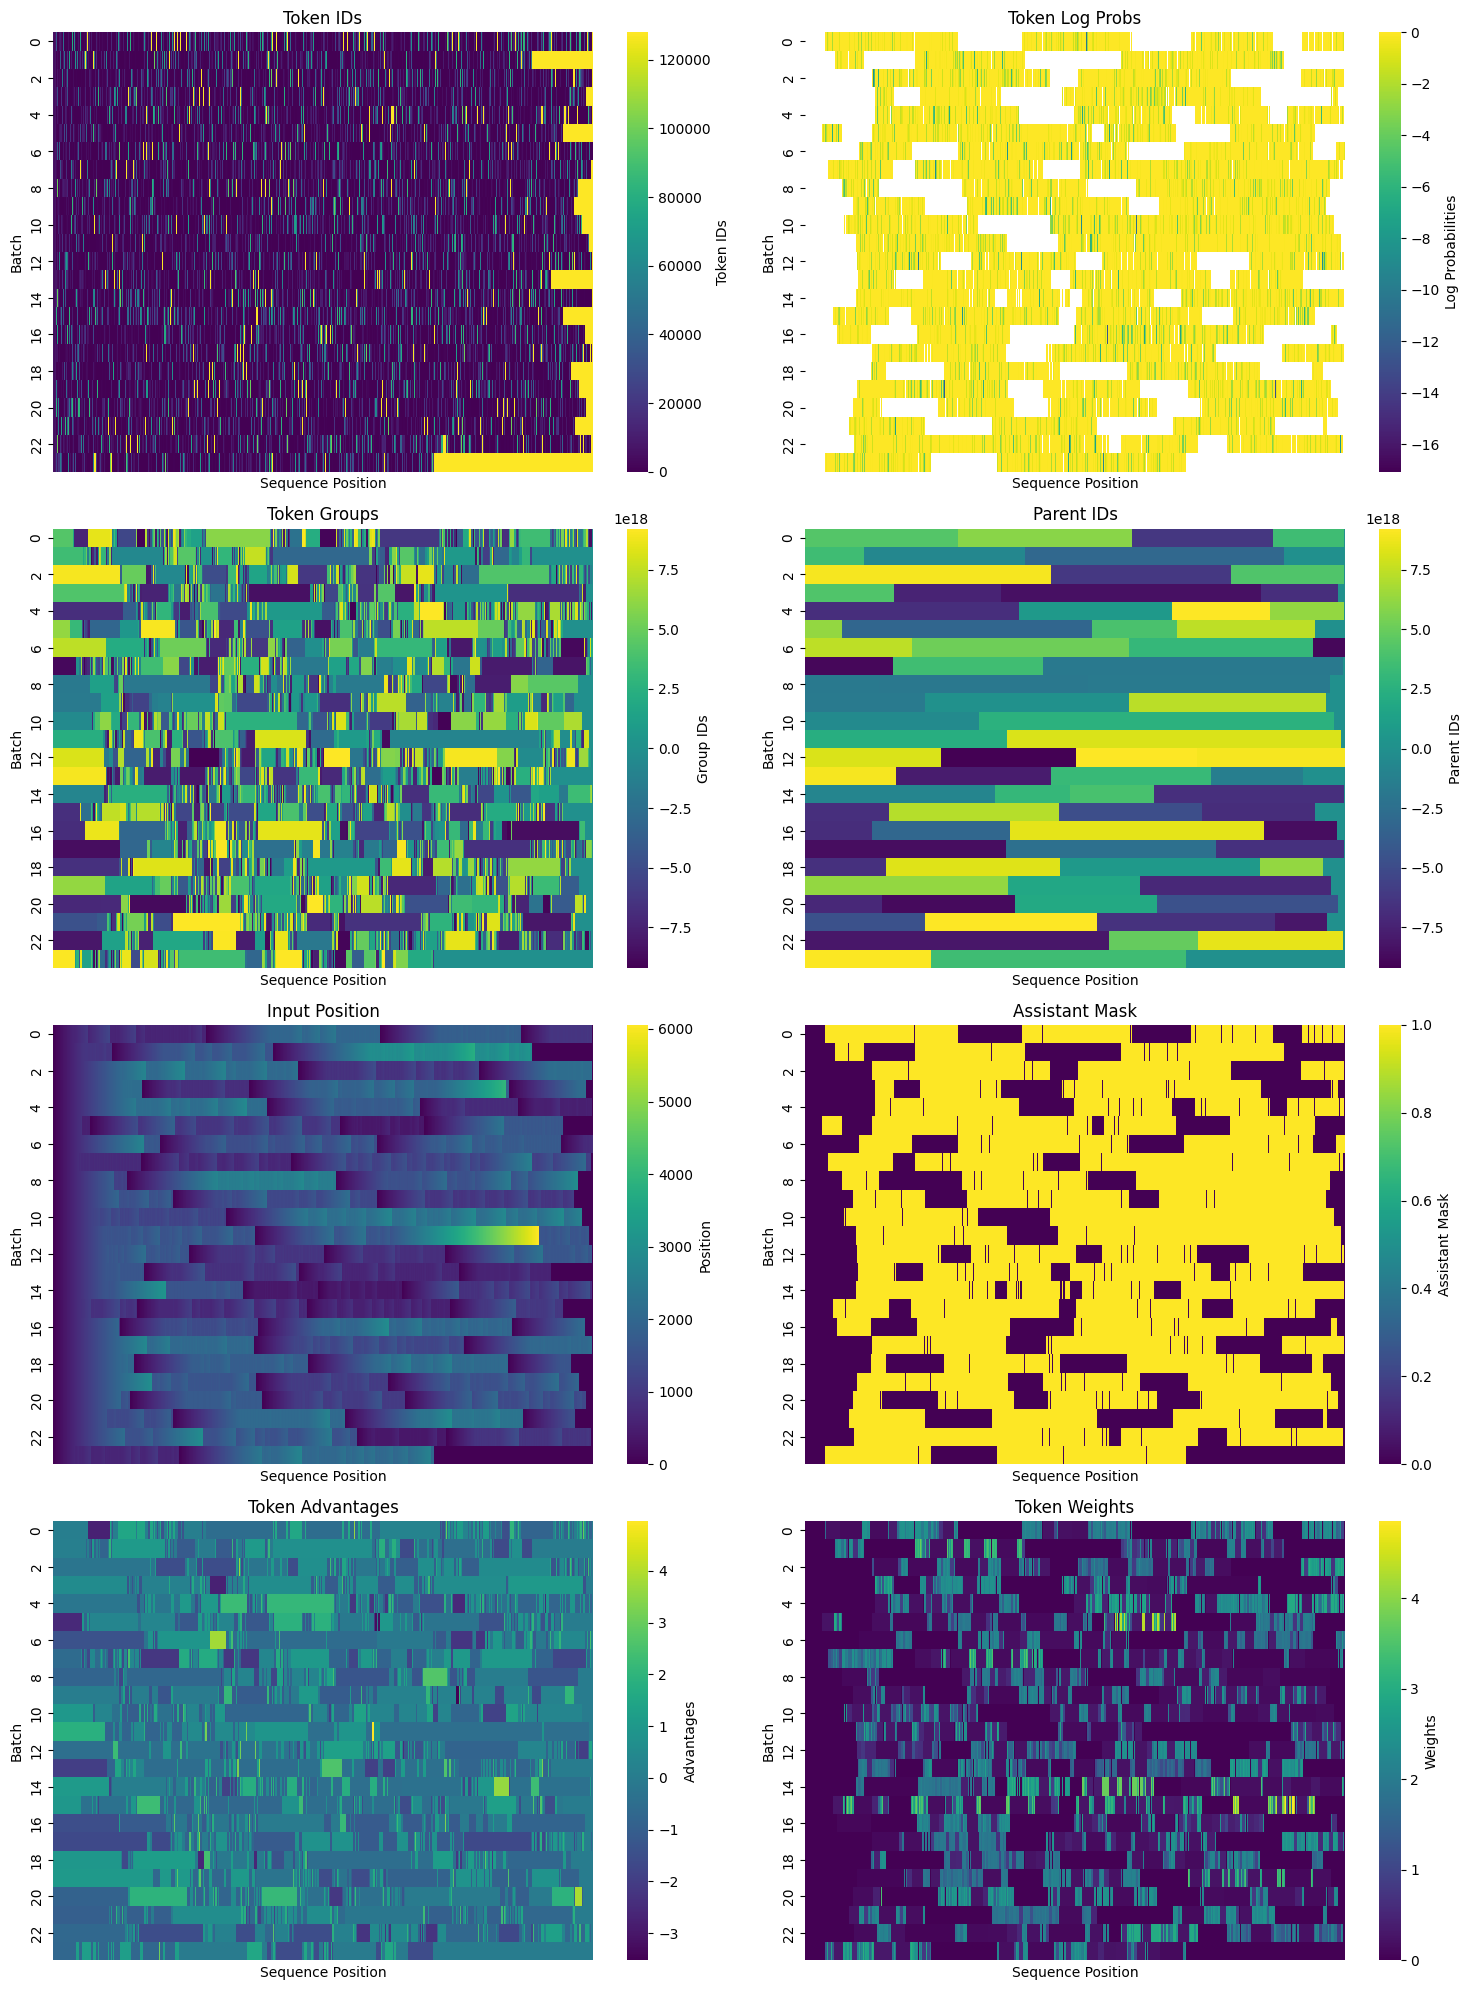

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0018
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 24
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740110971.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.62 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|12|Loss: 0.0110: 100%|██████████| 12/12 [03:51<00:00, 18.52s/it, entropy=0.421, kl_div=nan, loss=0.011, policy=0.011]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.55 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved to

Saved iteration #19 model files to ./models/024/0019
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0019 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0019 --port=8000 --api-key=default
INFO 02-21 04:14:18 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 04:14:18 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 04:14:18 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0019', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.37it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.08s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.54s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.68s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.44s/it]



INFO 02-21 04:14:39 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 04:14:40 worker.py:267] Memory profiling takes 0.71 seconds
INFO 02-21 04:14:40 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 04:14:40 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 04:14:40 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 04:14:40 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 04:15:25 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 46.03 seconds
INFO 02-21 04:15:26 api_server.py:756] Using supplied chat template:
INFO 02-21 04:15:26 api_server.py:756] None
INFO 02-21 04:15:26 launcher.py:21] Available routes are:
INFO 02-21 04:15:26 launcher.py:29] Route: /

INFO:     Started server process [22713]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 04:15:28 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:35238 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [01:58<00:00, 119.47it/s, completion_tokens=78, prompt_tokens=1.21e+3, reward=0.248, token_logprobs=249021]
Deleted iteration directory ./models/024/0017


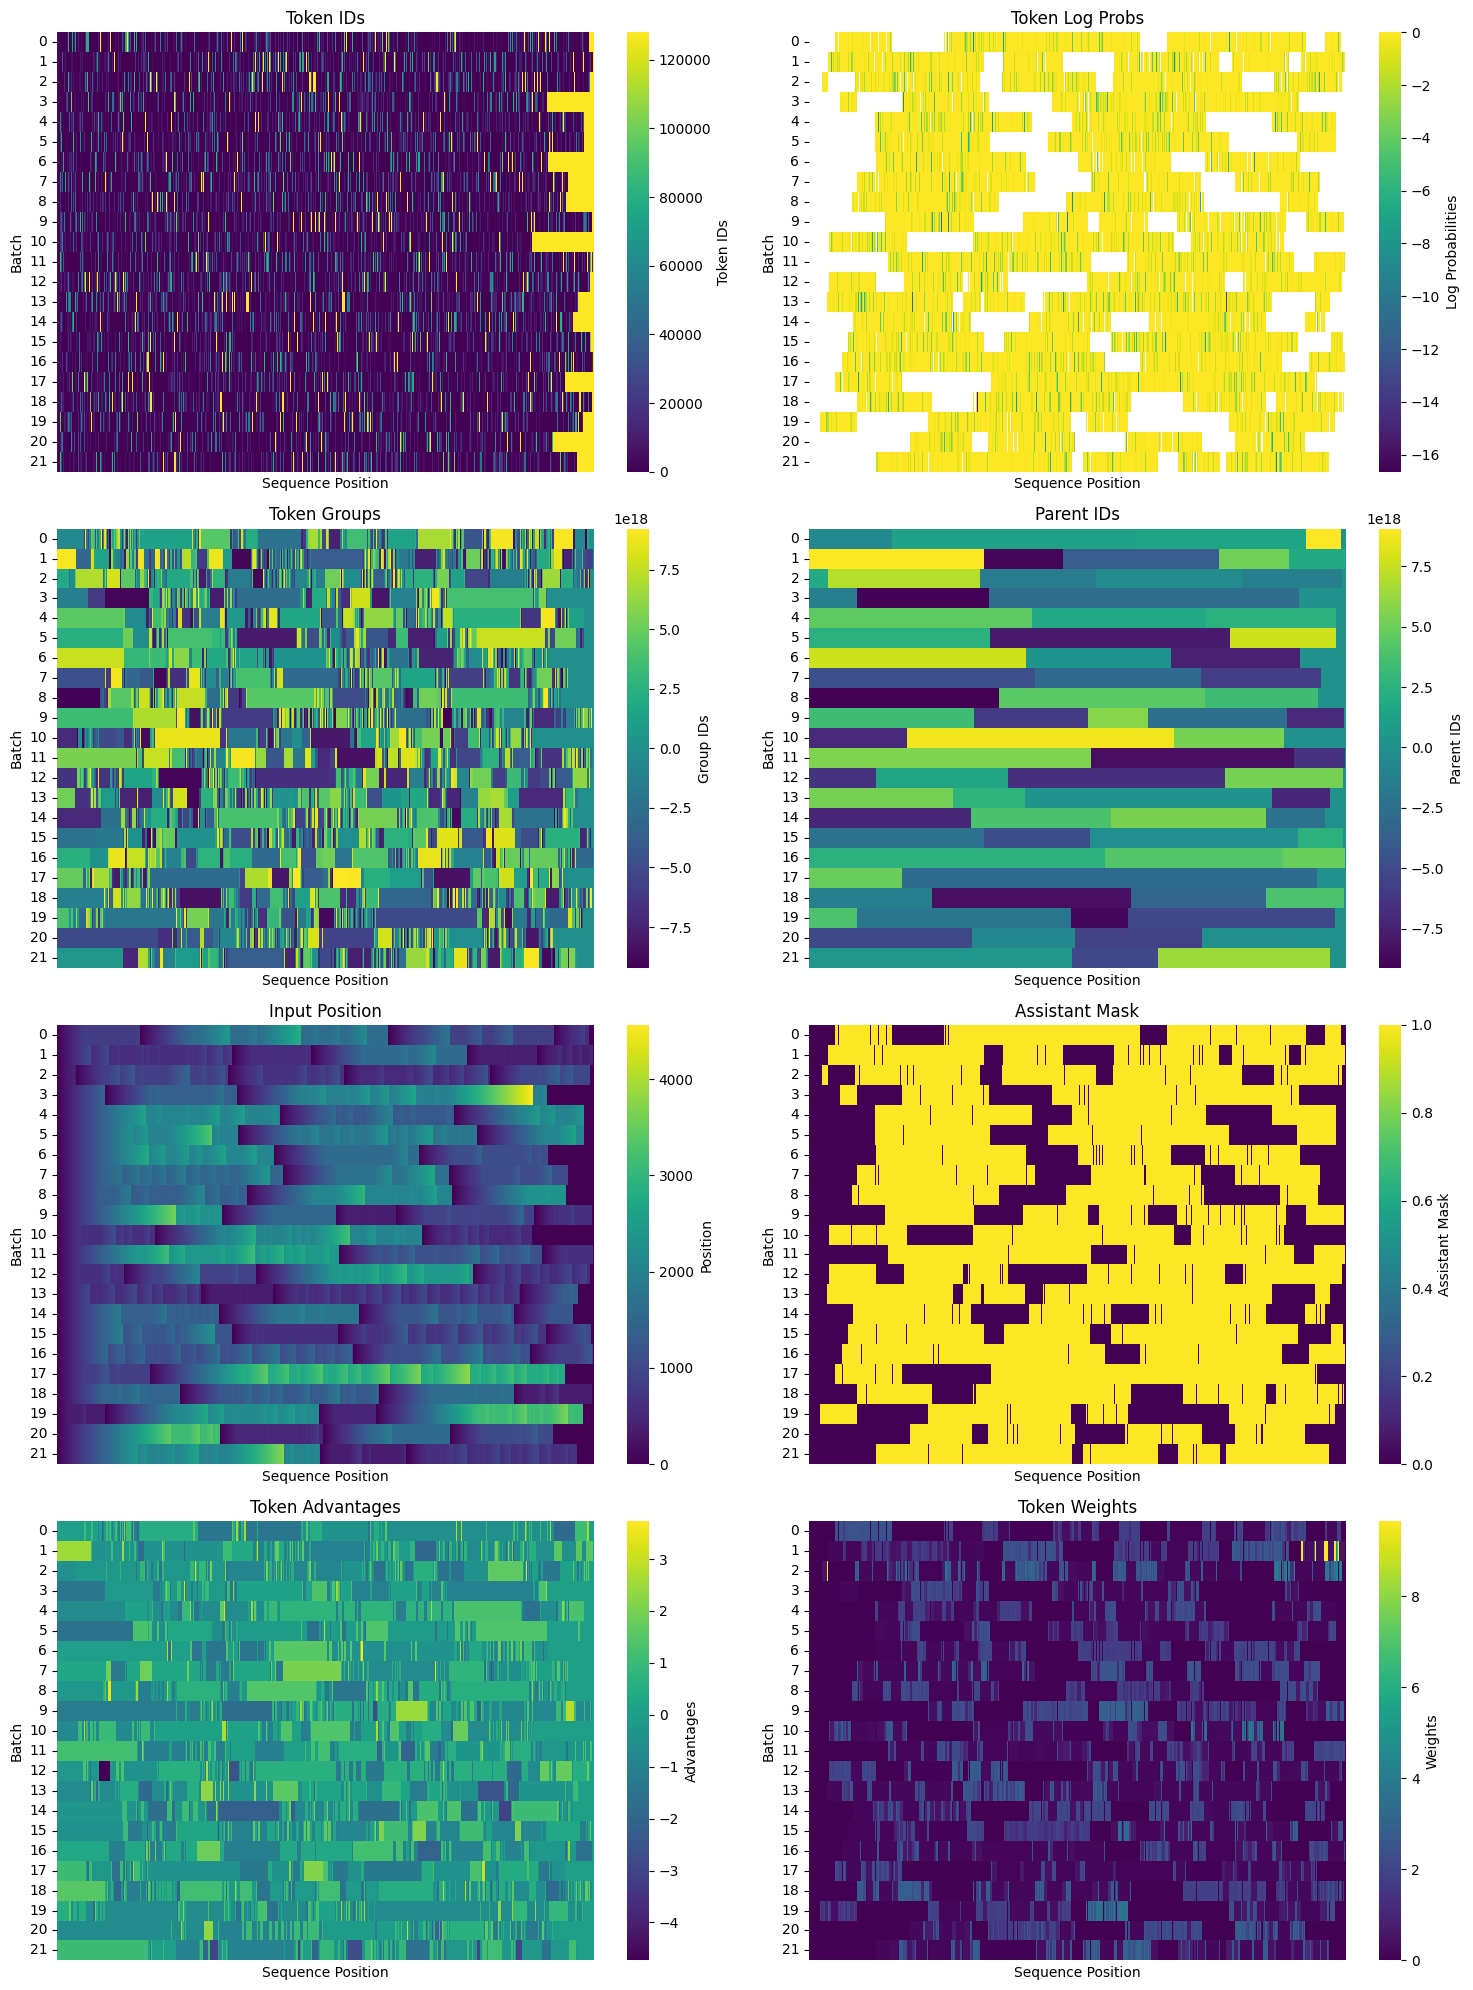

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0019
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 22
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740111471.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.70 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|11|Loss: 0.0185: 100%|██████████| 11/11 [03:33<00:00, 18.56s/it, entropy=0.315, kl_div=nan, loss=0.0185, policy=0.0185]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.67 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved to

Saved iteration #20 model files to ./models/024/0020
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0020 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0020 --port=8000 --api-key=default
INFO 02-21 04:22:19 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 04:22:20 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 04:22:20 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0020', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.44it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.15s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.53s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.67s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.43s/it]



INFO 02-21 04:22:40 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 04:22:41 worker.py:267] Memory profiling takes 0.69 seconds
INFO 02-21 04:22:41 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 04:22:41 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 04:22:41 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 04:22:41 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 04:23:26 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 45.70 seconds
INFO 02-21 04:23:27 api_server.py:756] Using supplied chat template:
INFO 02-21 04:23:27 api_server.py:756] None
INFO 02-21 04:23:27 launcher.py:21] Available routes are:
INFO 02-21 04:23:27 launcher.py:29] Route: /

INFO:     Started server process [23493]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 04:23:29 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:42682 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:34<00:00, 19.12it/s, completion_tokens=83, prompt_tokens=1.2e+3, reward=0.273, token_logprobs=267009]
Deleted iteration directory ./models/024/0019


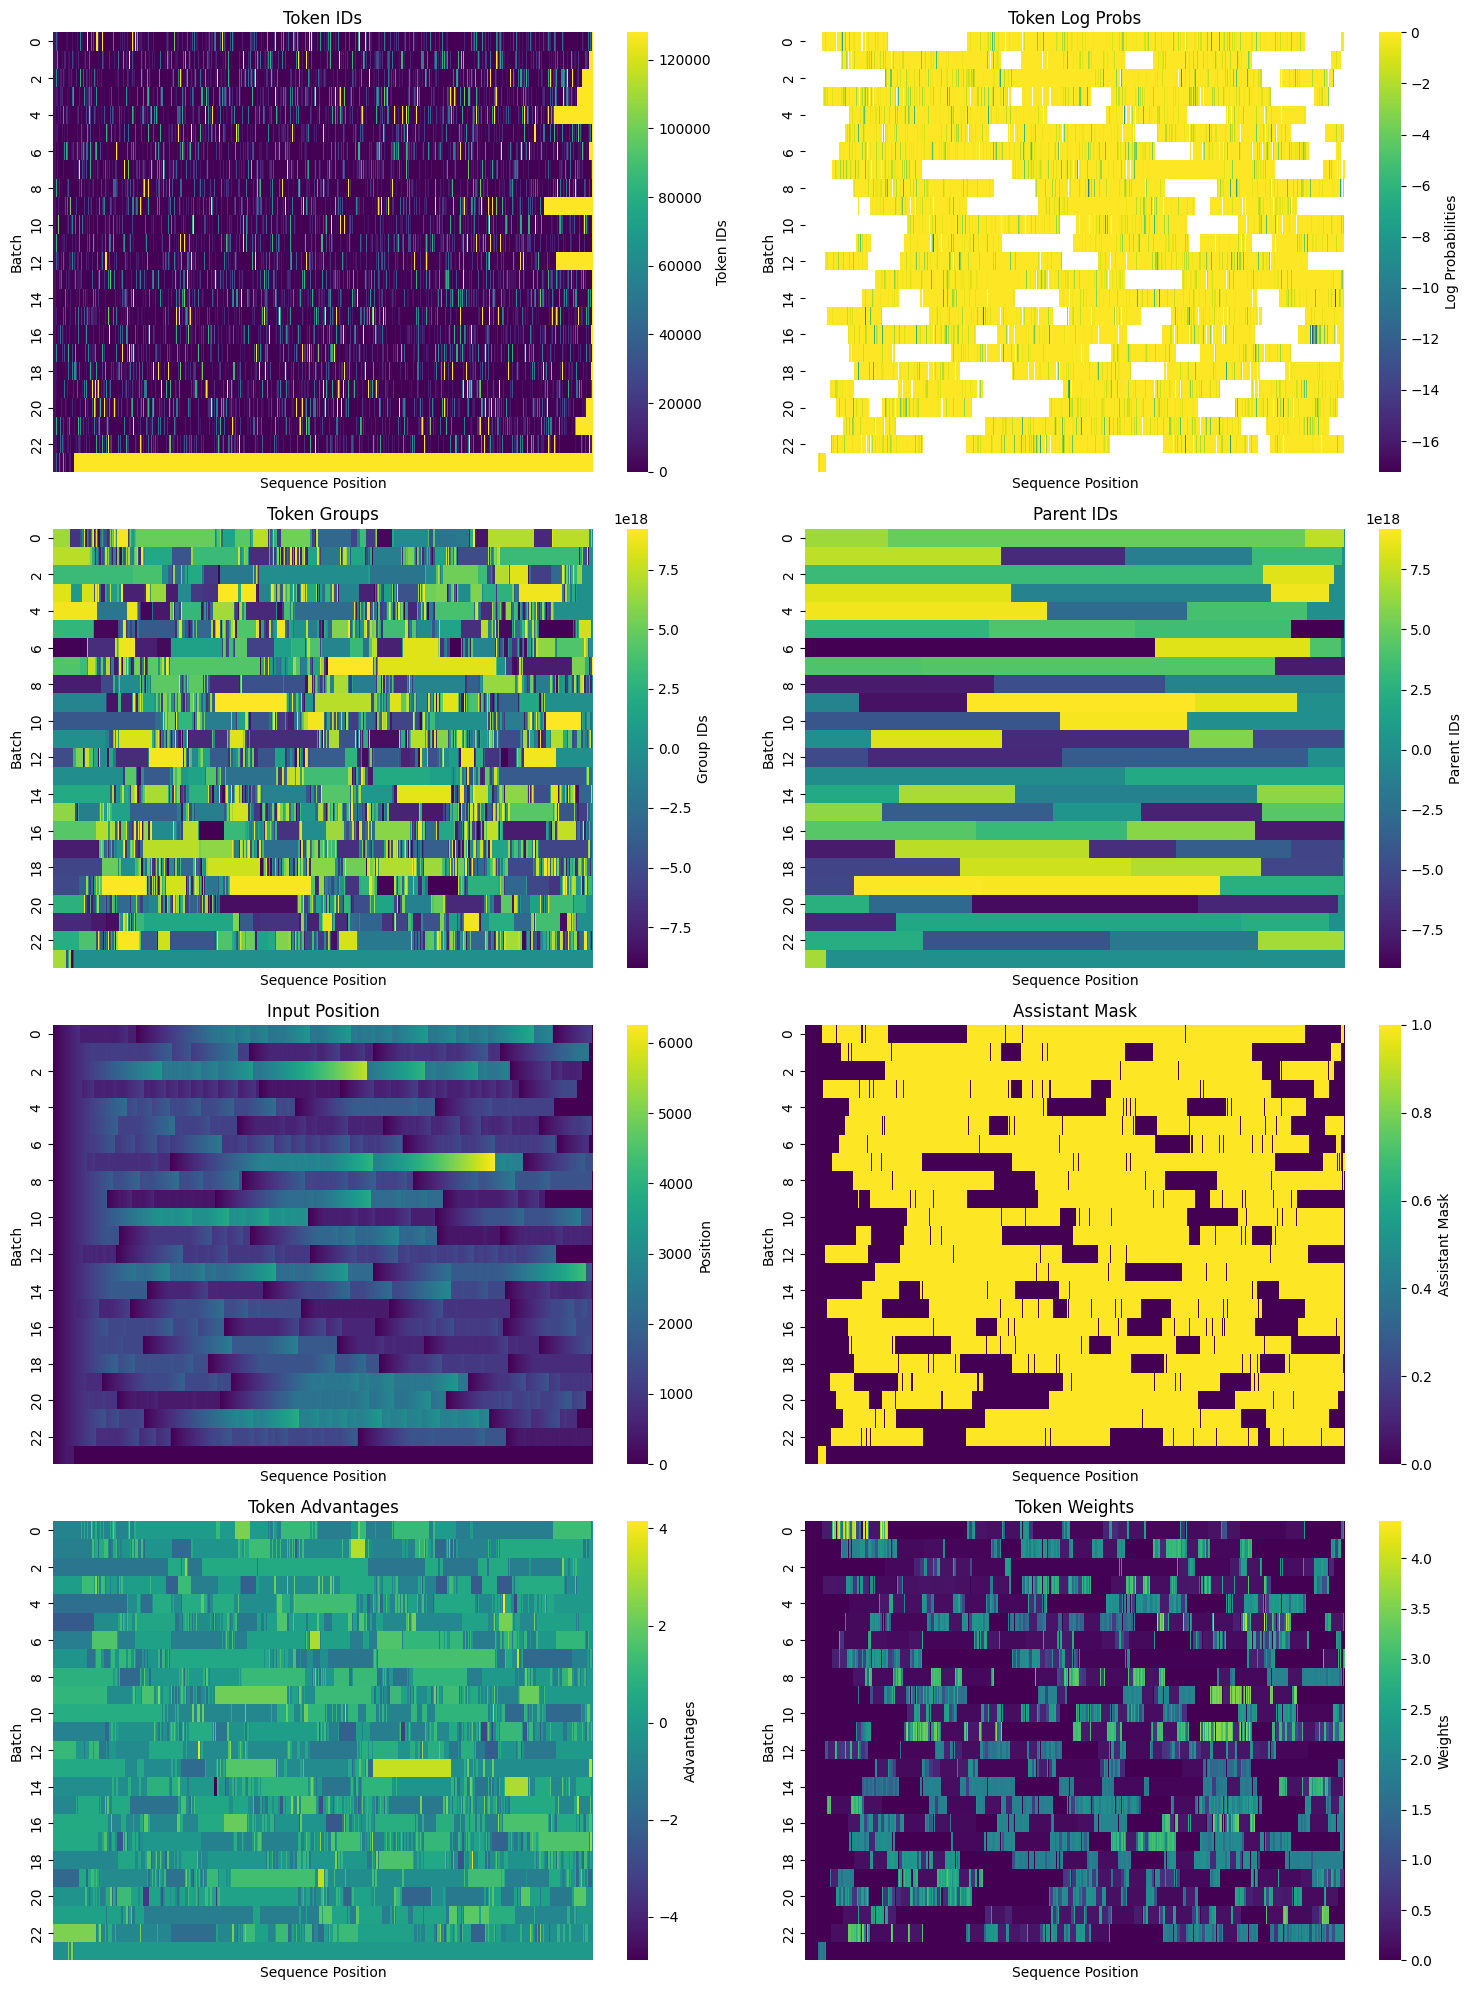

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/024/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/024/0020
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/024
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/024/tensors
  num_sequences: 24
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: false
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric

Writing logs to models/024/logs/log_1740111988.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.56 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|12|Loss: 0.0359: 100%|██████████| 12/12 [03:51<00:00, 18.51s/it, entropy=0.272, kl_div=nan, loss=0.0359, policy=0.0359]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.61 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved to

Saved iteration #21 model files to ./models/024/0021
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/024/0021 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/024/0021 --port=8000 --api-key=default
INFO 02-21 04:31:14 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 04:31:15 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 04:31:15 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/024/0021', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.40it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.08s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.53s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.68s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.43s/it]



INFO 02-21 04:31:35 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 04:31:36 worker.py:267] Memory profiling takes 0.68 seconds
INFO 02-21 04:31:36 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 04:31:36 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 04:31:36 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 04:31:36 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x


CancelledError: 

INFO 02-21 04:32:22 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 46.19 seconds


INFO 02-21 04:32:22 api_server.py:756] Using supplied chat template:
INFO 02-21 04:32:22 api_server.py:756] None
INFO 02-21 04:32:22 launcher.py:21] Available routes are:
INFO 02-21 04:32:22 launcher.py:29] Route: /openapi.json, Methods: GET, HEAD
INFO 02-21 04:32:22 launcher.py:29] Route: /docs, Methods: GET, HEAD
INFO 02-21 04:32:22 launcher.py:29] Route: /docs/oauth2-redirect, Methods: GET, HEAD
INFO 02-21 04:32:22 launcher.py:29] Route: /redoc, Methods: GET, HEAD
INFO 02-21 04:32:22 launcher.py:29] Route: /health, Methods: GET
INFO 02-21 04:32:22 launcher.py:29] Route: /ping, Methods: GET, POST
INFO 02-21 04:32:22 launcher.py:29] Route: /tokenize, Methods: POST
INFO 02-21 04:32:22 launcher.py:29] Route: /detokenize, Methods: POST
INFO 02-21 04:32:22 launcher.py:29] Route: /v1/models, Methods: GET
INFO 02-21 04:32:22 launcher.py:29] Route: /version, Methods: GET
INFO 02-21 04:32:22 launcher.py:29] Route: /v1/chat/completions, Methods: POST
INFO 02-21 04:32:22 launcher.py:29] Route: 

INFO:     Started server process [24182]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


In [5]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
    except Exception:
        pass
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/"))
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir, 
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=2,
        ),
        verbosity=verbosity,
    )
wandb.finish()